# Sentiment Analysis
Elisa Fascio, David Leiva, Carolina Migliorelli y Montse Rodriguez


In [1]:
# Preparamos el entorno y cargamos los packages que vamos a necesitar
import sys
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
matplotlib.rcParams['figure.dpi'] = 200

try:
    import seaborn as sns
except:
    print('Seaborn must be installed to continue (pip install seaborn).\nIt provides an enhanced plotting experience', file=sys.stderr)
    if input('Do you want me to do it for you? y/n') == 'y':
        !pip install seaborn
    
    import seaborn as sns

In [2]:
# Instalación de WordCloud y STOPWORDS si no están instalados.
try:
    from wordcloud import WordCloud, STOPWORDS
except:
    print('For the next cells you need WordCloud (pip install wordcloud)', file=sys.stderr)
    if input('Do you want me to do it for you? y/n') == 'y':
        !pip install wordcloud
        
    from wordcloud import WordCloud, STOPWORDS

## Cargamos los datos

Leemos los csv (original y texto de tweet procesado).

In [3]:
# Read CSV file
df1 = pd.read_csv('tweets_processed.csv', index_col='tweet_id')
df2 = pd.read_csv('tweets_public.csv', index_col='tweet_id')

df = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')
df.rename(columns = {'airline_sentiment_x':'airline_sentiment'}, inplace = True)
df.drop('airline_sentiment_y', axis=1, inplace=True)

df.info()
# How many tweets do we have?
print("Number of tweets:", df.shape[0])

# Show first rows on dataframe
df.tail(100)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7867 entries, 926419989107798016 to 935546571663527936
Data columns (total 21 columns):
airline_sentiment    7867 non-null object
whole_tweet          7867 non-null object
emoticon             7867 non-null object
mentions             7867 non-null object
hashtags             7867 non-null object
airline              7867 non-null object
n_words              7867 non-null int64
n_words_mayus        7867 non-null int64
n_words_mayus_len    7867 non-null int64
n_suspensivos        7867 non-null int64
n_exclamations       7867 non-null int64
n_questions          7867 non-null int64
len_tw               7867 non-null int64
is_reply             7867 non-null bool
reply_count          7867 non-null int64
retweet_count        7867 non-null int64
text                 7867 non-null object
tweet_coord          20 non-null object
tweet_created        7867 non-null object
tweet_location       419 non-null object
user_timezone        5100 non-null o

,airline_sentiment,whole_tweet,emoticon,mentions,hashtags,airline,n_words,n_words_mayus,n_words_mayus_len,n_suspensivos,...,n_questions,len_tw,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,,,,,,,,
946521123382013958,positive,mas que espectacular,[],[],[],[],3,0,0,0,...,0,21,True,0,0,@Iberia Más que espectacular!!!,NaN,Thu Dec 28 23:19:55 +0000 2017,NaN,Mountain Time (US & Canada)
942698237978345472,positive,los sindicatos de ryanair levantan los paros navidenos,[],[],[],['ryanair'],10,0,0,0,...,0,55,False,0,0,Los sindicatos de Ryanair levantan los paros navideños - https://t.co/LEUAuglbiD,NaN,Mon Dec 18 10:09:09 +0000 2017,NaN,Buenos Aires
940651443014524929,negative,irlanda pilotos de aerolinea ryanair iniciaron huelga por mejores remuneraciones salariales,[],[],"['Irlanda', 'Ryanair']",['ryanair'],13,0,0,0,...,0,91,False,0,0,#Irlanda | Pilotos de aerolínea #Ryanair iniciaron huelga por mejores remuneraciones salariales… https://t.co/7BDxUwxFrW,NaN,Tue Dec 12 18:35:55 +0000 2017,NaN,Caracas
942051095668494336,negative,es broma iberia que su oficina de equipaje perdido en mad esta haciendo siesta cierto,[],['Iberia'],[],['iberia'],15,1,3,0,...,1,86,False,0,0,Es broma @Iberia que su oficina de equipaje perdido en MAD esta haciendo siesta. Cierto?,NaN,Sat Dec 16 15:17:38 +0000 2017,NaN,NaN
934029086833254400,positive,2018 iberia tendra mas vuelos y clase turista premium,[],[],[],['iberia'],12,0,0,0,...,0,54,False,0,0,"En 2018, Iberia tendrá más vuelos y clase Turista Premium https://t.co/Vj8EGQ9oDd https://t.co/g6xqverOsN",NaN,Fri Nov 24 12:01:02 +0000 2017,NaN,Buenos Aires
946132222867853312,negative,de ios la ultima version acabo de hacer el check in de otra reserva y si me permite la opcion de bajar al passbook pero la otra reserva no,[],[],[],[],29,0,0,1,...,1,139,True,0,0,@Iberia De ios? La ultima versión. Acabo de hacer el check in de otra reserva y si me permite la opcion de bajar al… https://t.co/LEcIM47EV5,NaN,Wed Dec 27 21:34:34 +0000 2017,NaN,Madrid
934231595623636992,negative,iberia pago 1reserva error en la emision del billete aunq mi banco confirma el pago 45min por tel y nadie puede hacer nada solucion,[],['Iberia'],[],['iberia'],24,0,0,0,...,2,132,True,0,0,@Iberia Pago 1reserva. Error en la emisión del billete aunq mi banco confirma el pago. 45min por tel y nadie puede hacer nada? solución?,NaN,Sat Nov 25 01:25:44 +0000 2017,NaN,NaN
948713185737134080,negative,asi se bajo un pasajero de ryanair harto de esperar para desembarcar,[],[],[],['ryanair'],13,0,0,0,...,0,68,False,0,0,Así se bajó un pasajero de RyanAir harto de esperar para desembarcar https://t.co/XDdSMpCidz https://t.co/kxaeIRhqta,NaN,Thu Jan 04 00:30:24 +0000 2018,NaN,Pacific Time (US & Canada)
936238952293511168,neutral,hola iberia tengo una duda respecto al equipaje de cabina esta permitido una maleta pero ademas de puede una mochila de tamano estandar que contiene un portatil gracias,[],"['Iberia,']",[],['iberia'],28,0,0,0,...,2,169,False,0,0,"Hola @Iberia, tengo una duda respecto al equipaje de cabina. Está permitido una maleta, pero además de puede una mo… https://t.co/vRgLVoBMSI",NaN,Thu Nov 30 14:22:15 +0000 2017,"Pozuelo de Alarcón, España",Madrid


## Preparamos el dataset

Fijamos formatos adecuados y creamos nuevas variables para el análisi.

In [4]:
# CAMBIAMOS EL FORMATO DE TWEET_CREATED A DATETIME
df.tweet_created = pd.to_datetime(df.tweet_created)

# CREAMOS NUEVAS COLUMNAS PARA EL DÍA DE LA SEMANA Y LA HORA DEL DÍA
df['weekday'] = df['tweet_created'].dt.weekday
df['dayhour'] = df['tweet_created'].dt.hour

# CREAMOS NUEVAS COLUMNAS PARA VER COMPORTAMIENTO ESPECÍFICO EN FIN DE SEMANA Y EN TARDE-NOCHE

df['finde']=np.where(df['weekday']<5,0,1)
df['lun_mar']=np.where(df['weekday']<2,1,0)
df['jue_vie']=df['weekday'].apply(lambda x: int(bool(x>2 and x<5)))
df['time_negat']=df['dayhour'].apply(lambda x: int(bool(x>=18 and x<22 or x>=6 and x<9)))
df['noche']=df['dayhour'].apply(lambda x: int(bool(x>=22 or x<6)))
df['time_labor']=df['dayhour'].apply(lambda x: int(bool(x>=9 and x<18)))

# PASAMOS A CATEGÓRICAS LAS VARIABLES CORRESPONDIENTES
df.airline_sentiment=pd.Categorical(df.airline_sentiment)
df.tweet_location=pd.Categorical(df.tweet_location)

# RELLENAMOS NAN EN USER_TIMEZONE A 'NO_ZONE' Y PASAMOS A CATEGORÍAS
df.user_timezone=df.user_timezone.replace(np.nan, 'No_zone')
df.user_timezone=pd.Categorical(df.user_timezone)

# PASAMOS IS_REPLAY DE VALORES BOOLEAN A BINARIO
df.is_reply=df.is_reply.astype(int)

# ELIMINAMOS REPLY_COUNT Y RETWEET_COUNT
df.drop(['reply_count','retweet_count'],axis=1,inplace=True)

# NUEVA COLUMNA DONDE PASAMOS EL SENTIMIENTO A VALOR DE POLARIDAD (-1, 0, 1) POR SI CONVIENE SU USO ASÍ
df['airsent_pol'] = np.copy(df.airline_sentiment)

df.airsent_pol=df.airsent_pol.replace('negative',-1)
df.airsent_pol=df.airsent_pol.replace('neutral',0)
df.airsent_pol=df.airsent_pol.replace('positive',1)


df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7867 entries, 926419989107798016 to 935546571663527936
Data columns (total 28 columns):
airline_sentiment    7867 non-null category
whole_tweet          7867 non-null object
emoticon             7867 non-null object
mentions             7867 non-null object
hashtags             7867 non-null object
airline              7867 non-null object
n_words              7867 non-null int64
n_words_mayus        7867 non-null int64
n_words_mayus_len    7867 non-null int64
n_suspensivos        7867 non-null int64
n_exclamations       7867 non-null int64
n_questions          7867 non-null int64
len_tw               7867 non-null int64
is_reply             7867 non-null int64
text                 7867 non-null object
tweet_coord          20 non-null object
tweet_created        7867 non-null datetime64[ns]
tweet_location       419 non-null category
user_timezone        7867 non-null category
weekday              7867 non-null int64
dayhour             

,n_words,n_words_mayus,n_words_mayus_len,n_suspensivos,n_exclamations,n_questions,len_tw,is_reply,weekday,dayhour,finde,lun_mar,jue_vie,time_negat,noche,time_labor,airsent_pol
count,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000,7867.000000
mean,19.456337,0.739545,3.692640,0.140460,0.317910,0.208974,111.658447,0.475404,2.506801,13.859159,0.143892,0.343968,0.346638,0.293123,0.167027,0.539850,-0.289818
std,11.267666,3.653769,20.362956,0.443014,0.895784,0.613482,63.924601,0.499426,1.774626,5.699683,0.351003,0.475061,0.475929,0.455223,0.373024,0.498441,0.764488
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,101.000000,0.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,137.000000,1.000000,4.000000,18.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,59.000000,43.000000,231.000000,9.000000,11.000000,8.000000,305.000000,1.000000,6.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# CREAMOS NUEVAS VARIABLES PARA ANALIZAR EL EFECTO DE LAS PRINCIPALES AEROLÍNEAS

df['iberia'] = 0
df['ryanair'] = 0
df['vueling'] = 0
df['otras_cias'] = 0
df['compania']=''

for indice_fila, fila in df.iterrows():
    airlines1=df.get_value(indice_fila,'airline').split()
    long=len(airlines1)
    for cia in airlines1:
        
        cia=re.sub('[^A-Za-z0-9]+','',cia)
    #print(airlines1)
        if cia =='iberia' or cia=='iberiaexpress':
            df.set_value(indice_fila,'iberia',1,takeable=False)
            if long==1:
                df.set_value(indice_fila,'compania','iberia',takeable=False)
        elif cia =='vueling':
            df.set_value(indice_fila,'vueling',1,takeable=False)
            if long==1:
                df.set_value(indice_fila,'compania','vueling',takeable=False)
        elif cia =='ryanair':
            df.set_value(indice_fila,'ryanair',1,takeable=False)
            if long==1:
                df.set_value(indice_fila,'compania','ryanair',takeable=False)
        elif cia=='':
            cia=''
        else:
            df.set_value(indice_fila,'otras_cias',1,takeable=False)
            if long==1:
                df.set_value(indice_fila,'compania','otras',takeable=False)

## SENTIMIENTOS

In [6]:
sentiments = df.groupby('airline_sentiment').size()
print('Nº de tweets según sentimiento:\n', sentiments)
print('% de tweets según sentimiento:\n', sentiments/df['airline_sentiment'].count())

Nº de tweets según sentimiento:
 airline_sentiment
negative    3769
neutral     2609
positive    1489
dtype: int64
% de tweets según sentimiento:
 airline_sentiment
negative    0.479090
neutral     0.331638
positive    0.189272
dtype: float64


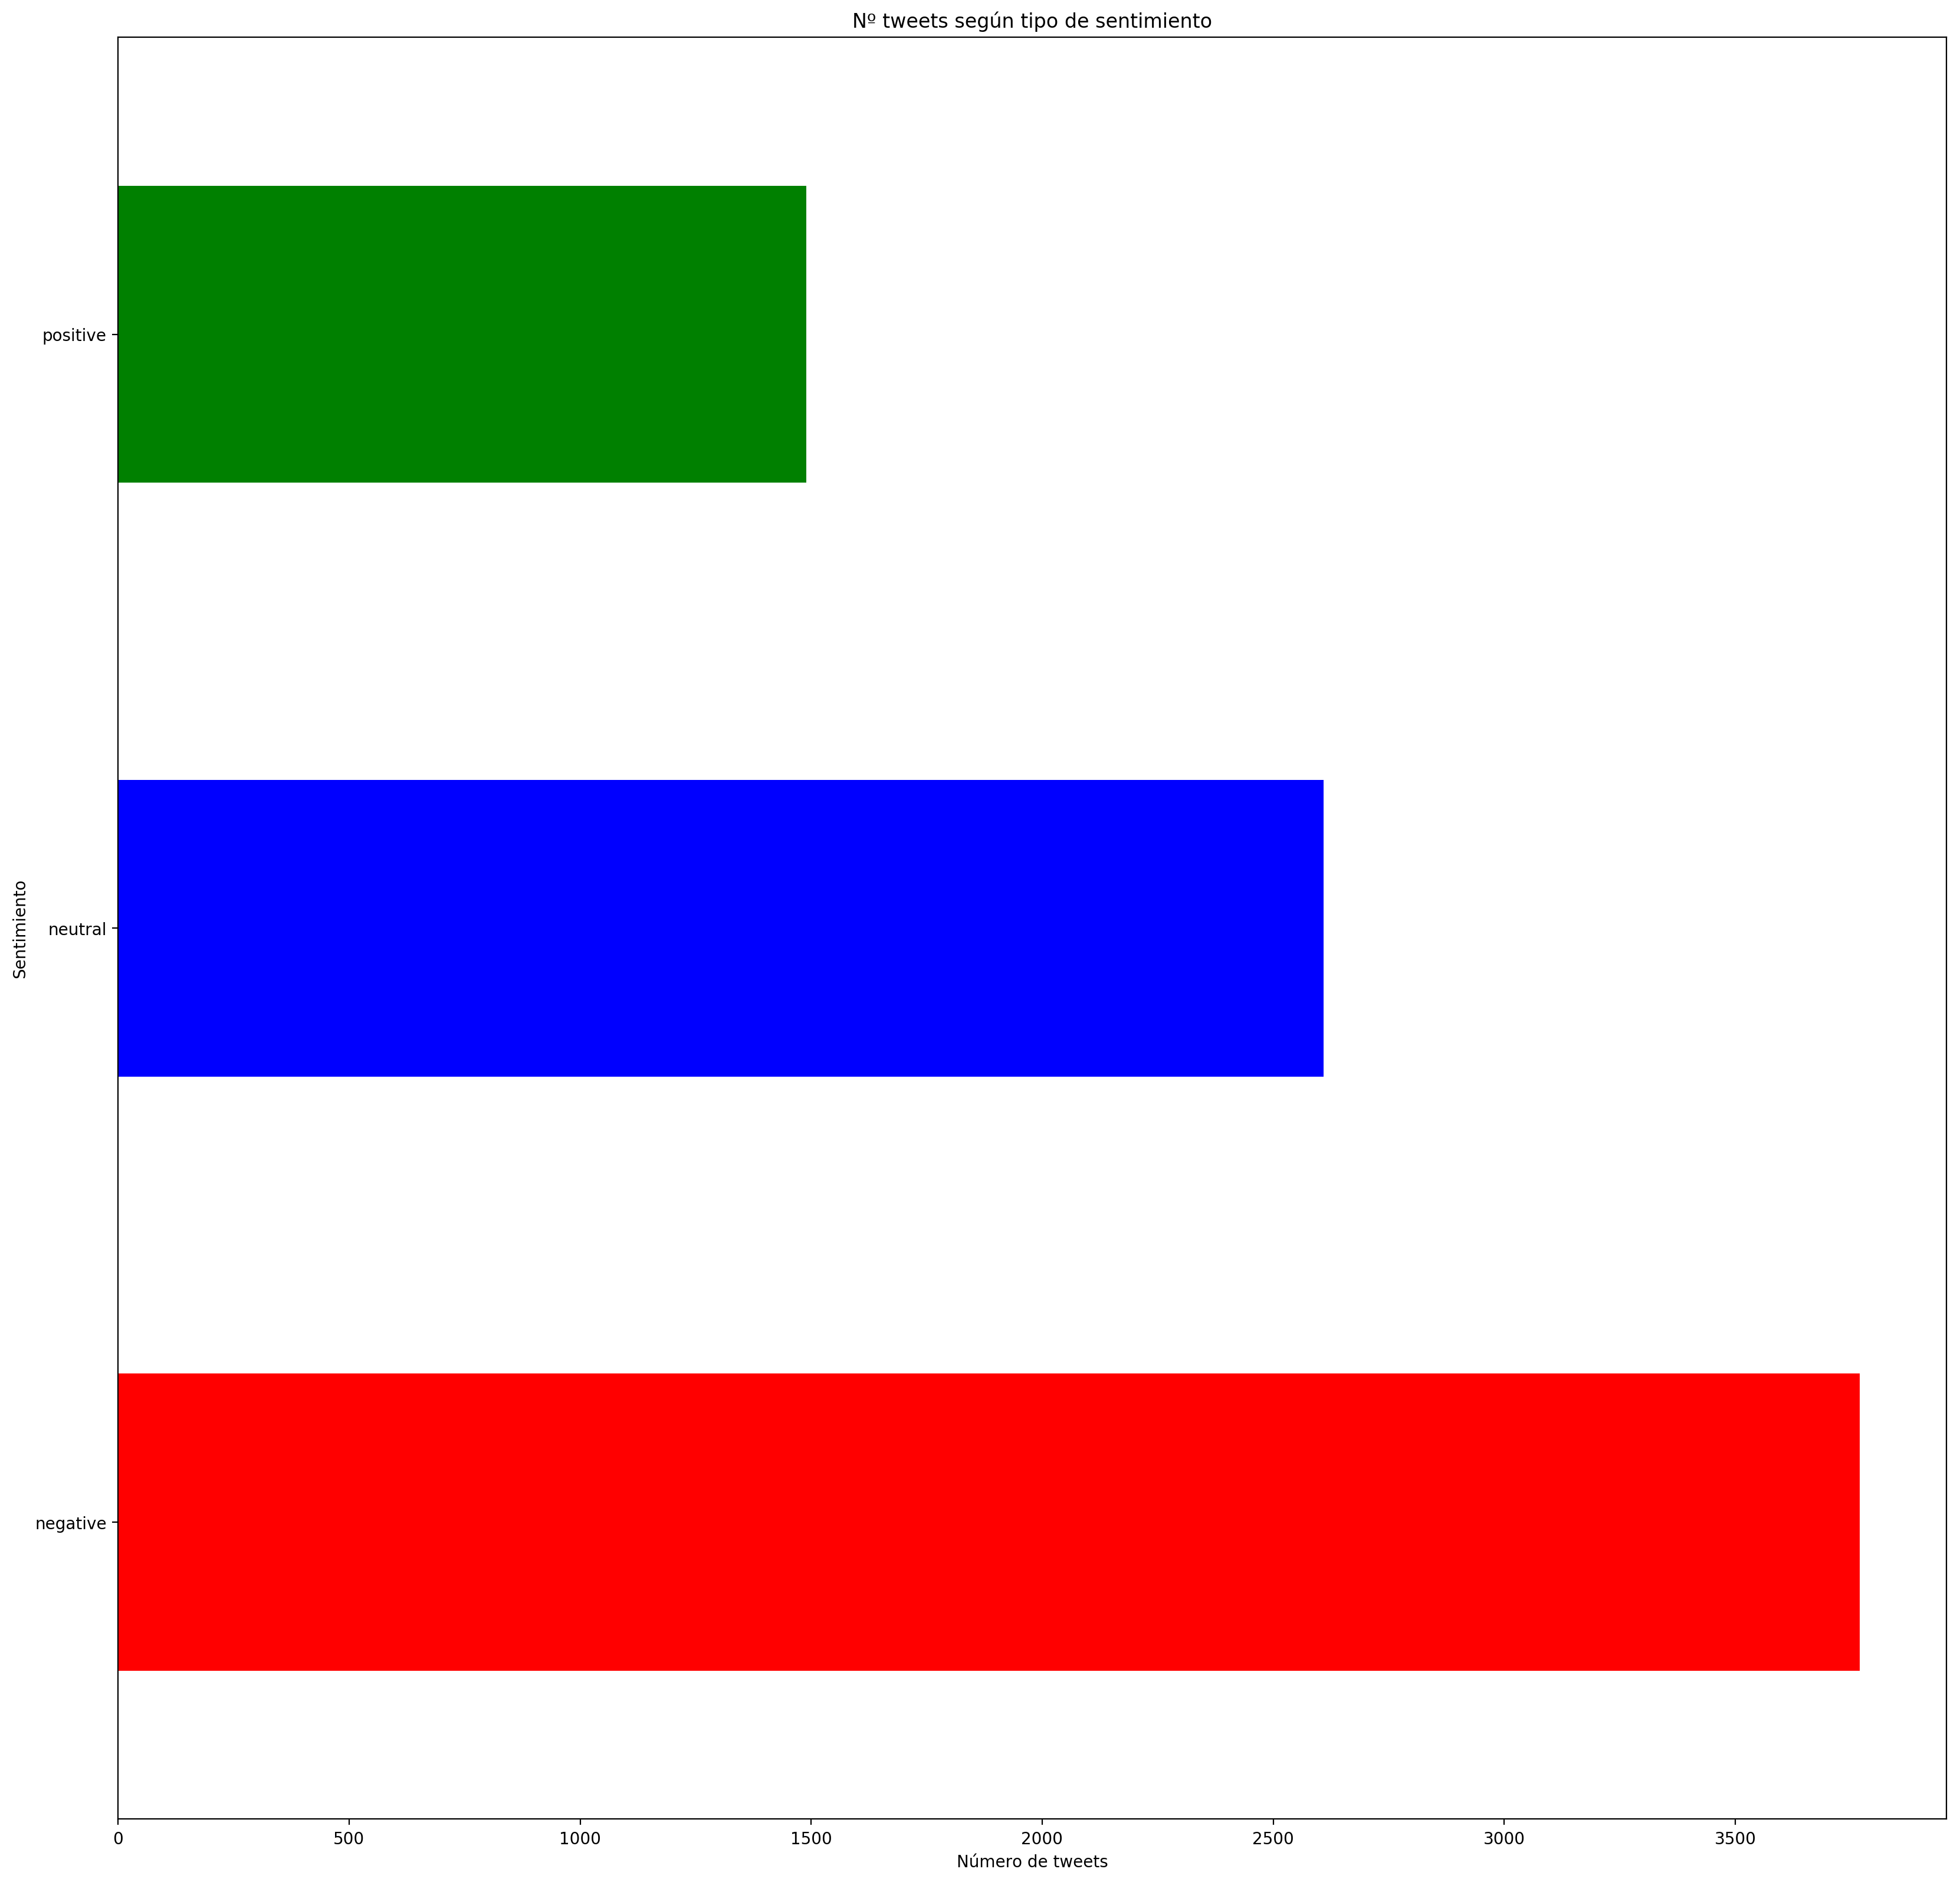

In [19]:
ax = sentiments.plot.barh(color='rbg',title='Nº tweets según tipo de sentimiento')
# Rename axes labels
ax.set_ylabel('Sentimiento')
ax.set_xlabel('Número de tweets')

## Análisis AEROLÍNEAS



7867

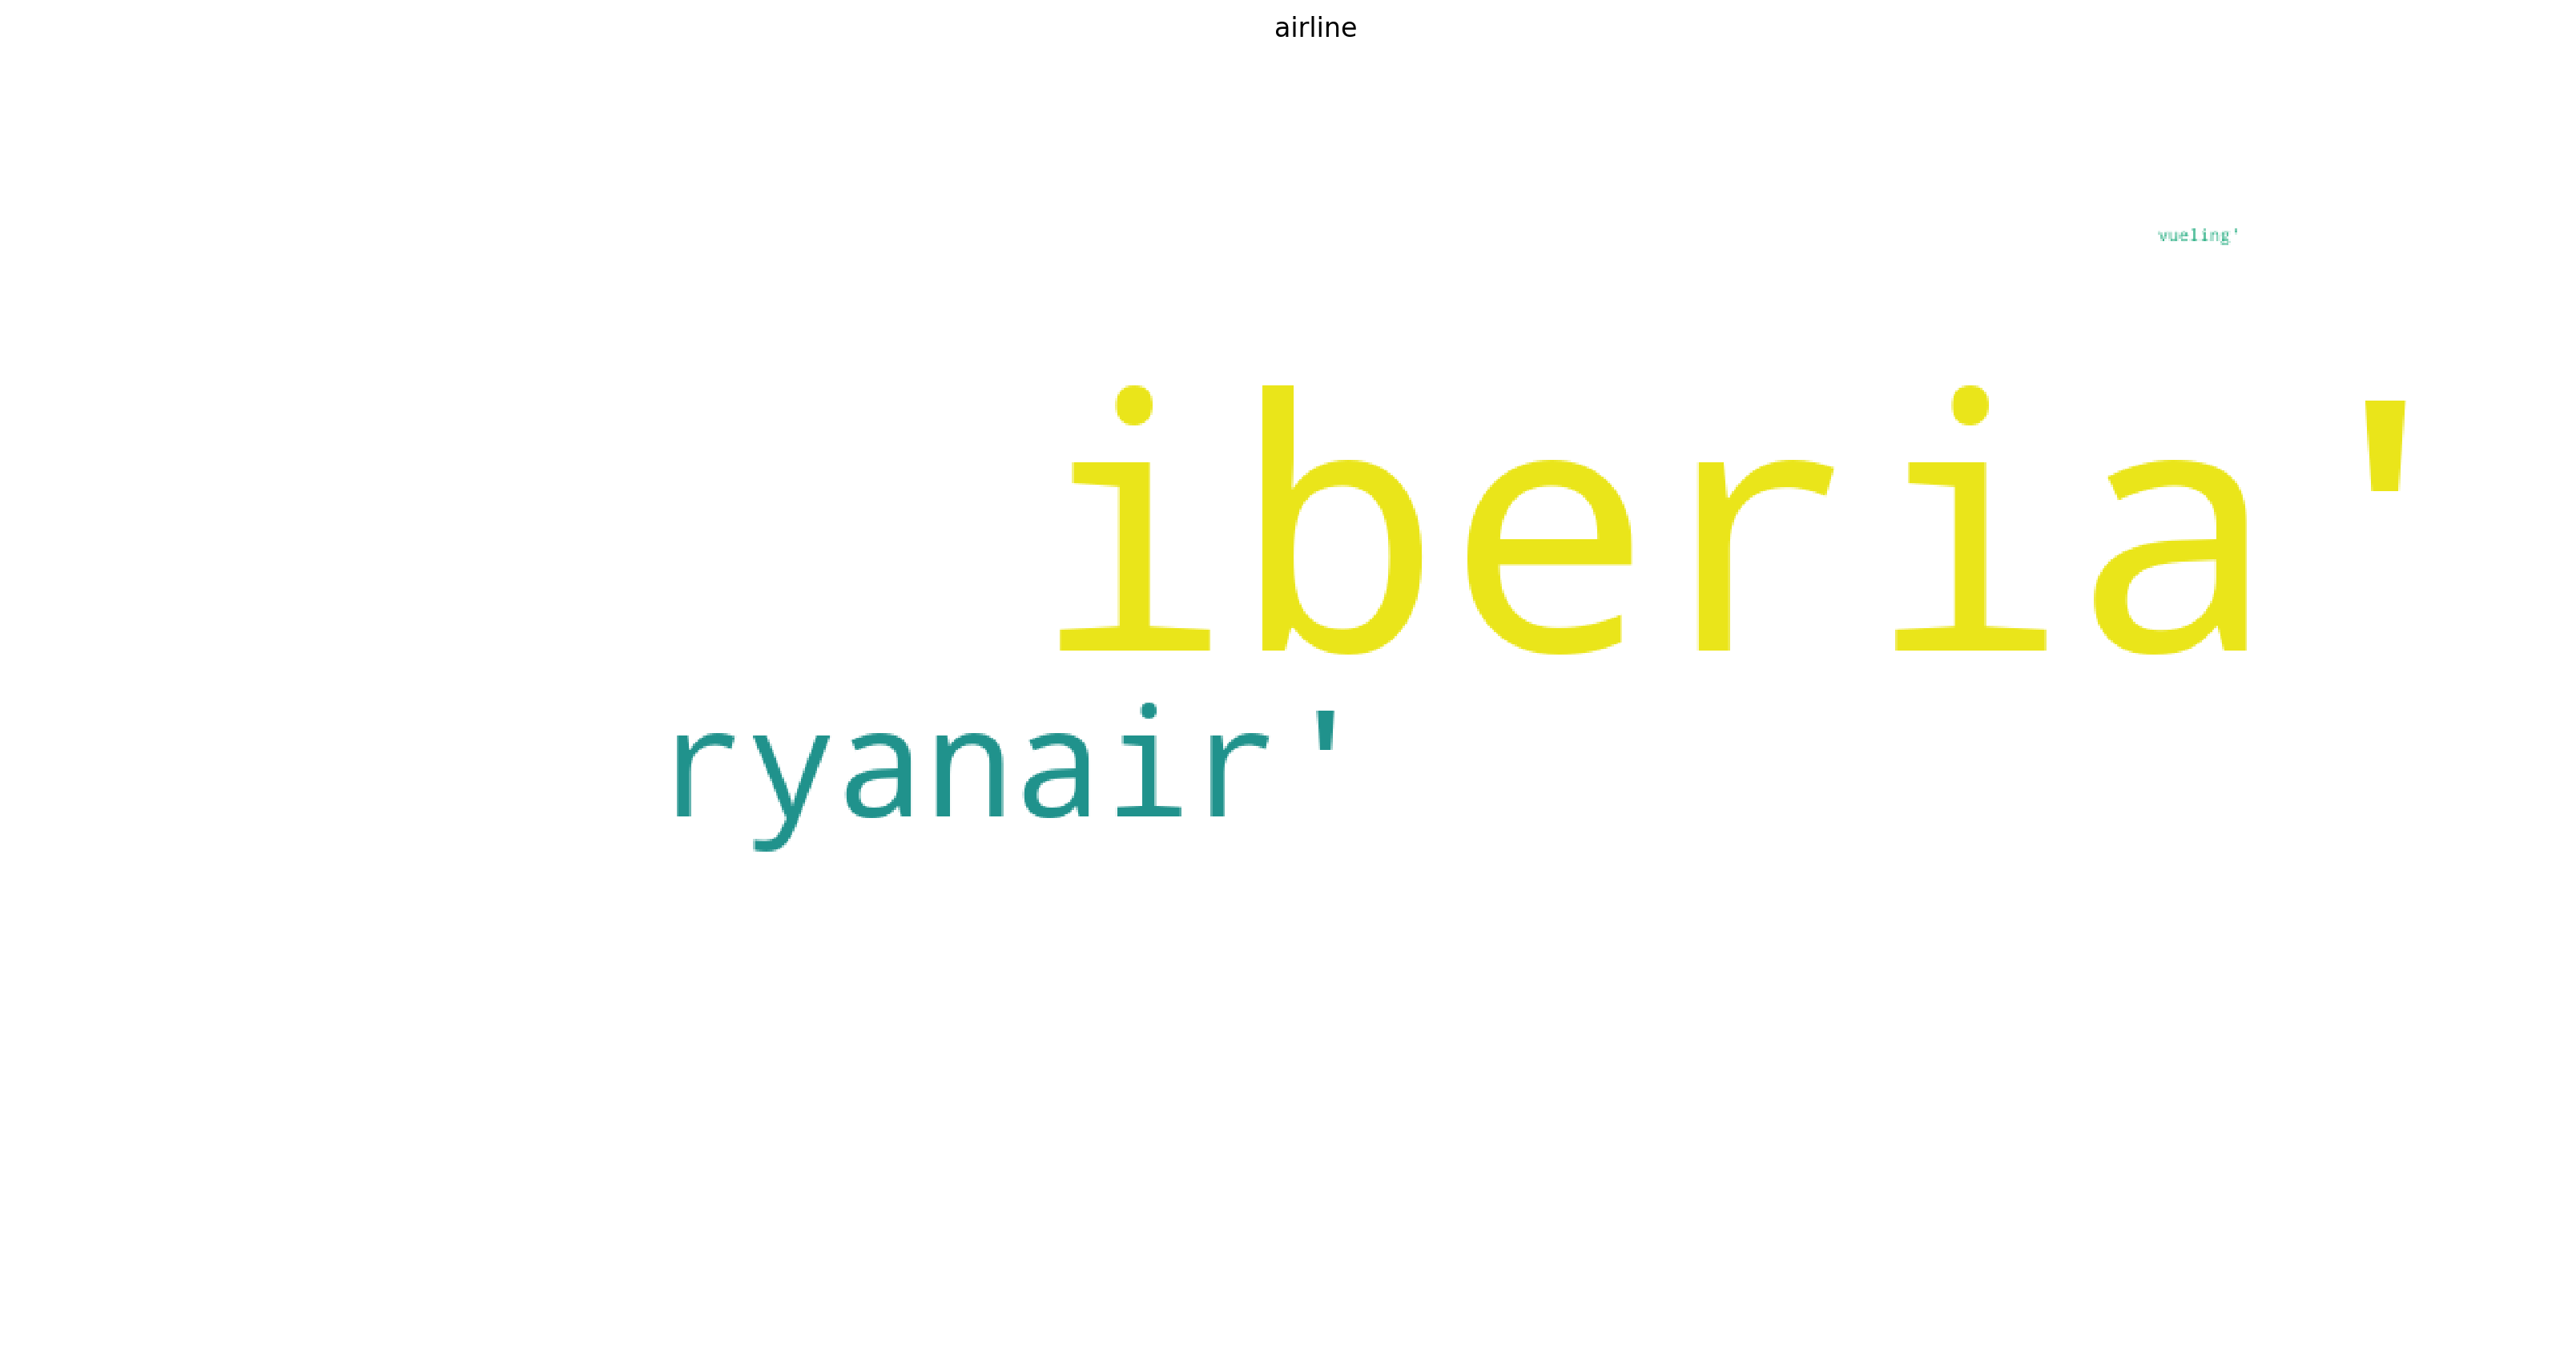

In [12]:
# WORDCLOUD PARA VER LA FRECUENCIA DE APARICIÓN DE LÍNEAS AÉREAS Y DECIDIR SU TRATAMIENTO
# RELATIVE_SCALING=1 PORQUE QUEREMOS PROPORCIÓN A FRECUENCIA REAL

wc = {'width': 1200, 'height': 600, 'random_state': 0,'background_color': 'white', 'collocations': False, 'relative_scaling': 1}
wordcloud = WordCloud(**wc).generate(''.join(df['airline']))

plt.imshow(wordcloud)
plt.axis("off")
plt.title('airline')

df['airline'].shape[0]

In [16]:
print('Tweets con mención a Iberia: ',df.iberia.sum(),'\nTweets con mención a Ryanair: ',df.ryanair.sum(),'\nTweets con mención a Vueling: ',df.vueling.sum(),'\nTweets con mención a otras compañías: ',df.otras_cias.sum())

Tweets con mención a Iberia:  3876 
Tweets con mención a Ryanair:  1751 
Tweets con mención a Vueling:  188 
Tweets con mención a otras compañías:  259


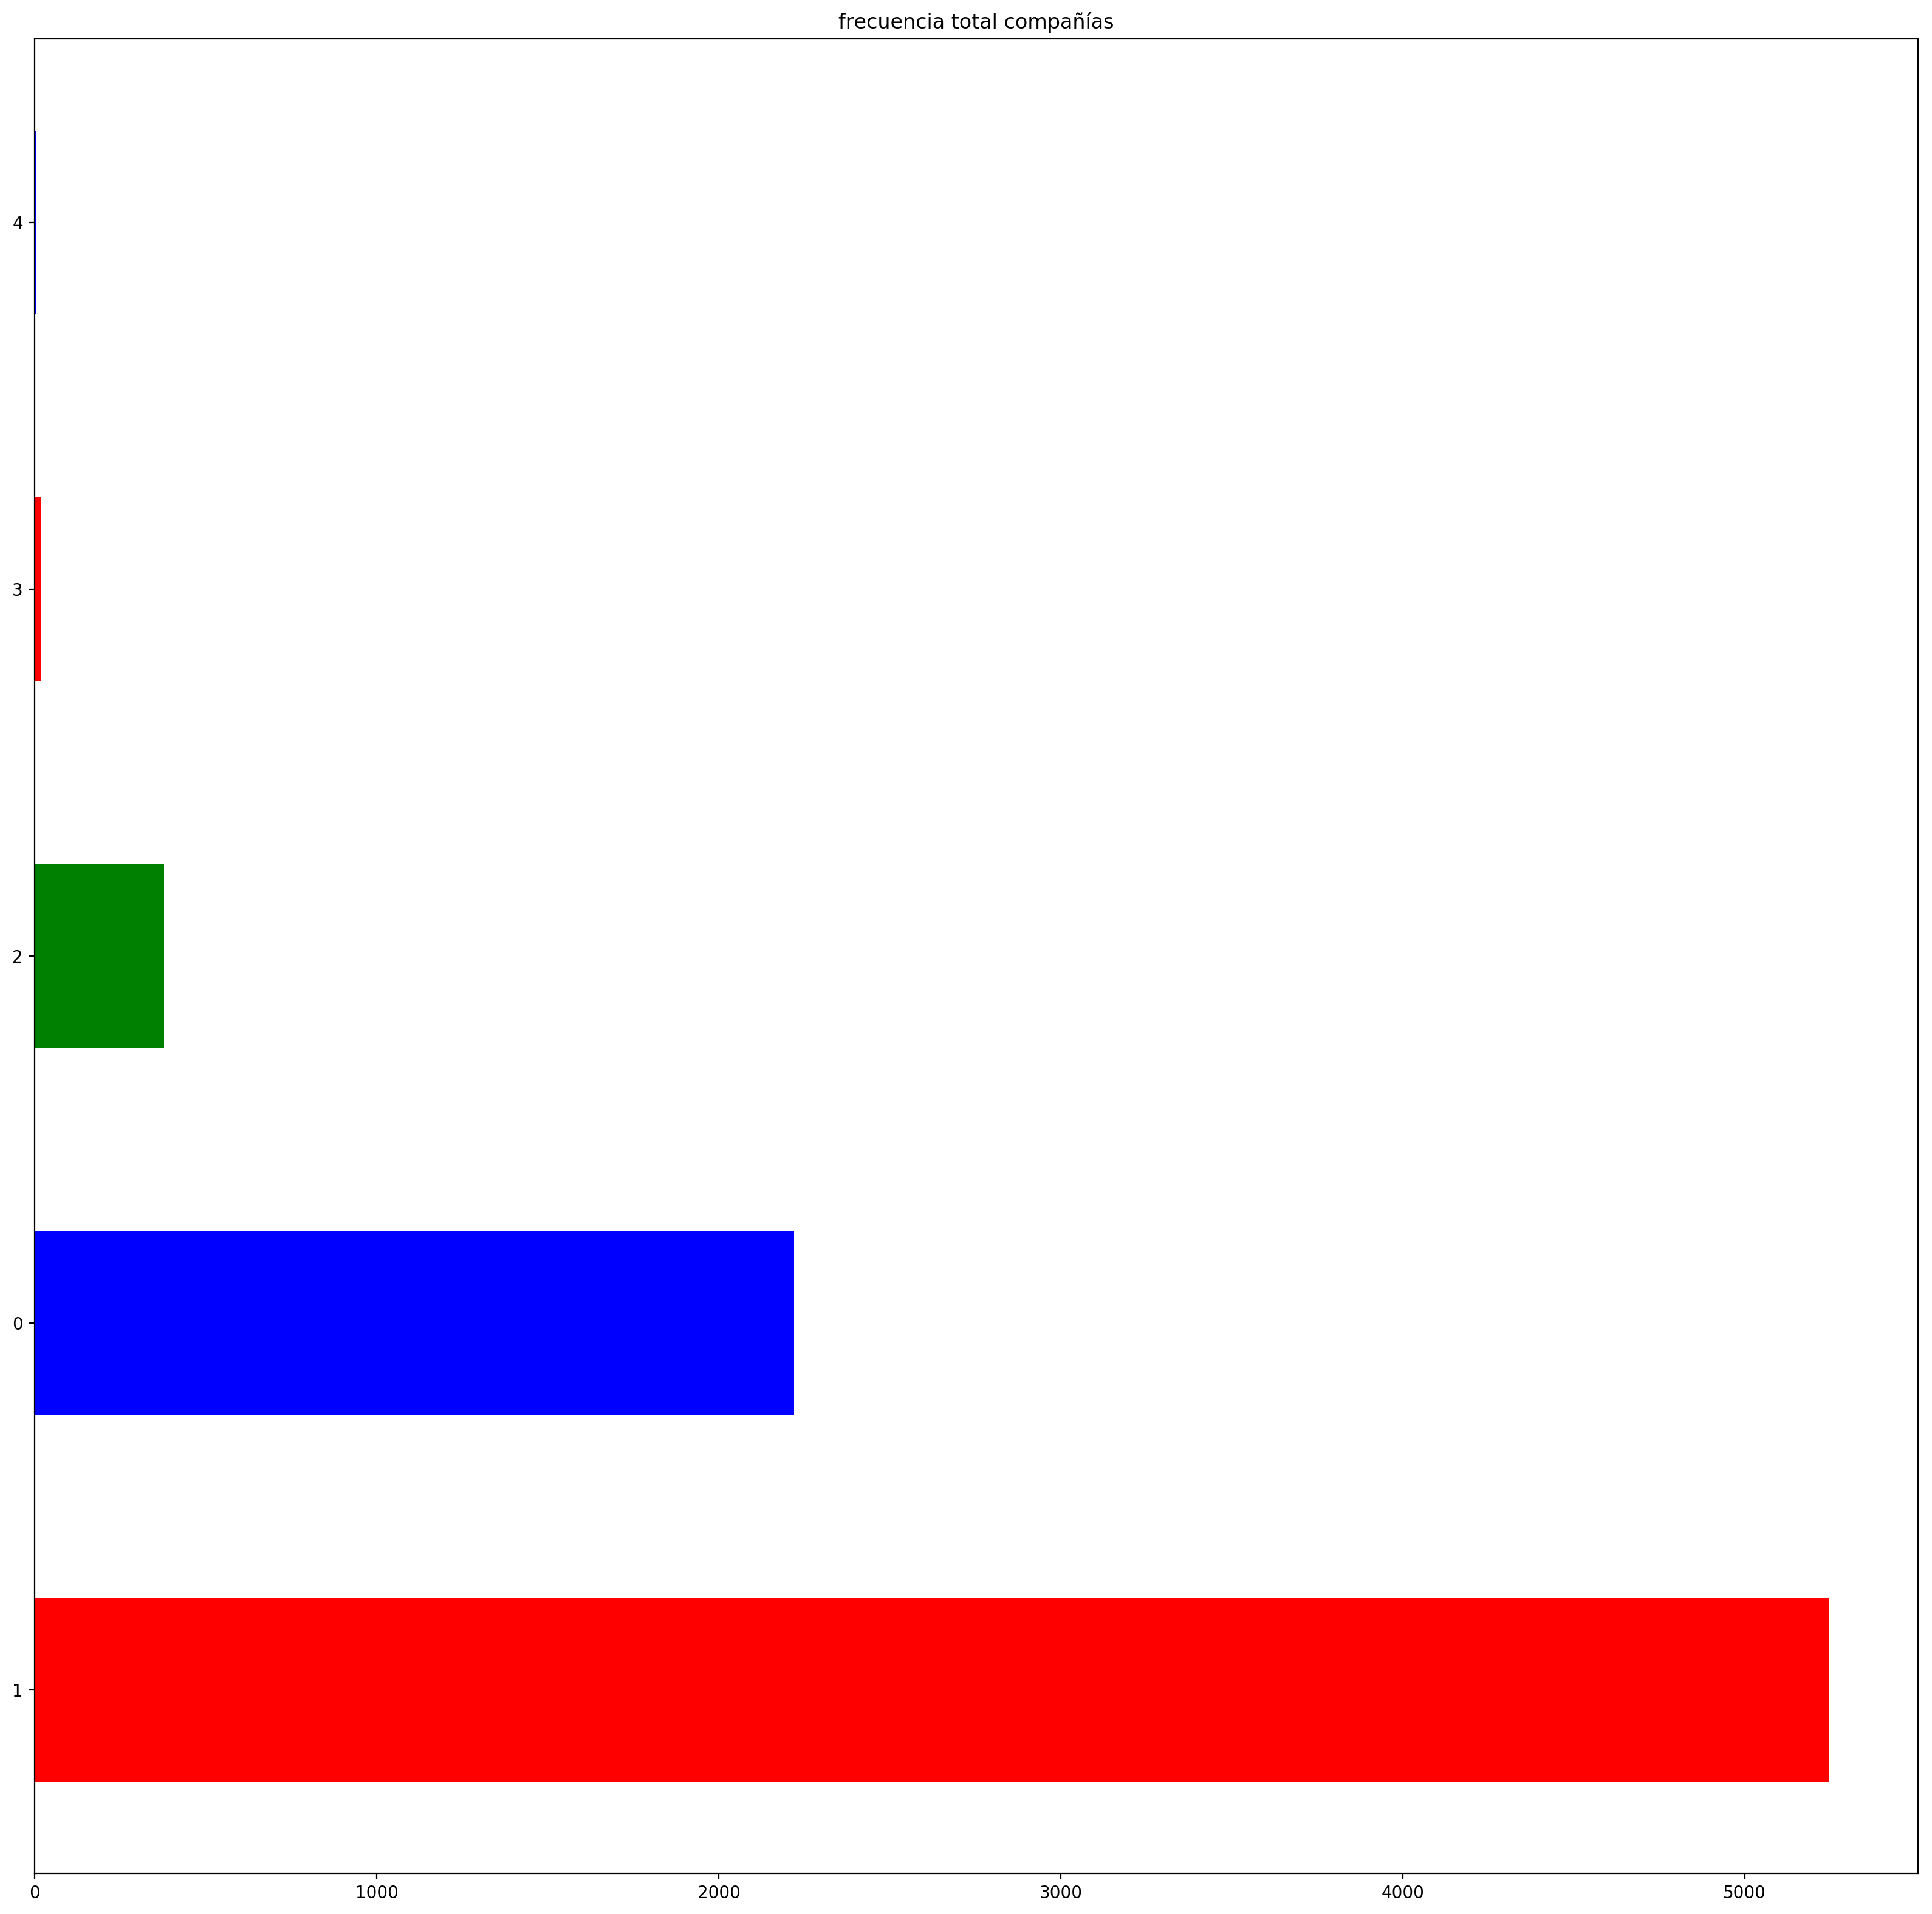

In [17]:
# CREAMOS NUEVA COLUMNA PARA VER CUANTAS AEROLINEAS SE MENCIONAN EN CADA TWEET

df['tot_cias']=df['iberia']+df['ryanair']+df['vueling']+df['otras_cias']
df['tot_cias'].value_counts().plot.barh(color='rbg',title='frecuencia total compañías')

In [20]:
# CREAMOS SUBSET DE AQUELLOS TWEETS EN QUE SE MENCIONA UNA SOLA COMPAÑÍA AÉREA

dfone=df[(df['tot_cias']==1) & (df['compania']!='')]
dfone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4884 entries, 926419989107798016 to 935546571663527936
Data columns (total 34 columns):
airline_sentiment    4884 non-null category
whole_tweet          4884 non-null object
emoticon             4884 non-null object
mentions             4884 non-null object
hashtags             4884 non-null object
airline              4884 non-null object
n_words              4884 non-null int64
n_words_mayus        4884 non-null int64
n_words_mayus_len    4884 non-null int64
n_suspensivos        4884 non-null int64
n_exclamations       4884 non-null int64
n_questions          4884 non-null int64
len_tw               4884 non-null int64
is_reply             4884 non-null int64
text                 4884 non-null object
tweet_coord          19 non-null object
tweet_created        4884 non-null datetime64[ns]
tweet_location       275 non-null category
user_timezone        4884 non-null category
weekday              4884 non-null int64
dayhour             

In [21]:
# BUSCAMOS ALGUNA RELACIÓN ENTRE COMPAÑÍA Y SENTIMIENTO

print(dfone.groupby(['compania','airline_sentiment']).size())

compania  airline_sentiment
iberia    negative             1472
          neutral              1109
          positive             675 
otras     negative             20  
          neutral              18  
          positive             8   
ryanair   negative             754 
          neutral              506 
          positive             295 
vueling   negative             16  
          neutral              7   
          positive             4   
dtype: int64


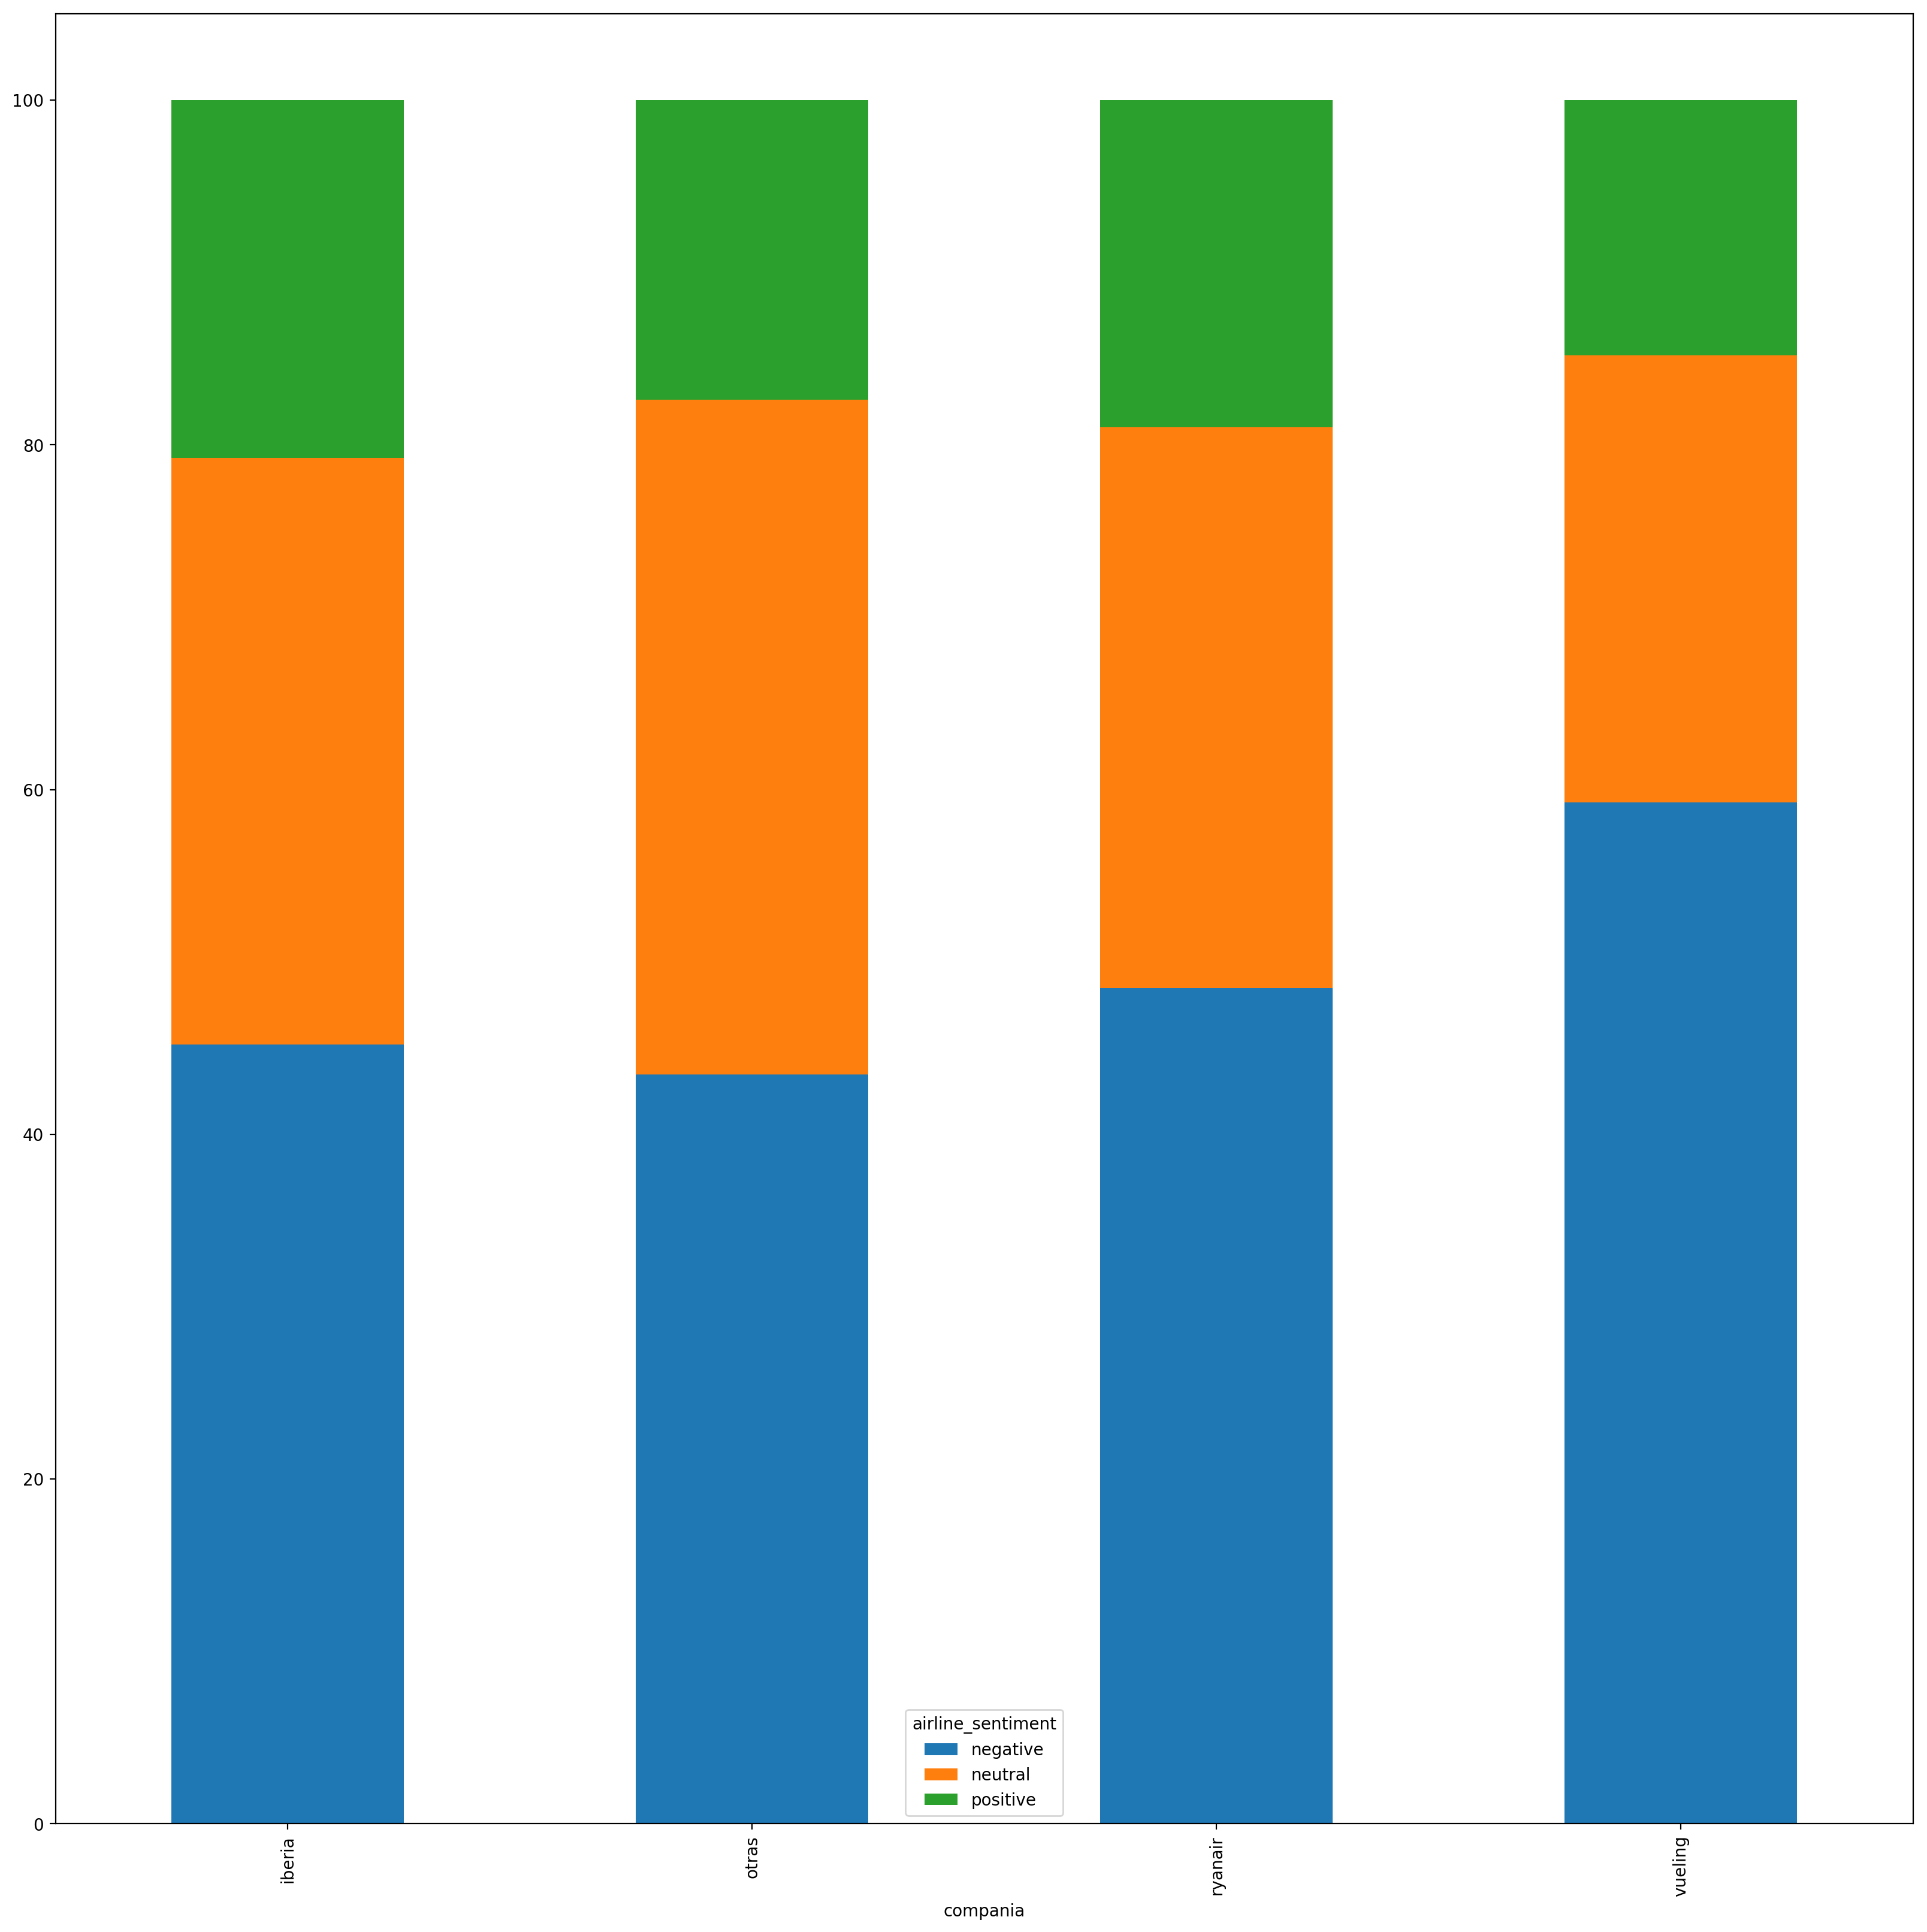

In [22]:
# MIRAMOS SI PASA COMO EN V.AMERICANA EN QUE CIAS CON MÁS TWEETS TIENEN MÁS NEGATIVOS,
# CIAS CON MENOS TWEETS, MÁS PROPORCIÓN POSITIVOS.PARECE QUE EL V.ESP NO VA EN LA MISMA
# LÍNEA: IBERIA ES LA QUE TIENE MÁS TWEETS Y LA QUE TB TIENE MÁS % POSITIVOS

pd.crosstab(index=dfone['compania'],columns=dfone['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

negative    0.463145
neutral     0.335790
positive    0.201065
Name: airline_sentiment, dtype: float64


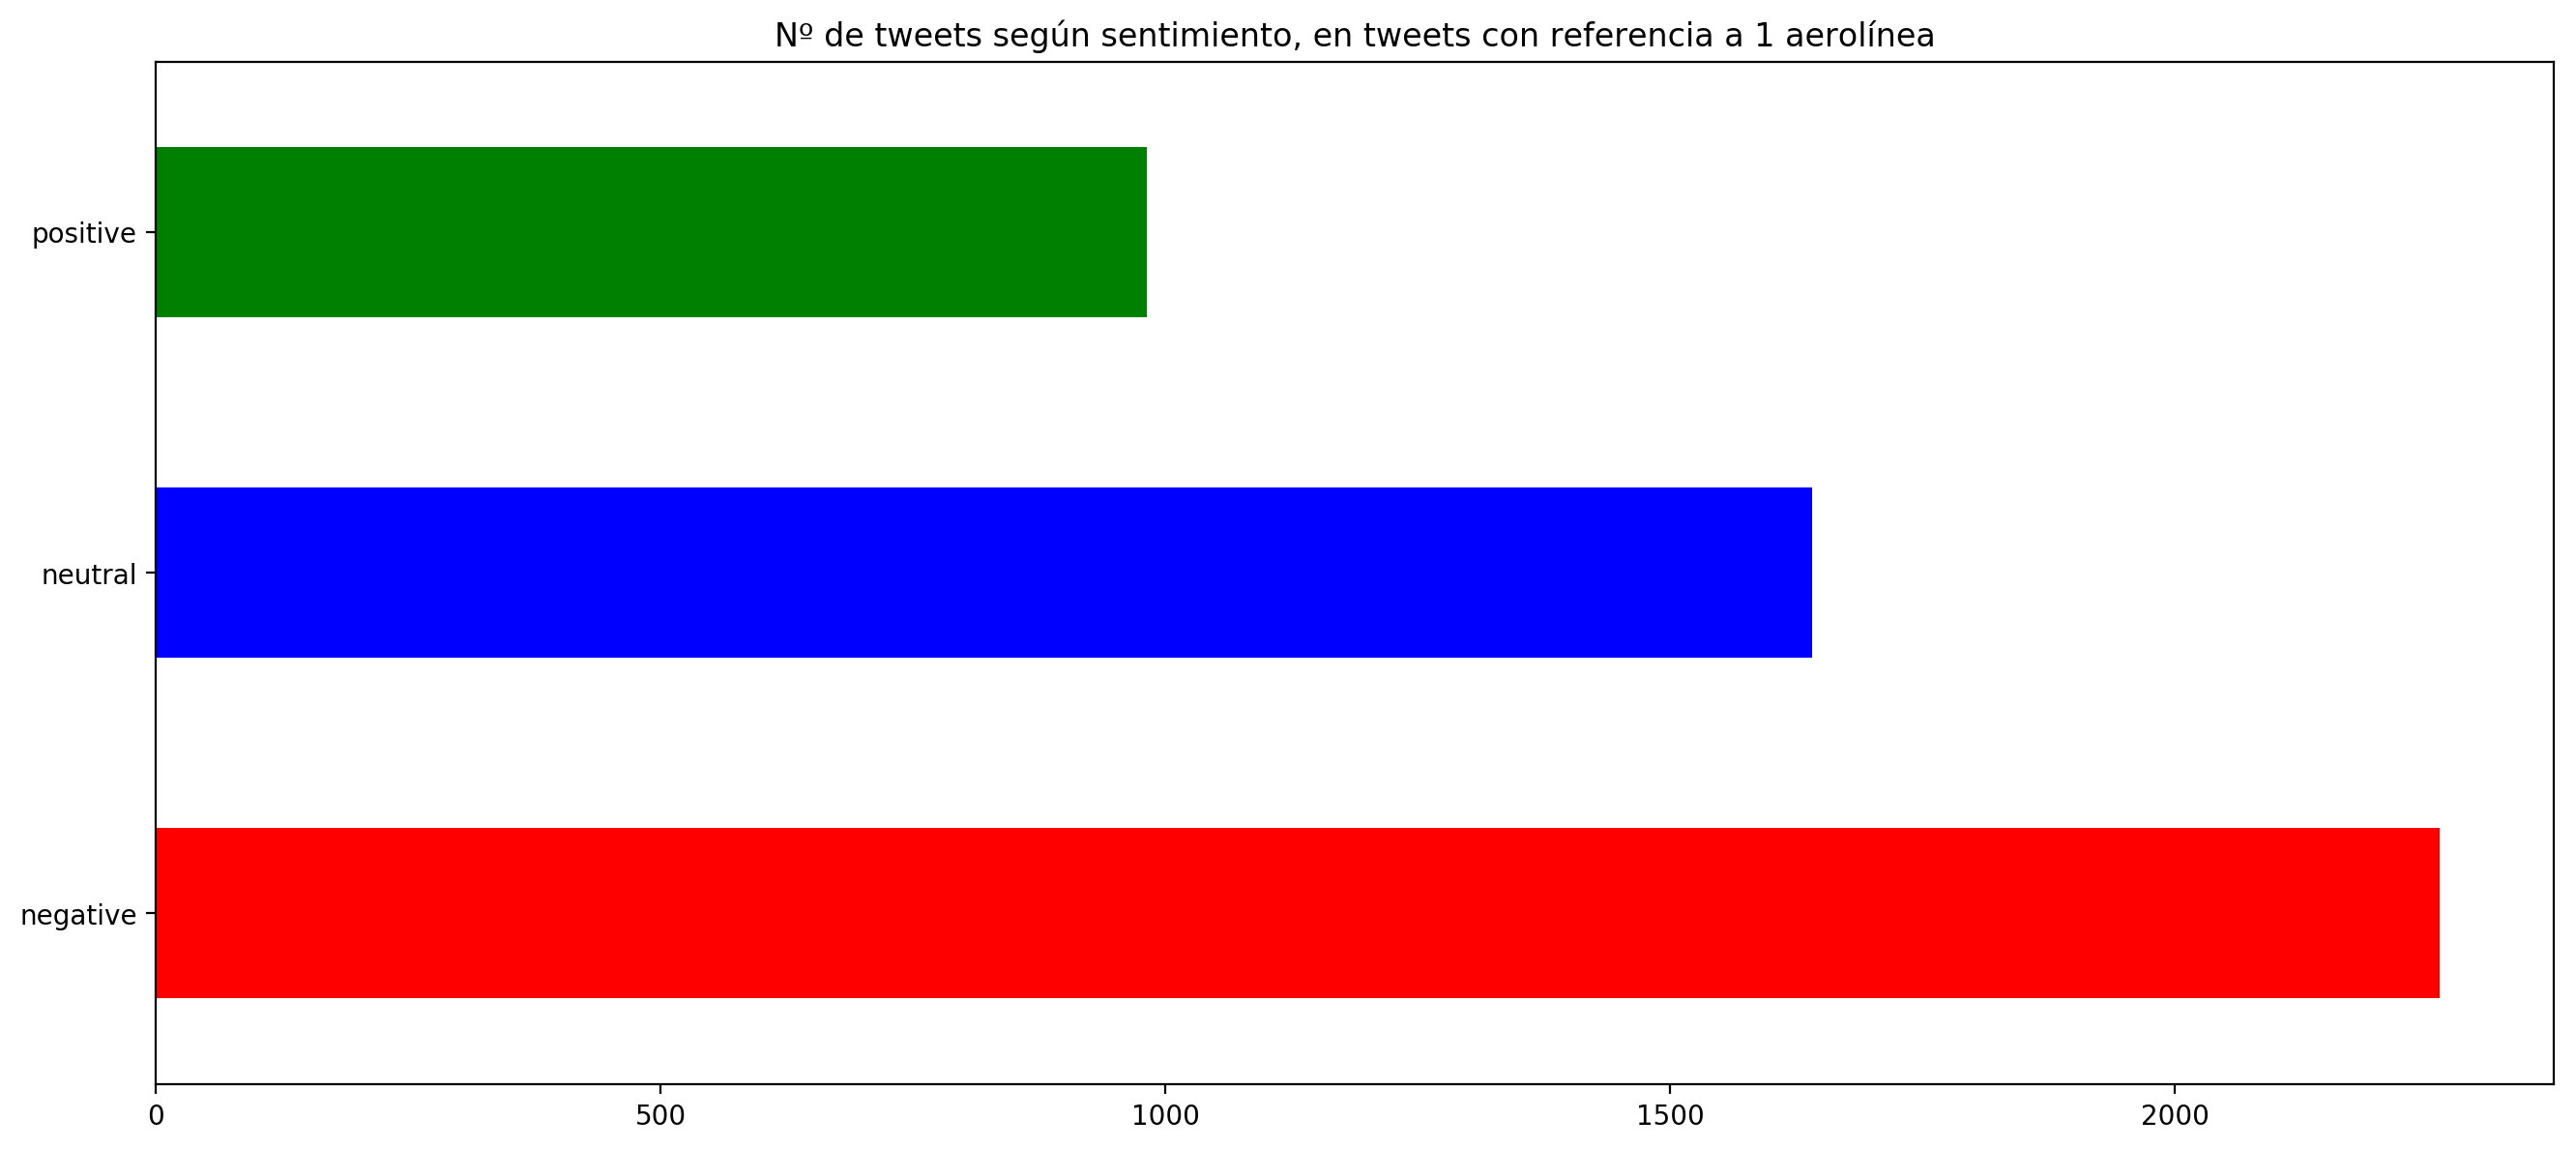

In [24]:
plt.rcParams['figure.figsize'] = (16, 7)
print(dfone['airline_sentiment'].value_counts()/dfone['tot_cias'].count())
dfone['airline_sentiment'].value_counts().plot.barh(color='rbg',title='Nº de tweets según sentimiento, en tweets con referencia a 1 aerolínea')

In [25]:
print('\nTabla contingencia, valores absolutos\n', pd.crosstab(index=df['iberia'],
            columns=df['airline_sentiment'], margins=True))

print('\nTabla contingencia, en %\n', pd.crosstab(index=df['iberia'],columns=df['airline_sentiment'],
            margins=True).apply(lambda r: r/len(df) *100,axis=1))

print('\nTabla contingencia, en %, lectura VERTICAL\n',pd.crosstab(index=df['iberia'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=0))

print('\nTabla contingencia, en %, lectura HORIZONTAL\n',pd.crosstab(index=df['iberia'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1))


Tabla contingencia, valores absolutos
 airline_sentiment  negative  neutral  positive   All
iberia                                              
0                  1907      1337     747       3991
1                  1862      1272     742       3876
All                3769      2609     1489      7867

Tabla contingencia, en %
 airline_sentiment   negative    neutral   positive         All
iberia                                                        
0                  24.240498  16.995043  9.495360   50.730901 
1                  23.668489  16.168806  9.431804   49.269099 
All                47.908987  33.163849  18.927164  100.000000

Tabla contingencia, en %, lectura VERTICAL
 airline_sentiment   negative    neutral   positive
iberia                                            
0                  50.596975  51.245688  50.167898
1                  49.403025  48.754312  49.832102

Tabla contingencia, en %, lectura HORIZONTAL
 airline_sentiment   negative    neutral   positive
iberia

In [26]:
# TABLA DE CONTINGENCIA SOBRE % HORIZONTAL, SEGÚN COMPAÑÍA
pd.crosstab(index=df['ryanair'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=0)

airline_sentiment,negative,neutral,positive
ryanair,,,
0,77.474131,77.807589,78.307589
1,22.525869,22.192411,21.692411


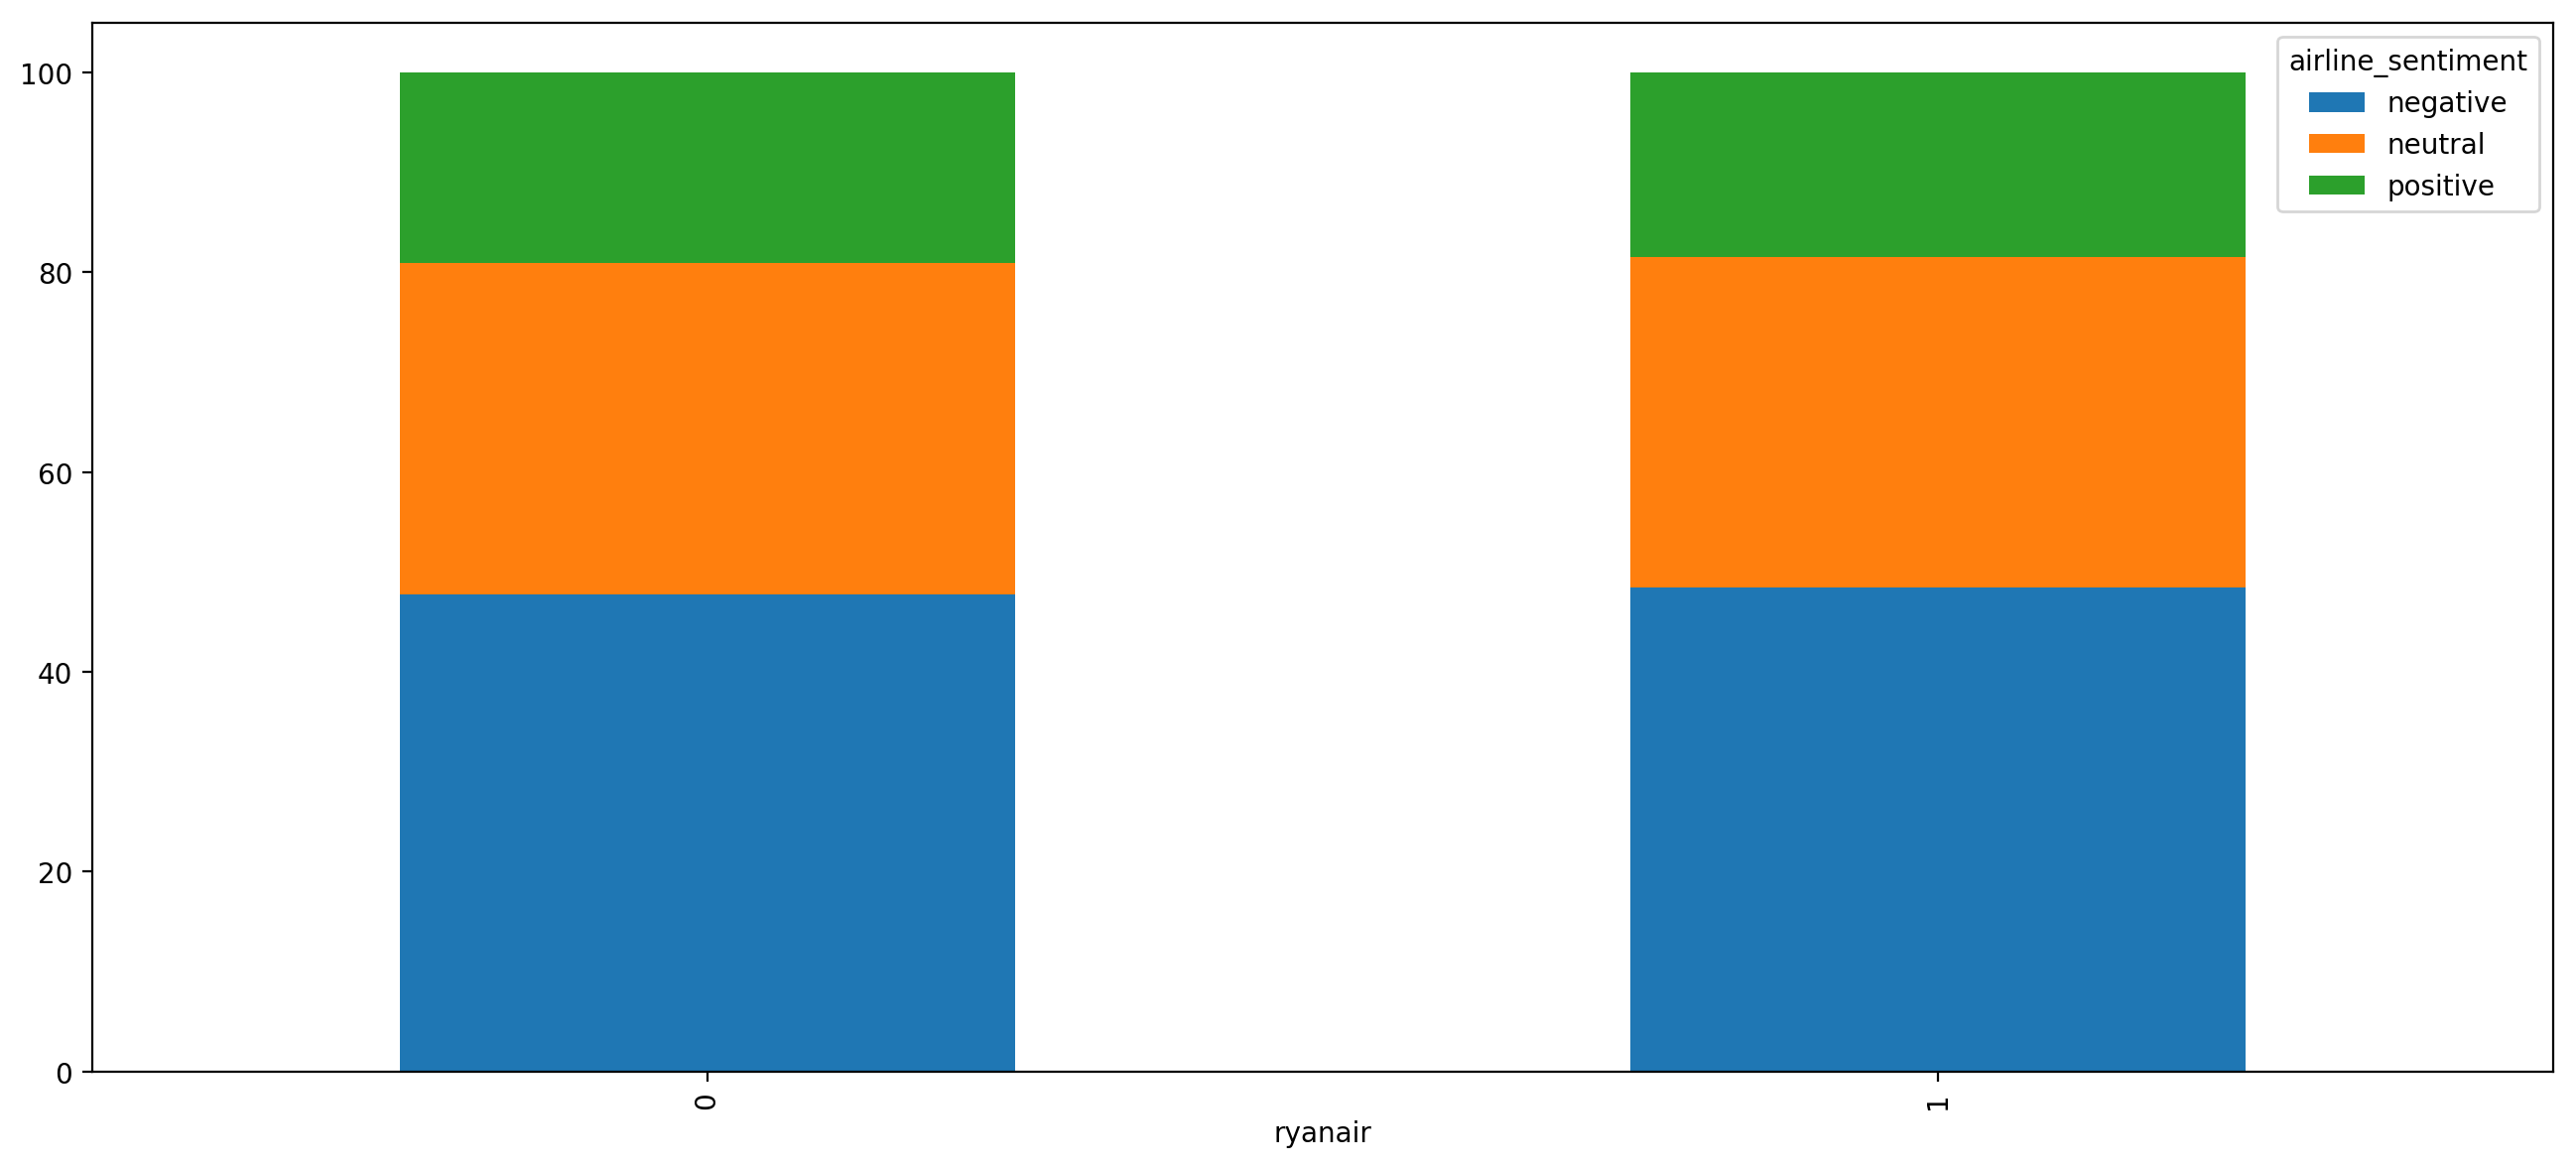

In [27]:
pd.crosstab(index=df['ryanair'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

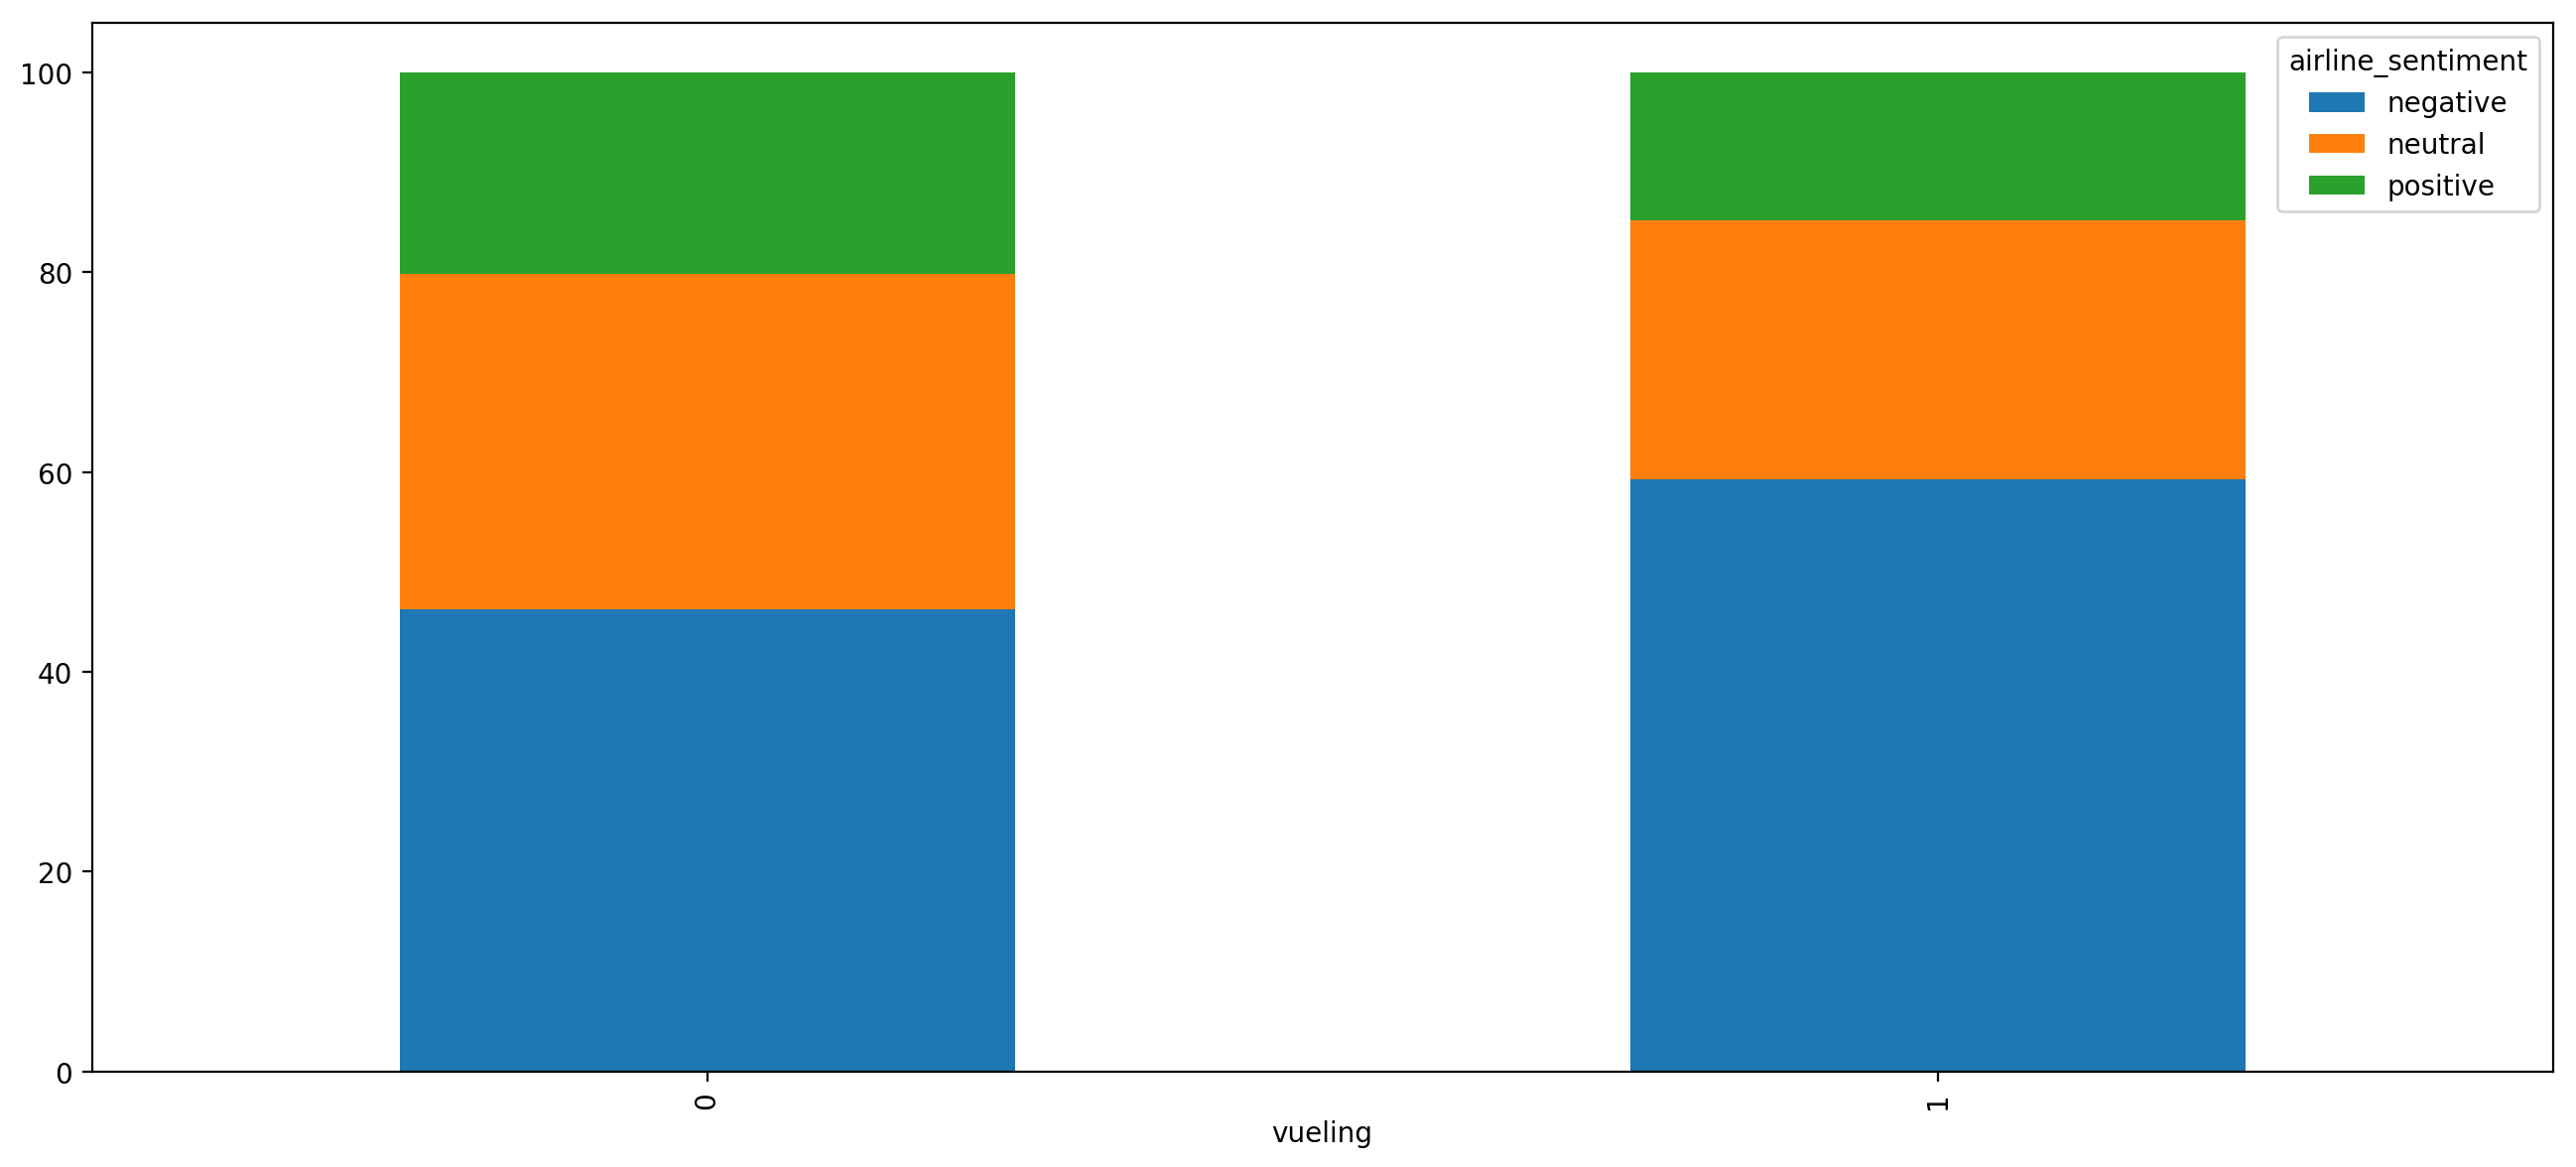

In [28]:
pd.crosstab(index=dfone['vueling'],columns=dfone['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Análisis IS_REPLY

In [29]:
# BÚSQUEDA DE RELACIÓN ENTRE SENTIMIENTO Y IS_REPLY

contingencia_abs=pd.crosstab(index=df['airline_sentiment'],
            columns=df['is_reply'], margins=True)
contingencia_rel=pd.crosstab(index=df['airline_sentiment'],columns=df['is_reply'],
            margins=True).apply(lambda r: r/len(df) *100,axis=1)
print('Tabla de contingencia, valores absolutos','\n'*2, contingencia_abs,'\n')
print('Tabla de contingencia, en %','\n'*2, contingencia_rel)

Tabla de contingencia, valores absolutos 

 is_reply              0     1   All
airline_sentiment                  
negative           1720  2049  3769
neutral            1477  1132  2609
positive           930   559   1489
All                4127  3740  7867 

Tabla de contingencia, en % 

 is_reply                   0          1         All
airline_sentiment                                  
negative           21.863480  26.045507  47.908987 
neutral            18.774628  14.389221  33.163849 
positive           11.821533  7.105631   18.927164 
All                52.459642  47.540358  100.000000


In [31]:
# TABLA DE CONTINGENCIA SOBRE % HORIZONTAL, SEGÚN is_reply
print('Horizontal:\n',pd.crosstab(index=df['airline_sentiment'],columns=df['is_reply']
           ).apply(lambda r: r/r.sum() *100,axis=1))

# TABLA DE CONTINGENCIA SOBRE % VERTICAL, SEGÚN SENTIMIENTO
print('Vertical:\n',pd.crosstab(index=df['airline_sentiment'],columns=df['is_reply']
           ).apply(lambda r: r/r.sum() *100,axis=0))

# ENTRE LOS NEGATIVOS, LOS FALSE_ISREPLY ESTÁN POR DEBAJO DE LA MEDIA,
# LOS TRUE_ISREPLY POR ENCIMA; ES COMPORTAMIENTO CONTRARIO A LOS NEUTRALES Y POSITIVOS (POSITIVO MÁS POLARIZADO)

Horizontal:
 is_reply                   0          1
airline_sentiment                      
negative           45.635447  54.364553
neutral            56.611729  43.388271
positive           62.458026  37.541974
Vertical:
 is_reply                   0          1
airline_sentiment                      
negative           41.676763  54.786096
neutral            35.788709  30.267380
positive           22.534529  14.946524


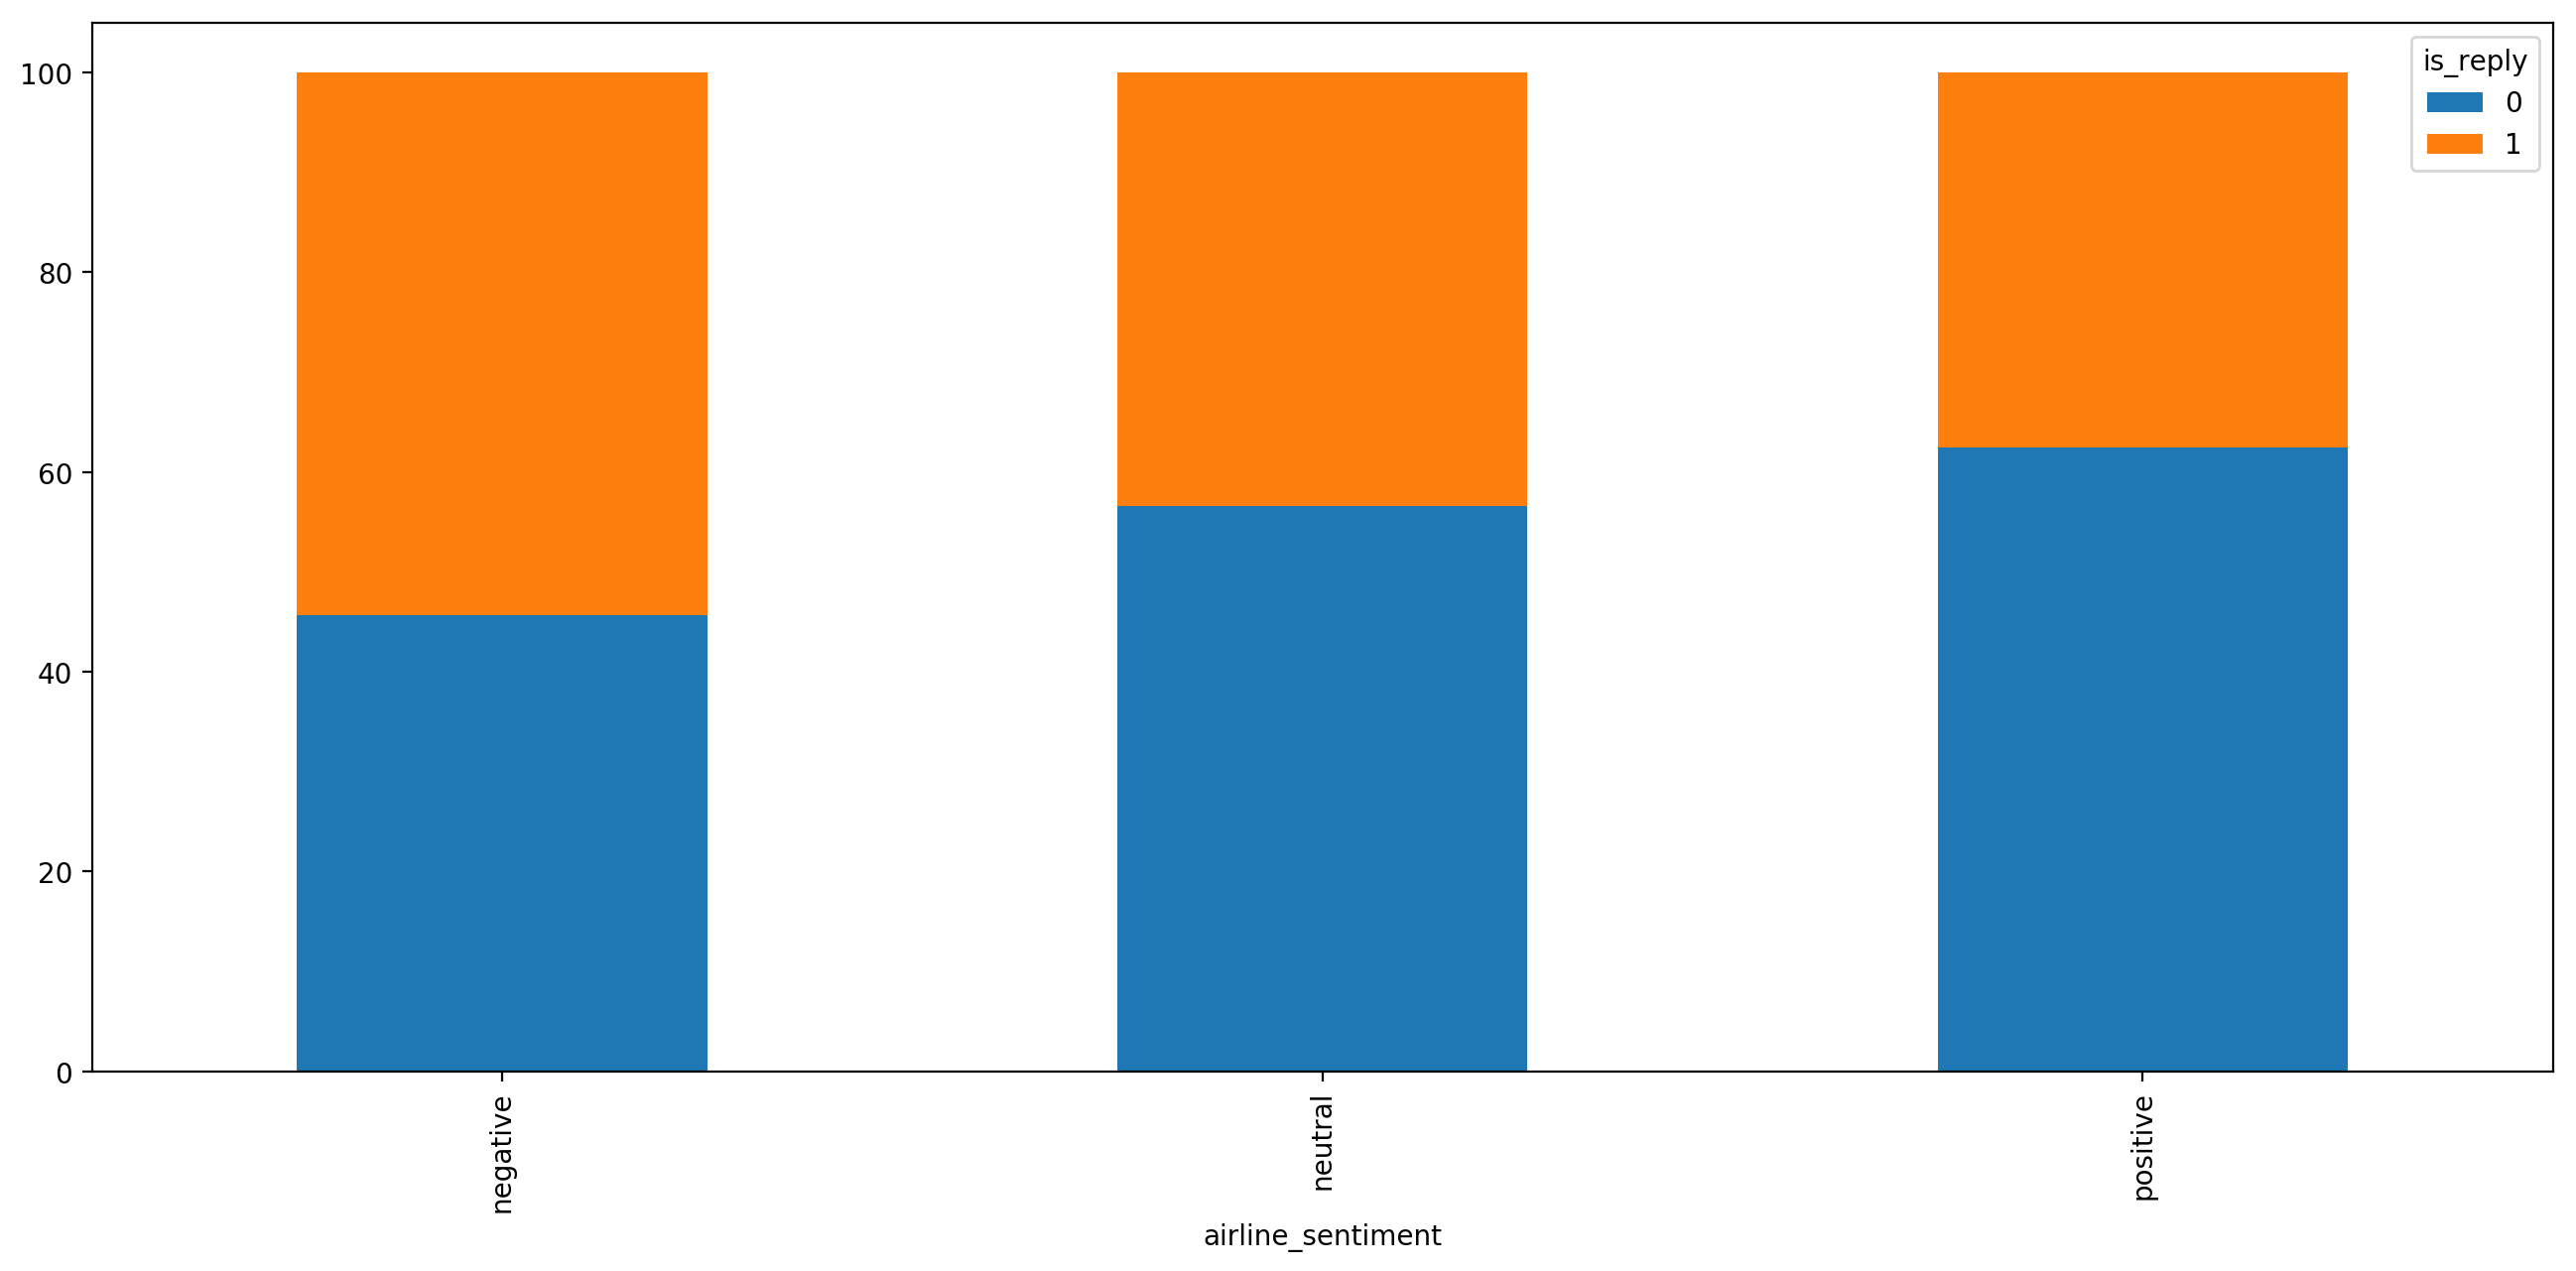

In [32]:
pd.crosstab(index=df['airline_sentiment'],columns=df['is_reply']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

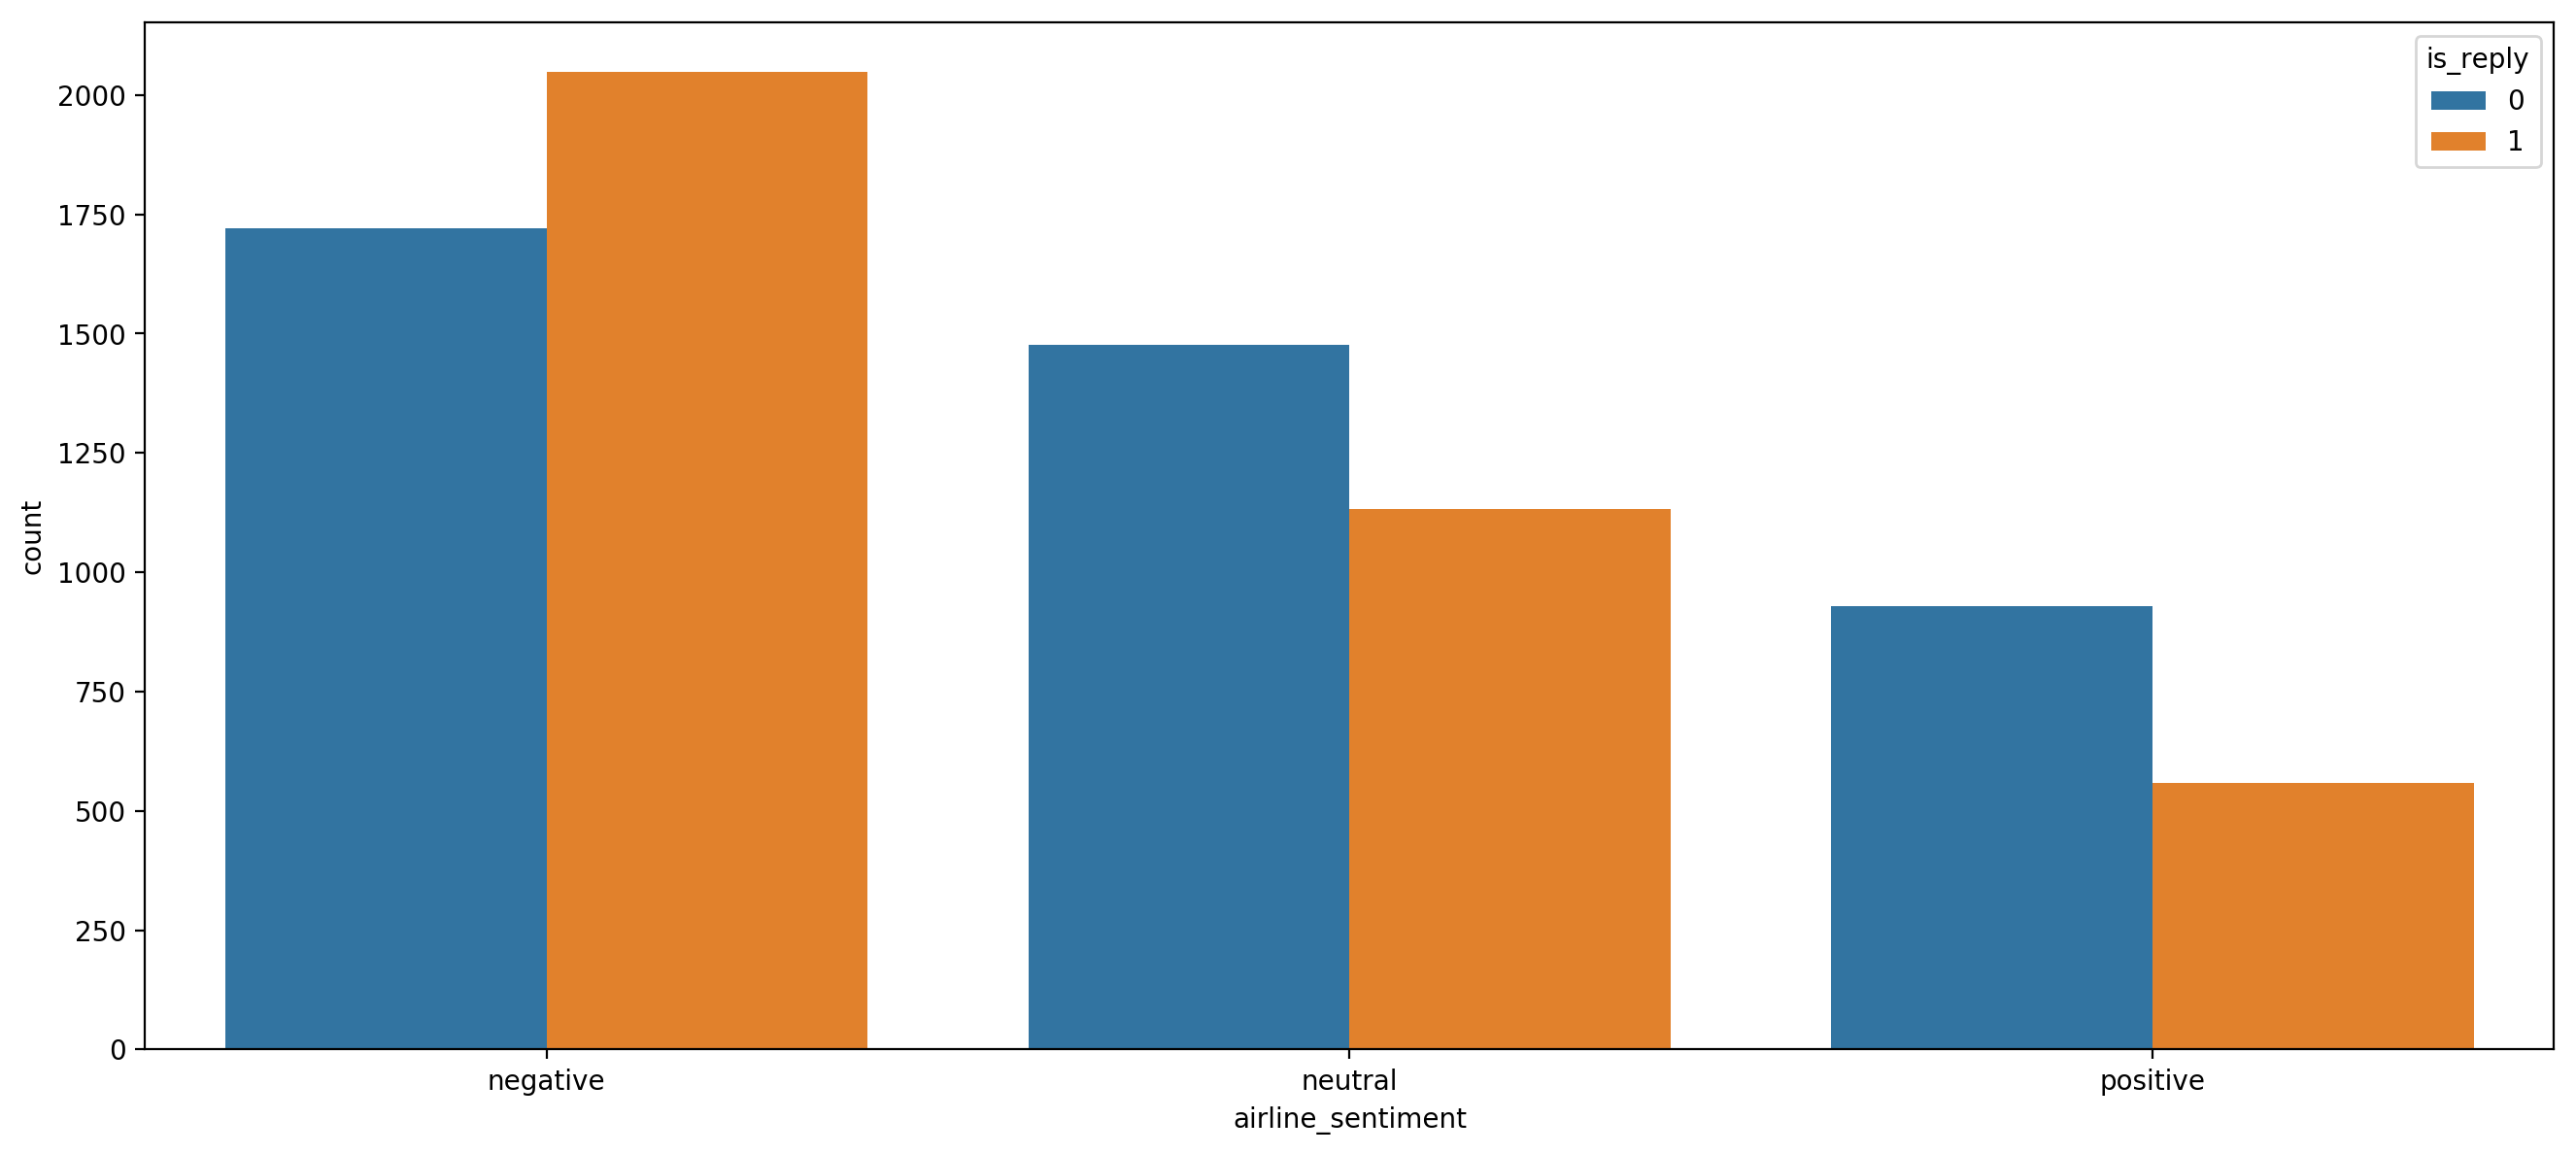

In [30]:
ax = sns.countplot(x="airline_sentiment", hue="is_reply", data=df)

## Análisis DÍA DE LA SEMANA/FIN DE SEMANA

In [33]:
# BÚSQUEDA DE RELACIÓN ENTRE SENTIMIENTO Y DÍA DE LA SEMANA

print('\nTabla contingencia, valores absolutos\n', pd.crosstab(index=df['weekday'],
            columns=df['airline_sentiment'], margins=True))

print('\nTabla contingencia, en %\n', pd.crosstab(index=df['weekday'],columns=df['airline_sentiment'],
            margins=True).apply(lambda r: r/len(df) *100,axis=1))

print('\nTabla contingencia, en %, lectura VERTICAL\n',pd.crosstab(index=df['weekday'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,
                                axis=0))

print('\nTabla contingencia, en %, lectura HORIZONTAL\n',pd.crosstab(index=df['weekday'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,
                                axis=1))

# conclusión: los días laborables hay más tweets que los festivos. En cambio, proporcionalmente, 
# los días festivos hay más proporción de tweets negativos que entre semana


Tabla contingencia, valores absolutos
 airline_sentiment  negative  neutral  positive   All
weekday                                             
0                  559       408      242       1209
1                  690       481      326       1497
2                  690       383      229       1302
3                  678       521      301       1500
4                  554       473      200       1227
5                  302       171      107       580 
6                  296       172      84        552 
All                3769      2609     1489      7867

Tabla contingencia, en %
 airline_sentiment   negative    neutral   positive         All
weekday                                                       
0                  7.105631   5.186221   3.076141   15.367993 
1                  8.770815   6.114148   4.143892   19.028855 
2                  8.770815   4.868438   2.910894   16.550146 
3                  8.618279   6.622601   3.826109   19.066989 
4                  7.0420

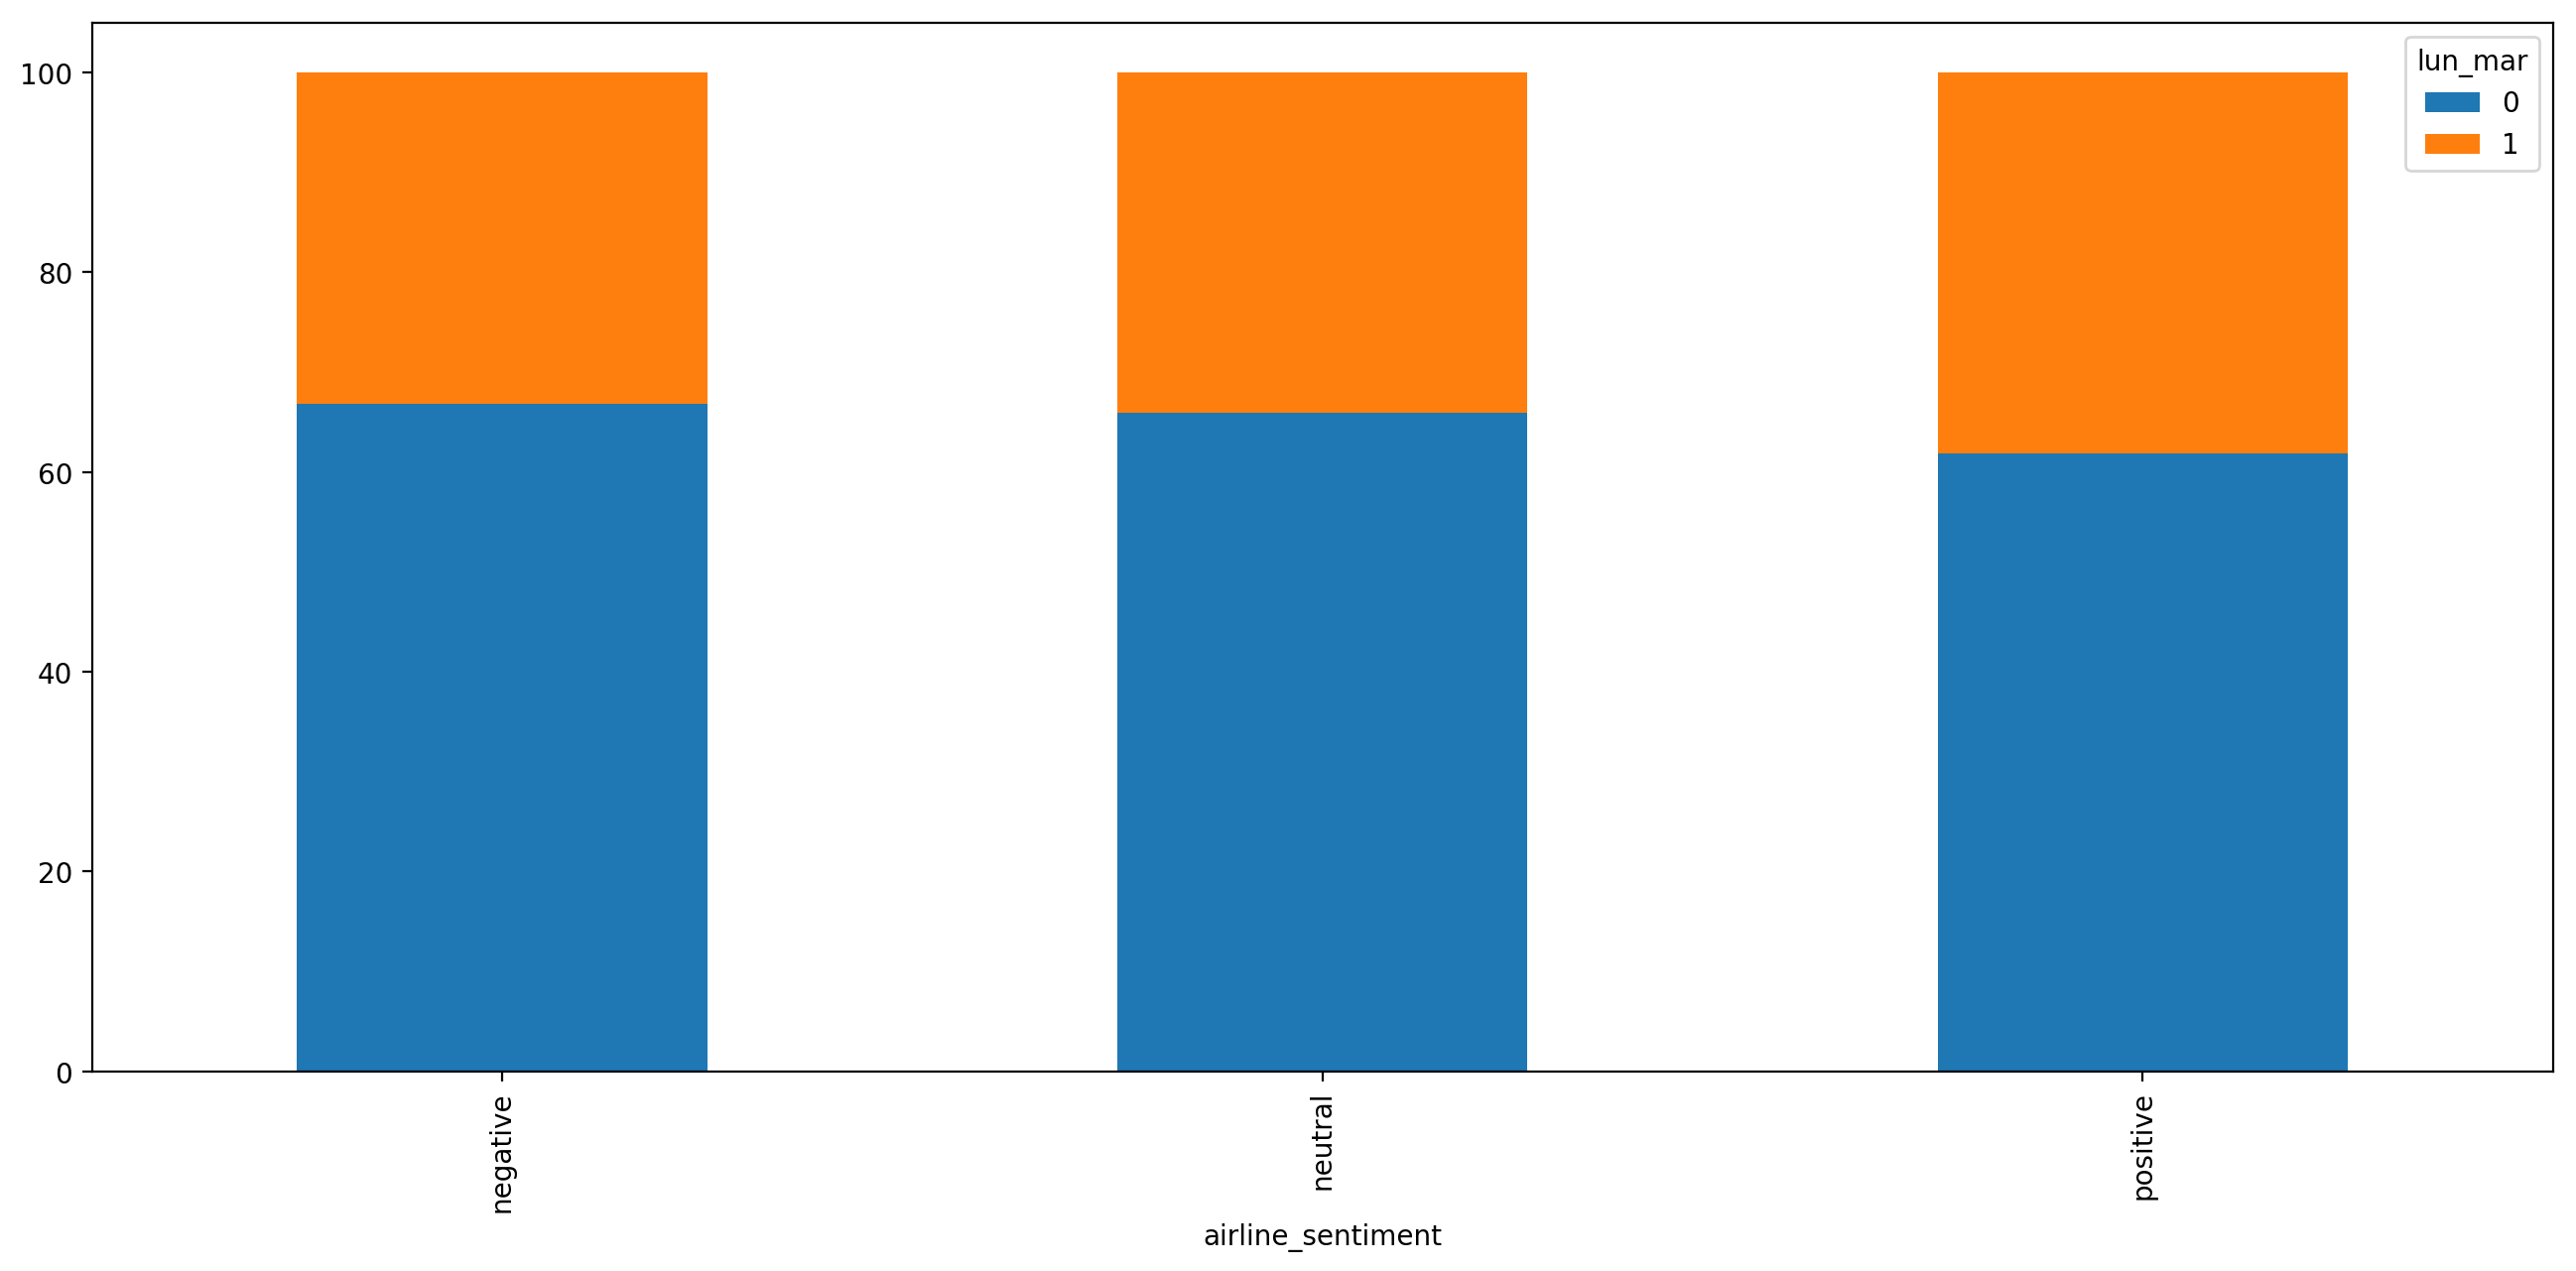

In [34]:
pd.crosstab(index=df['airline_sentiment'],columns=df['lun_mar']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

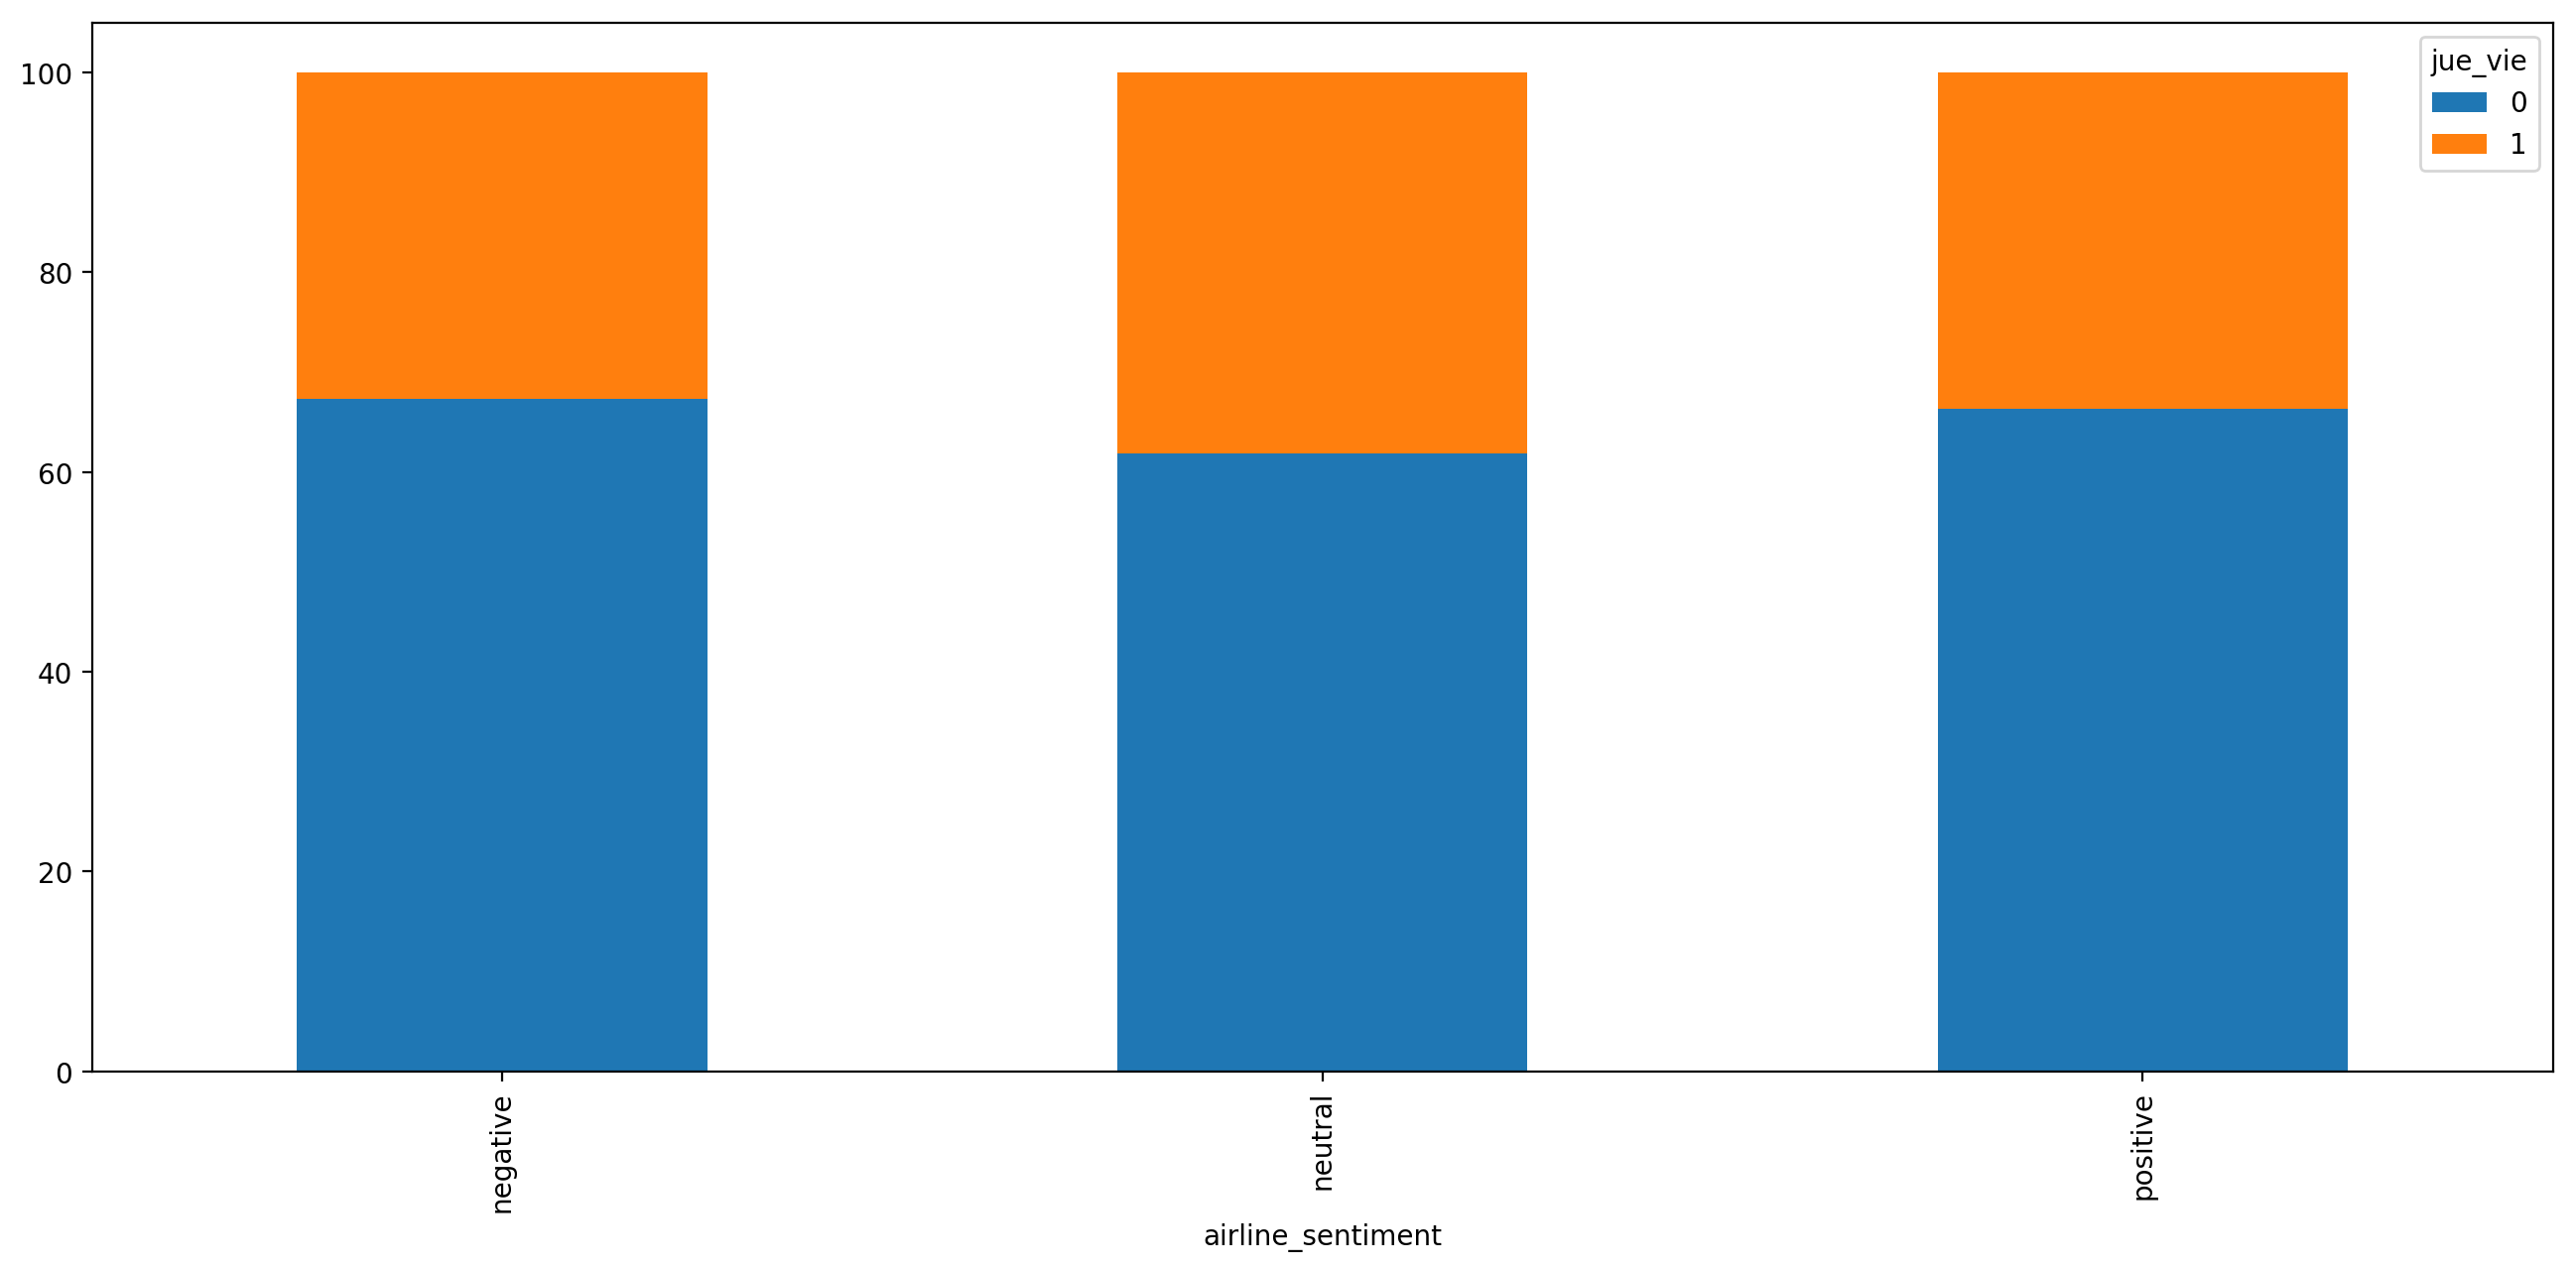

In [35]:
pd.crosstab(index=df['airline_sentiment'],columns=df['jue_vie']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

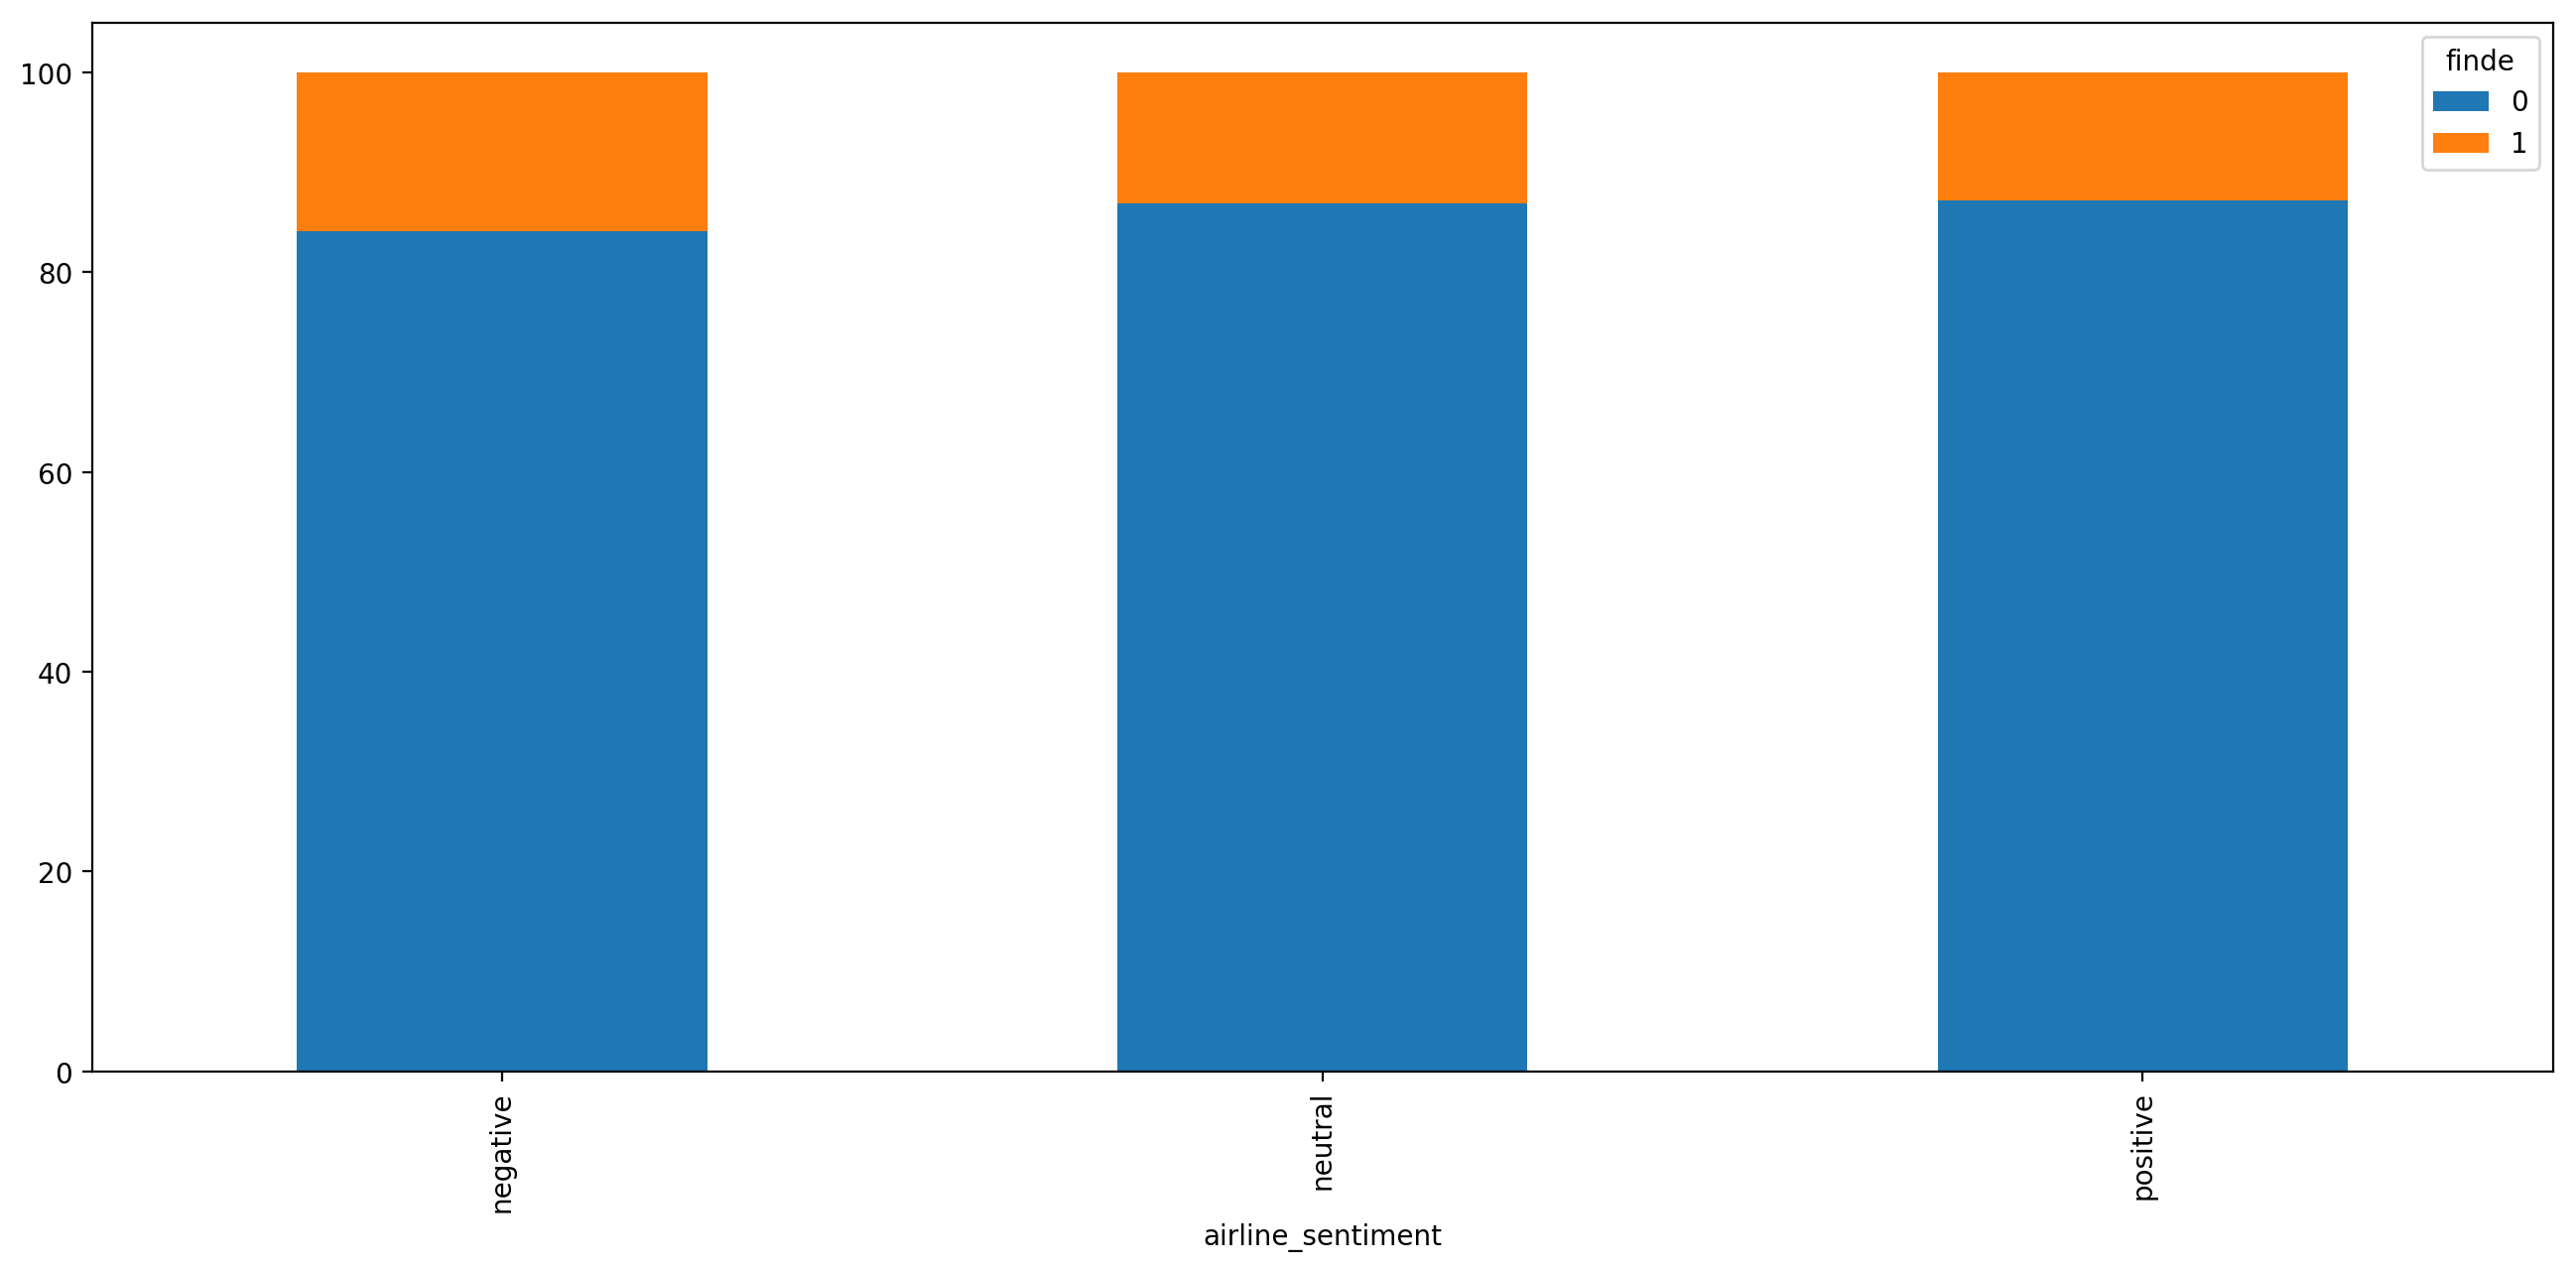

In [36]:
pd.crosstab(index=df['airline_sentiment'],columns=df['finde']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Análisis HORA DEL DÍA/VESPRES

In [39]:
# Force the index to be the creation date
df_by_date = df.set_index('tweet_created')
# Select only airline_sentiment
df_date_sent = df_by_date[['airline_sentiment']]
sent_onehot = pd.get_dummies(df_date_sent['airline_sentiment'])

# Replace the categorial column with the one-hot encoding
df_date_sent = pd.concat((df_date_sent, sent_onehot)).drop('airline_sentiment', axis=1)

#df_date_sent['total'] = df_date_sent['negative'] + df_date_sent['positive'] + df_date_sent['neutral']

# Resample el dataset a horas
df_date_sent= df_date_sent.resample('H').sum()

# Hay muchas horas en que no hay tweets, así que pasamos los NaN a ceros.
df_date_sent = df_date_sent.replace(np.nan, 0)
print(df_date_sent.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1810 entries, 2017-10-25 10:00:00 to 2018-01-08 19:00:00
Freq: H
Data columns (total 3 columns):
negative    1810 non-null float64
neutral     1810 non-null float64
positive    1810 non-null float64
dtypes: float64(3)
memory usage: 56.6 KB
None


                     negative  neutral  positive
tweet_created                                   
2017-10-25 10:00:00  10.0      7.0      2.0     
2017-10-25 11:00:00  3.0       3.0      4.0     
2017-10-25 12:00:00  5.0       1.0      6.0     
2017-10-25 13:00:00  5.0       8.0      2.0     
2017-10-25 14:00:00  2.0       4.0      2.0     
2017-10-25 15:00:00  3.0       4.0      1.0     
2017-10-25 16:00:00  10.0      7.0      2.0     
2017-10-25 17:00:00  6.0       5.0      1.0     
2017-10-25 18:00:00  6.0       7.0      3.0     
2017-10-25 19:00:00  7.0       2.0      1.0     
2017-10-25 20:00:00  1.0       2.0      5.0     
2017-10-25 21:00:00  2.0       1.0      0.0     
2017-10-25 22:00:00  3.0       2.0      0.0     
2017-10-25 23:00:00  2.0       3.0      1.0     
2017-10-26 00:00:00  3.0       0.0      0.0     
2017-10-26 01:00:00  0.0       0.0      0.0     
2017-10-26 02:00:00  0.0       1.0      1.0     
2017-10-26 03:00:00  0.0       0.0      0.0     
2017-10-26 04:00:00 

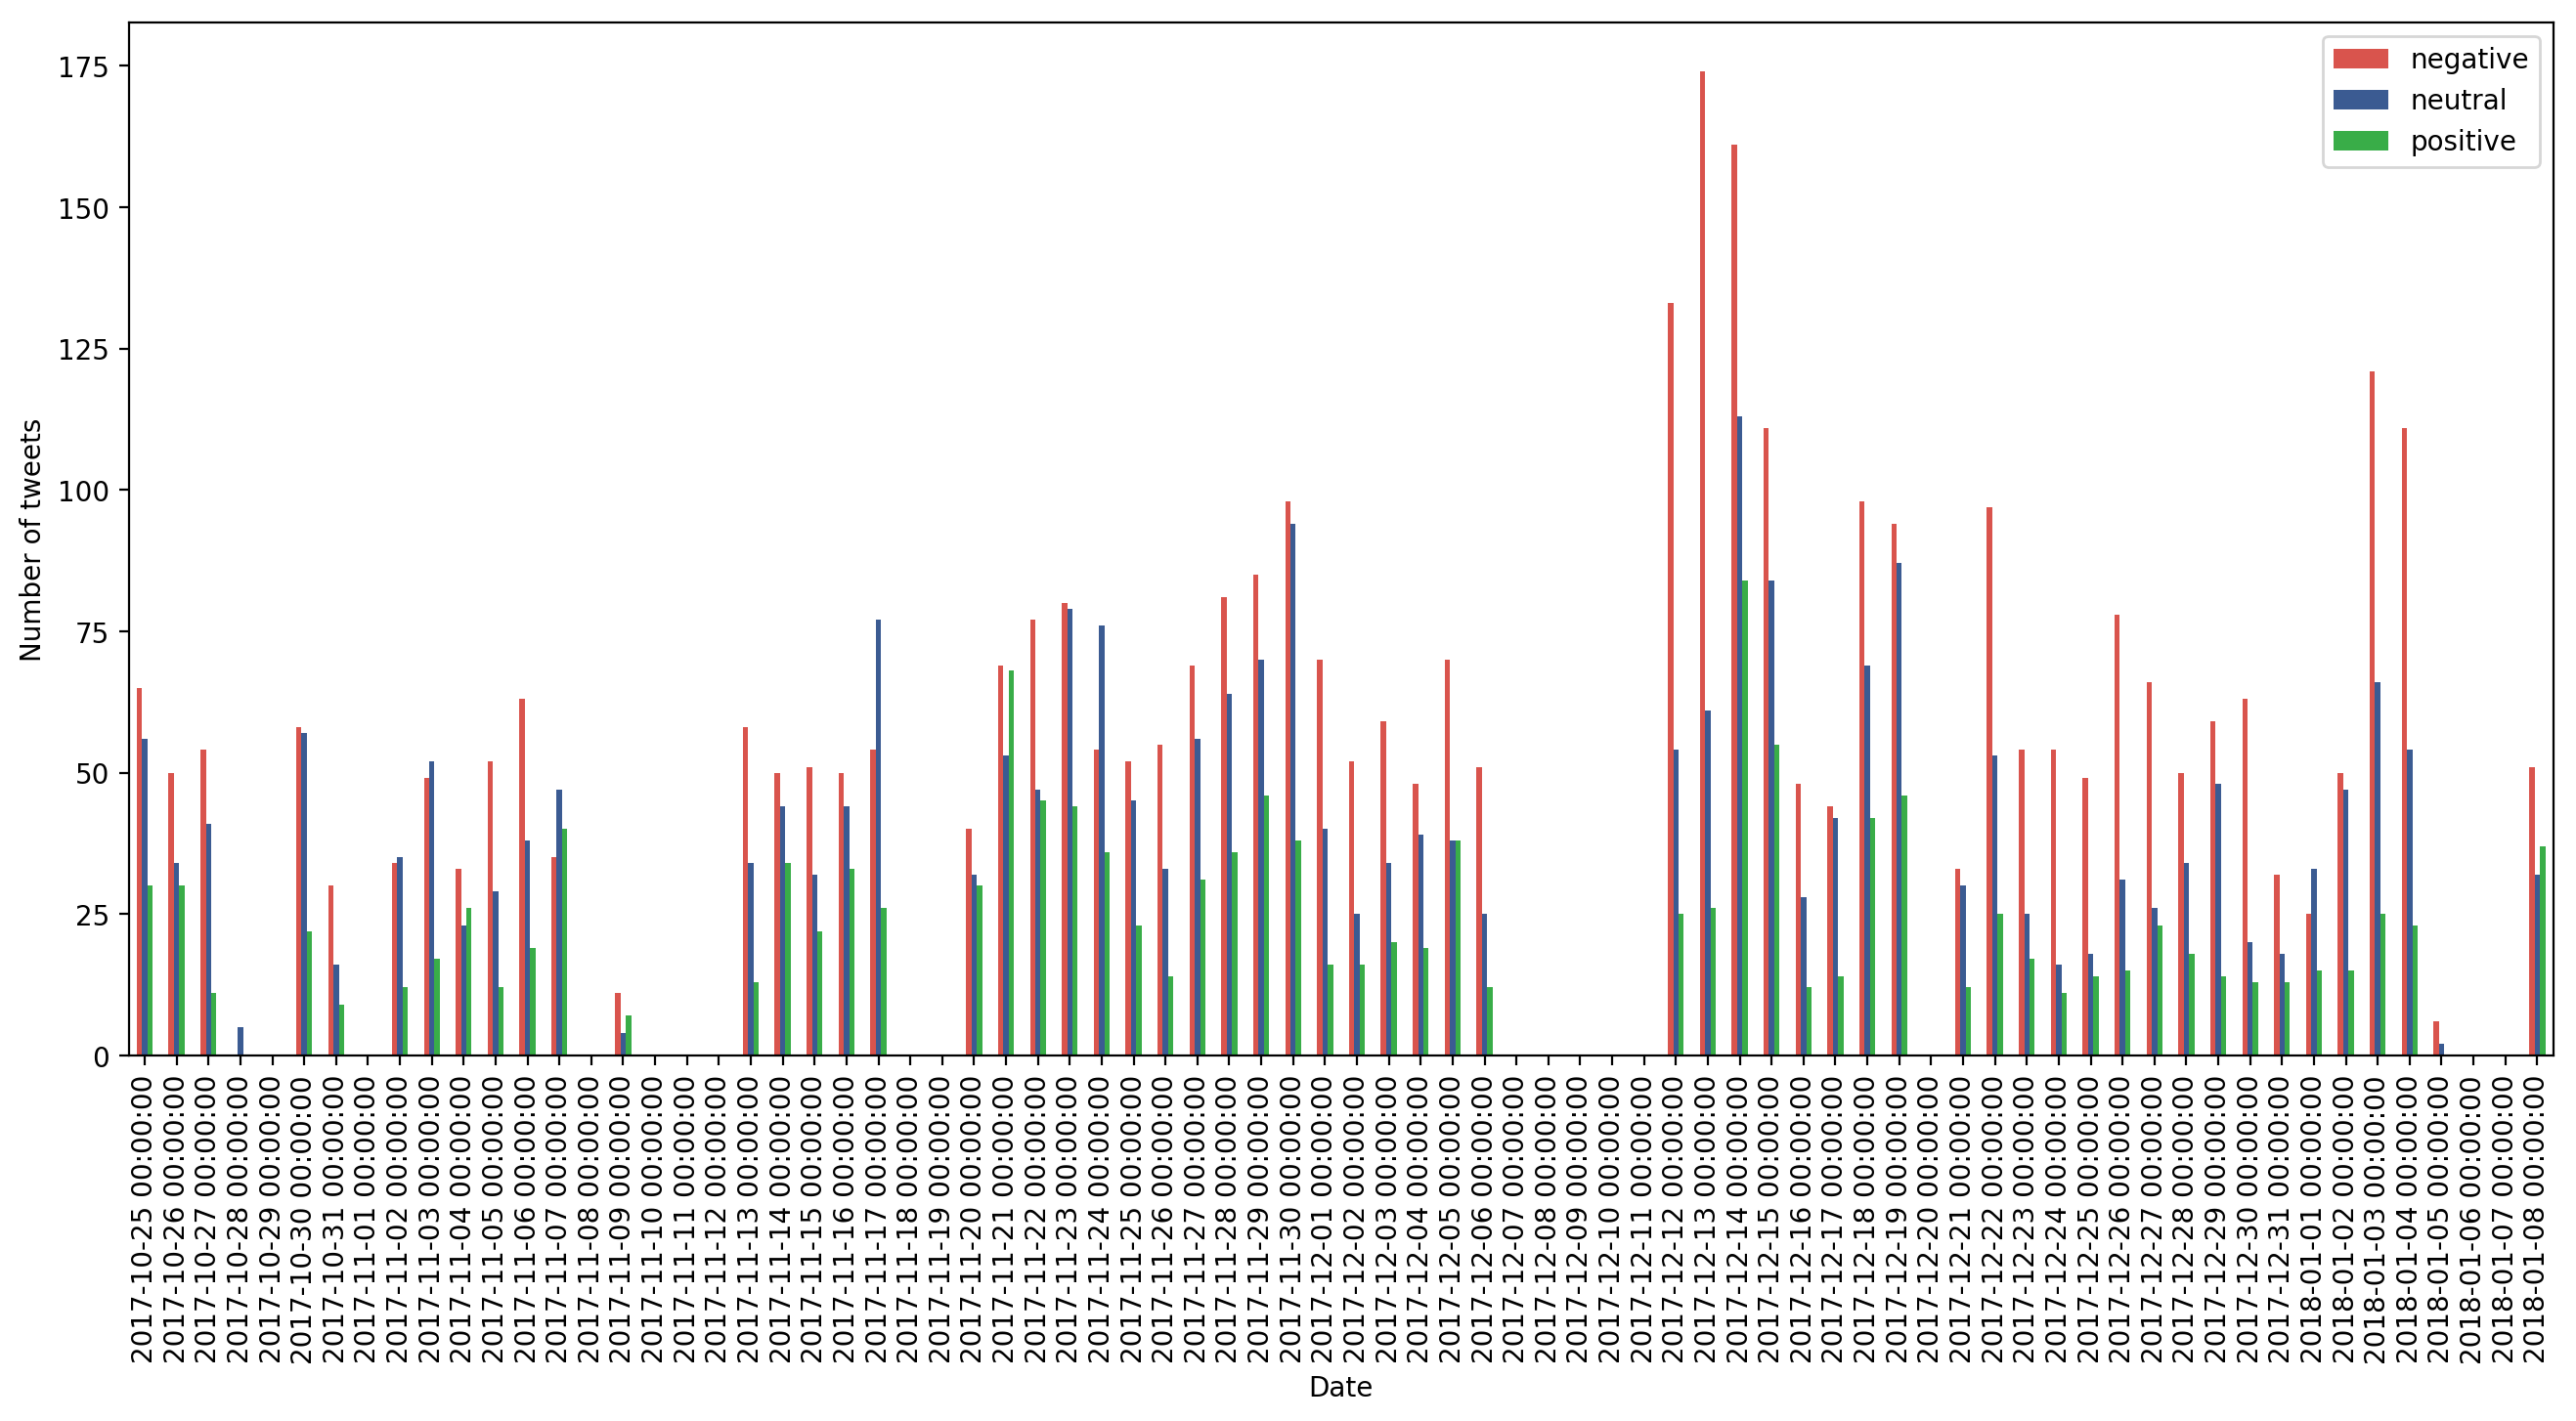

In [40]:
# Group by days and perform the sum per column, that is,
# accumulate on each sentiment-colunm the number of tweets
sums = df_date_sent.groupby(pd.TimeGrouper('D')).sum()

# Lines plot
ax = sums.plot(kind='bar',color=[sns.xkcd_rgb["pale red"], 
                      sns.xkcd_rgb["denim blue"], 
                      sns.xkcd_rgb["medium green"]])
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Date')

# Nº DE TWEETS POR HORAS
print(df_date_sent.groupby(pd.TimeGrouper('H')).sum())

In [41]:
# Nº DE TWEETS POR HORA DEL DIA
print(df.groupby('dayhour').size())

dayhour
0     185
1     160
2     103
3     90 
4     89 
5     87 
6     122
7     159
8     287
9     349
10    415
11    473
12    465
13    473
14    528
15    533
16    508
17    503
18    523
19    412
20    394
21    409
22    338
23    262
dtype: int64


In [42]:
print('\nTabla contingencia, en %, lectura VERTICAL\n',pd.crosstab(index=df['dayhour'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=0))

print('\nTabla contingencia, en %, lectura HORIZONTAL\n',pd.crosstab(index=df['dayhour'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1))


Tabla contingencia, en %, lectura VERTICAL
 airline_sentiment  negative   neutral  positive
dayhour                                        
0                  1.936853  2.453047  3.223640
1                  1.963386  2.376389  1.611820
2                  0.928628  1.609812  1.746138
3                  1.061289  1.264852  1.141706
4                  1.061289  1.303181  1.007388
5                  0.875564  0.881564  2.081934
6                  1.777660  1.341510  1.343183
7                  2.122579  1.839785  2.081934
8                  3.873707  3.411269  3.492277
9                  4.563545  4.369490  4.231028
10                 5.014593  5.557685  5.439893
11                 5.624834  6.400920  6.312962
12                 5.996285  5.902645  5.708529
13                 6.155479  5.596014  6.380121
14                 6.739188  7.205826  5.775688
15                 6.235076  7.550786  6.783076
16                 6.553462  6.592564  5.977166
17                 6.182011  6.937524  5.97

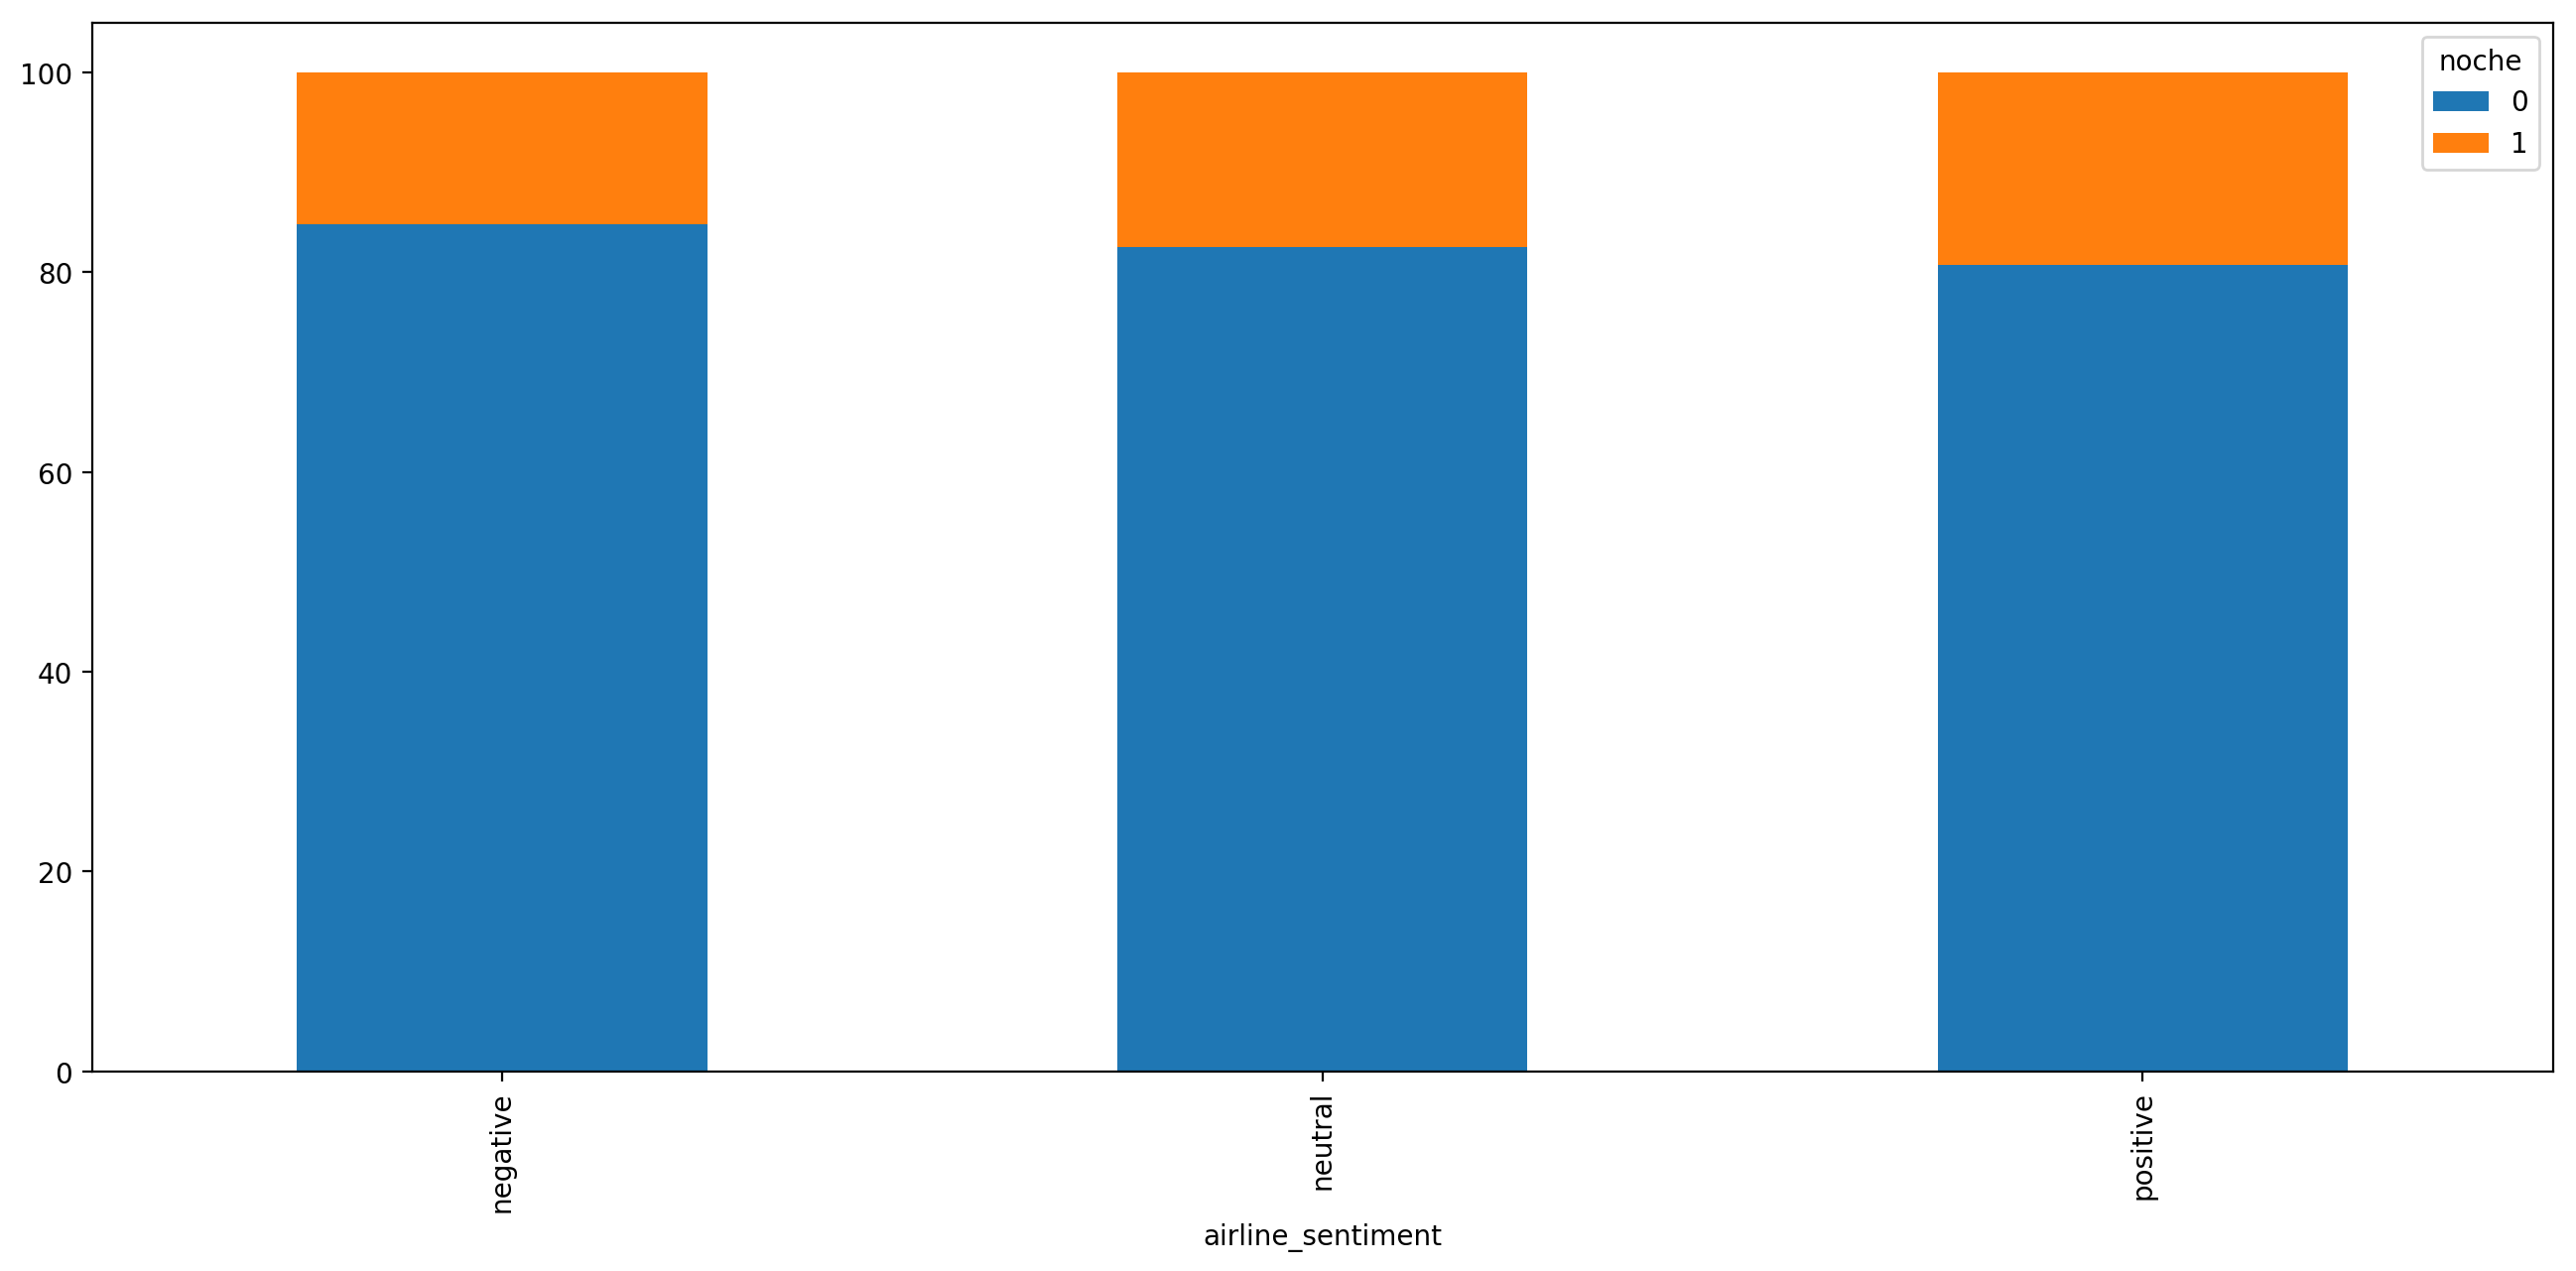

In [43]:
pd.crosstab(index=df['airline_sentiment'],columns=df['noche']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

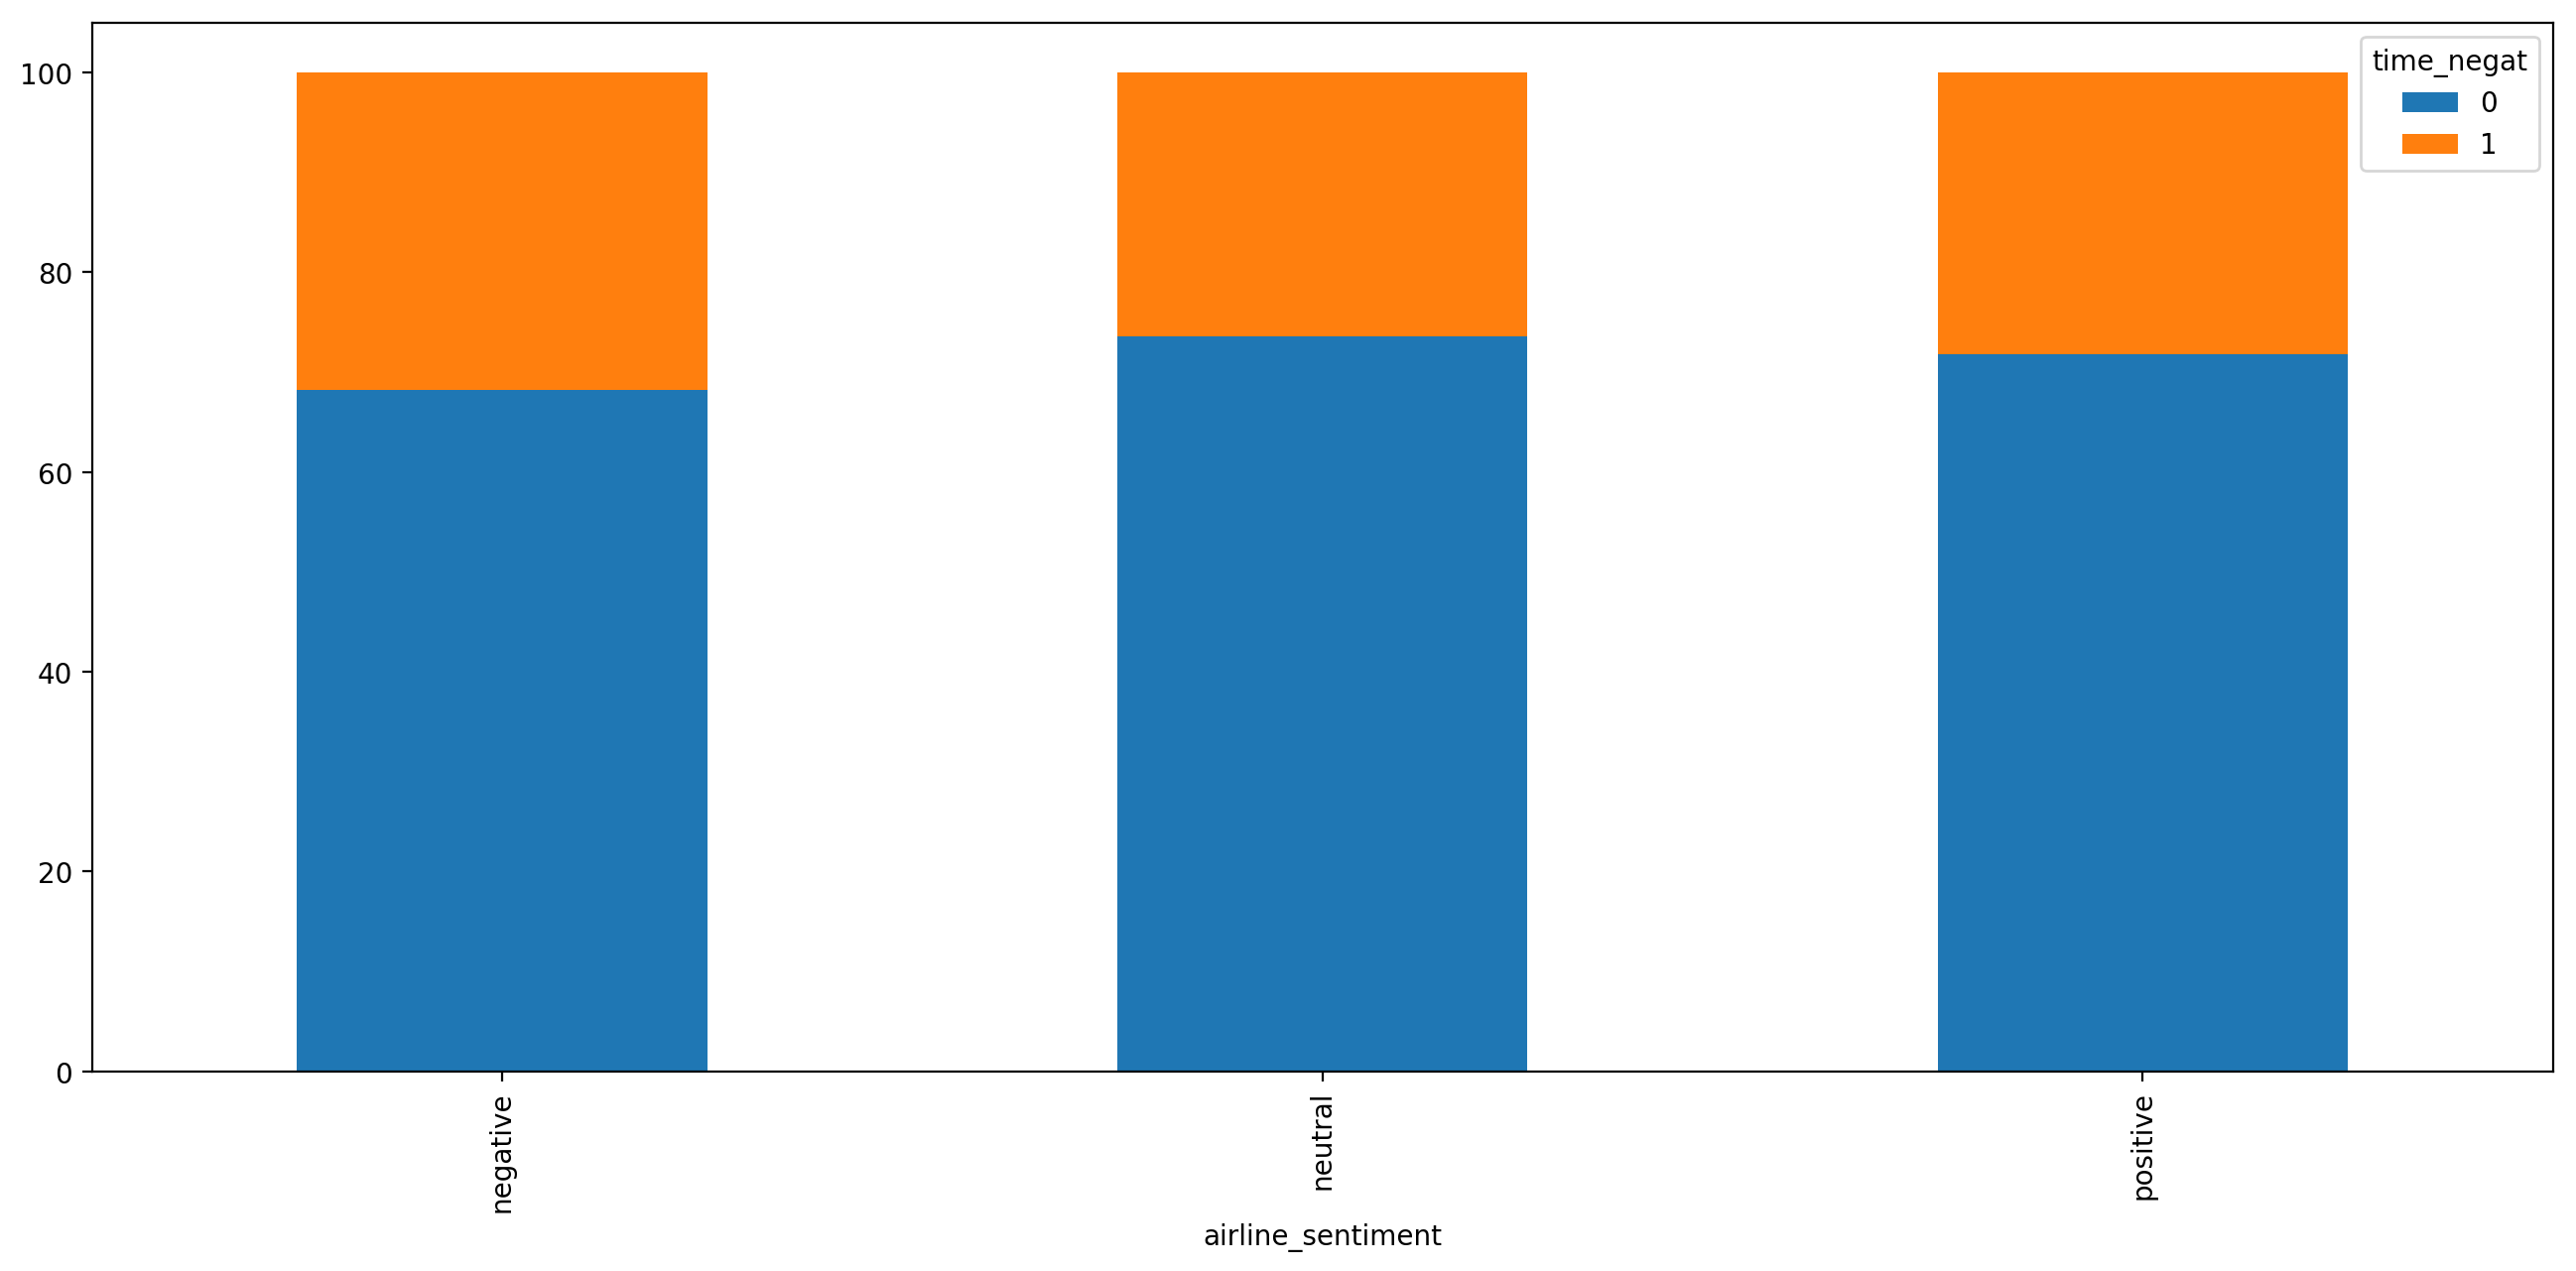

In [44]:
pd.crosstab(index=df['airline_sentiment'],columns=df['time_negat']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

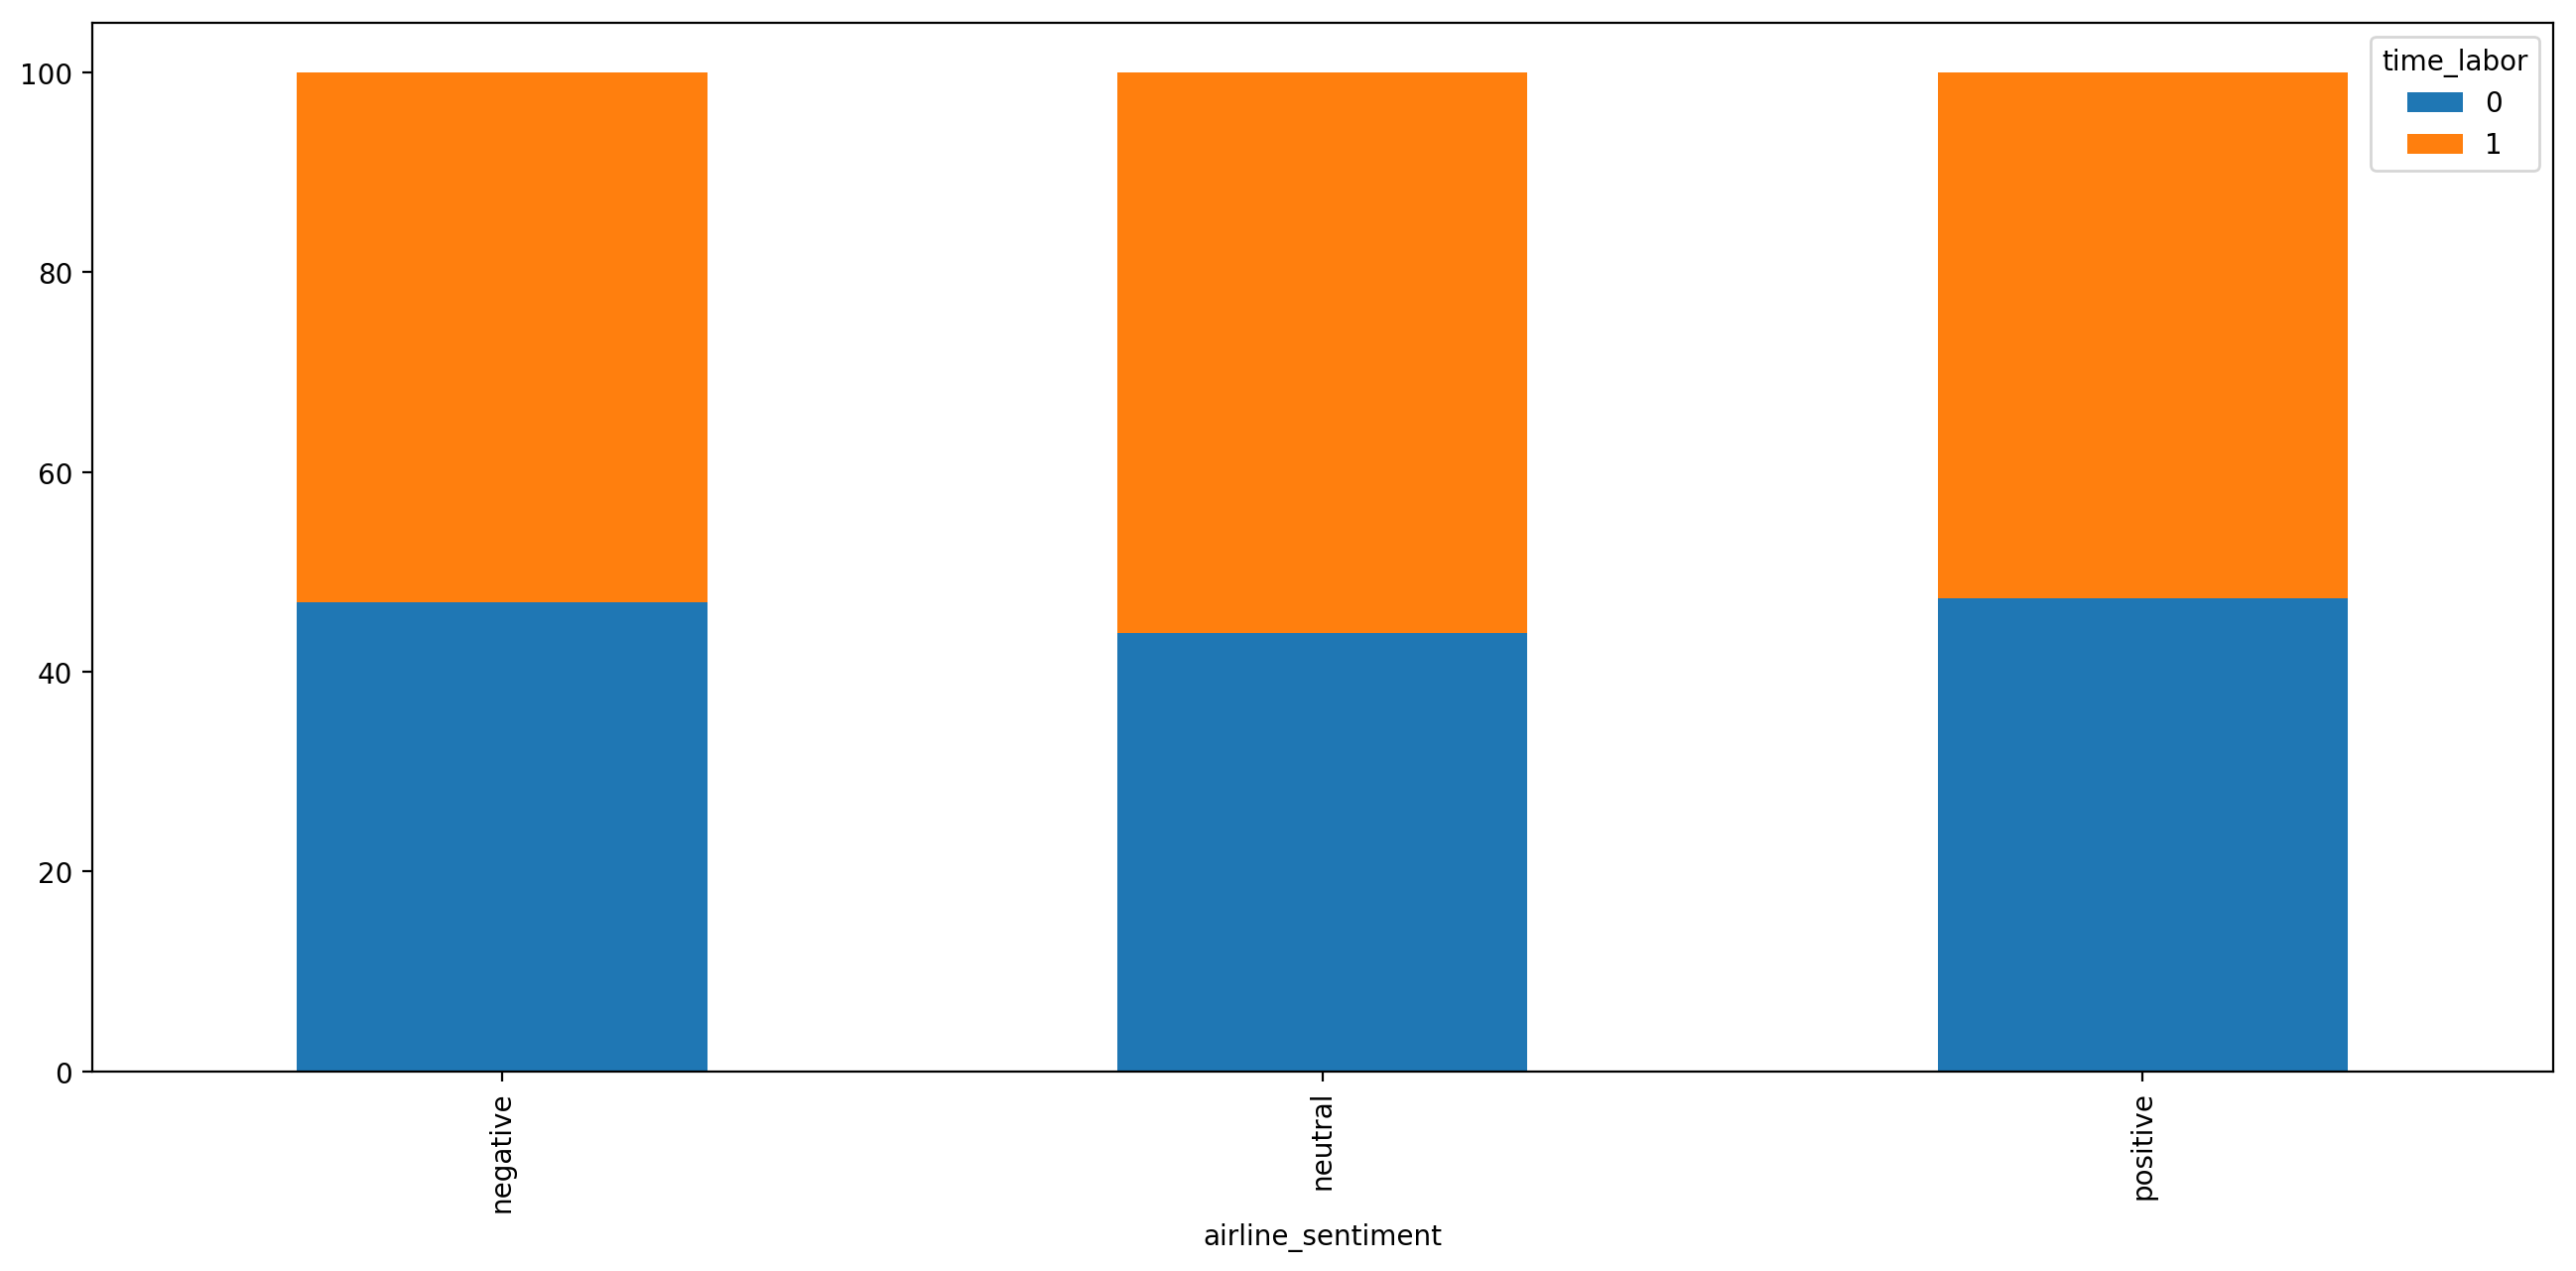

In [45]:
pd.crosstab(index=df['airline_sentiment'],columns=df['time_labor']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Análisis USERZONE

In [46]:
zonas = pd.read_excel('Zonas.xlsx')
zonas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
USER_ZONE        60 non-null object
BIG_ZONE         60 non-null object
SPECIFIC_ZONE    60 non-null object
dtypes: object(3)
memory usage: 1.5+ KB


In [47]:
# Creamos nuevas columnas para mapear zonas en Grandes zonas y Específicas

df['user_big_zone'] = 'nothing'
df['user_specific_zone'] = 'nothing'

for i in df.index:
    for j in range(len(zonas.USER_ZONE)-1):
        if df.user_timezone[i] == zonas.USER_ZONE[j]:
            df.set_value(i,'user_big_zone',zonas.BIG_ZONE[j],takeable=False)
            df.set_value(i,'user_specific_zone',zonas.SPECIFIC_ZONE[j],takeable=False)
        else:
            pass

In [48]:
print(df.groupby(['user_big_zone','airline_sentiment']).size())

user_big_zone  airline_sentiment
AFRICA         negative             4   
               neutral              4   
               positive             2   
ASIA           negative             6   
               neutral              2   
               positive             3   
EUROPA         negative             323 
               neutral              195 
               positive             137 
OCEANIA        negative             1   
RESTO_AM       negative             358 
               neutral              383 
               positive             164 
SPAIN          negative             961 
               neutral              649 
               positive             385 
USA-CAN        negative             260 
               neutral              179 
               positive             108 
nothing        negative             1856
               neutral              1197
               positive             690 
dtype: int64


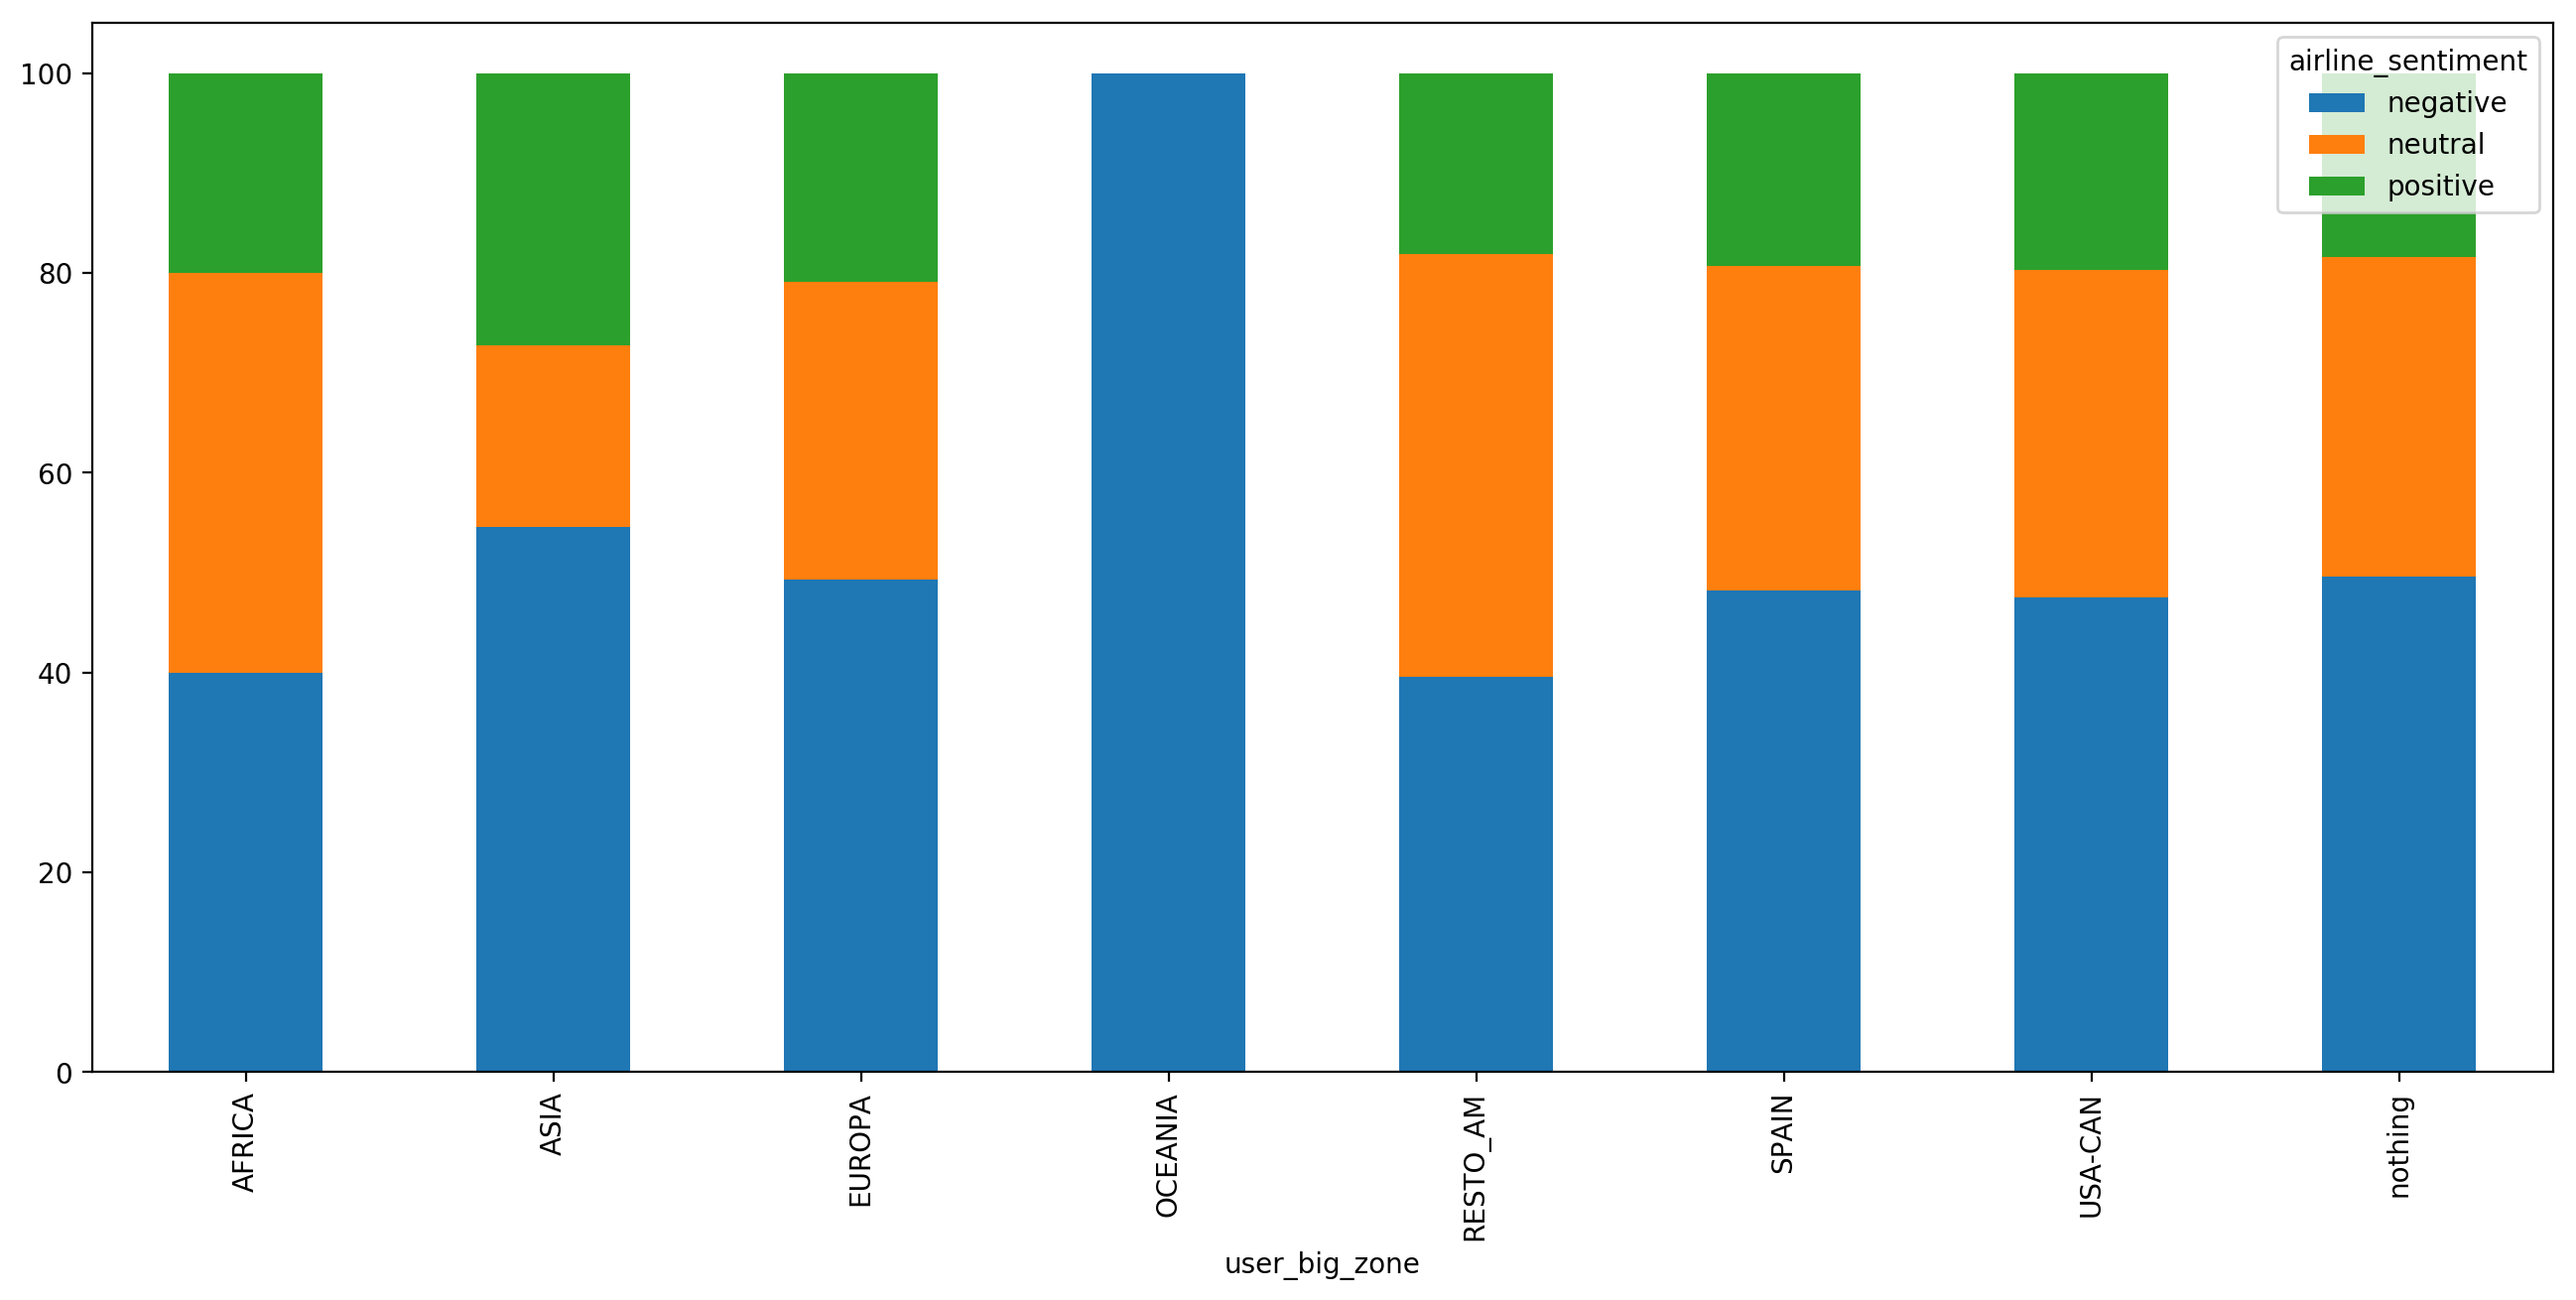

In [49]:
pd.crosstab(index=df['user_big_zone'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

In [50]:
print(df.groupby(['user_specific_zone','airline_sentiment']).size())

user_specific_zone  airline_sentiment
AFRICA              negative             4   
                    neutral              4   
                    positive             2   
ARGENTINA           negative             138 
                    neutral              136 
                    positive             66  
ASIA                negative             6   
                    neutral              2   
                    positive             3   
CHILE               negative             89  
                    neutral              65  
                    positive             26  
COLOMBIA            negative             88  
                    neutral              96  
                    positive             28  
ECUADOR             negative             19  
                    neutral              19  
                    positive             9   
EUROPA              negative             61  
                    neutral              51  
                    positive             3

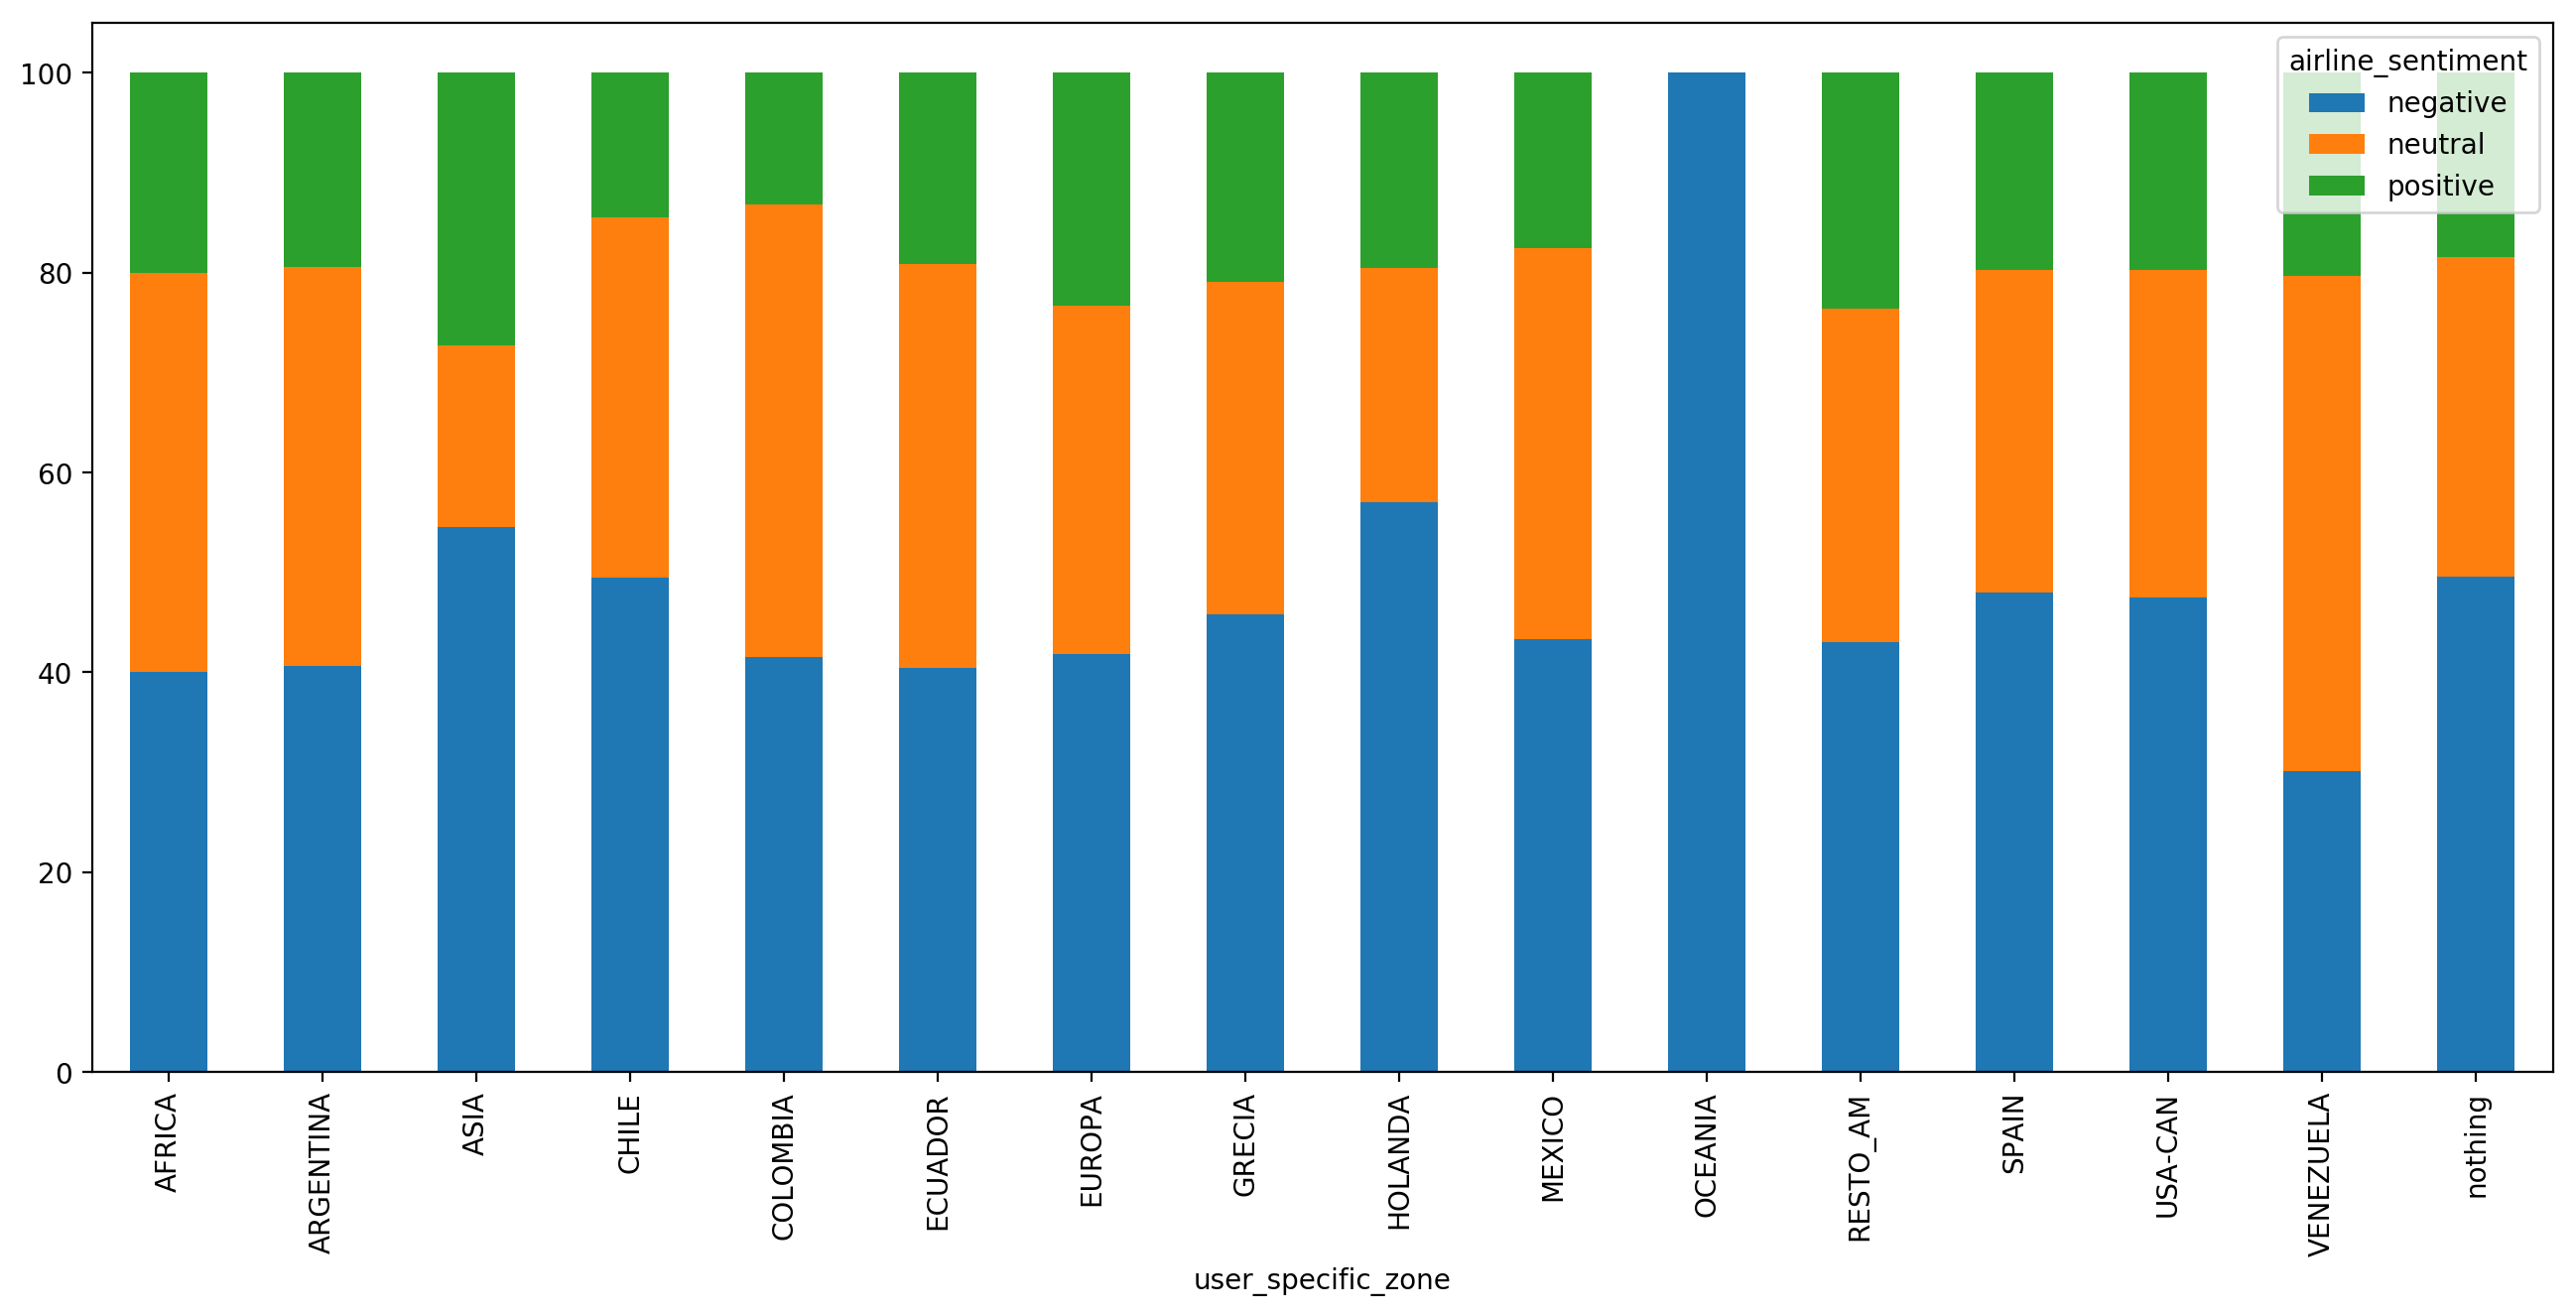

In [51]:
pd.crosstab(index=df['user_specific_zone'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

In [52]:
# EN PAÍSES LATINOAMERICANOS PARECE QUE HAY MAYOR PROPORCIÓN DE NEUTROS, CON CIERTA RELACIÓN
# CON EL CONCURSO (HOLAARGENTINA, HOLAVENEZUELA...)

df['LatinAM_bool']=df['user_big_zone'].apply(lambda d:d=='RESTO_AM')

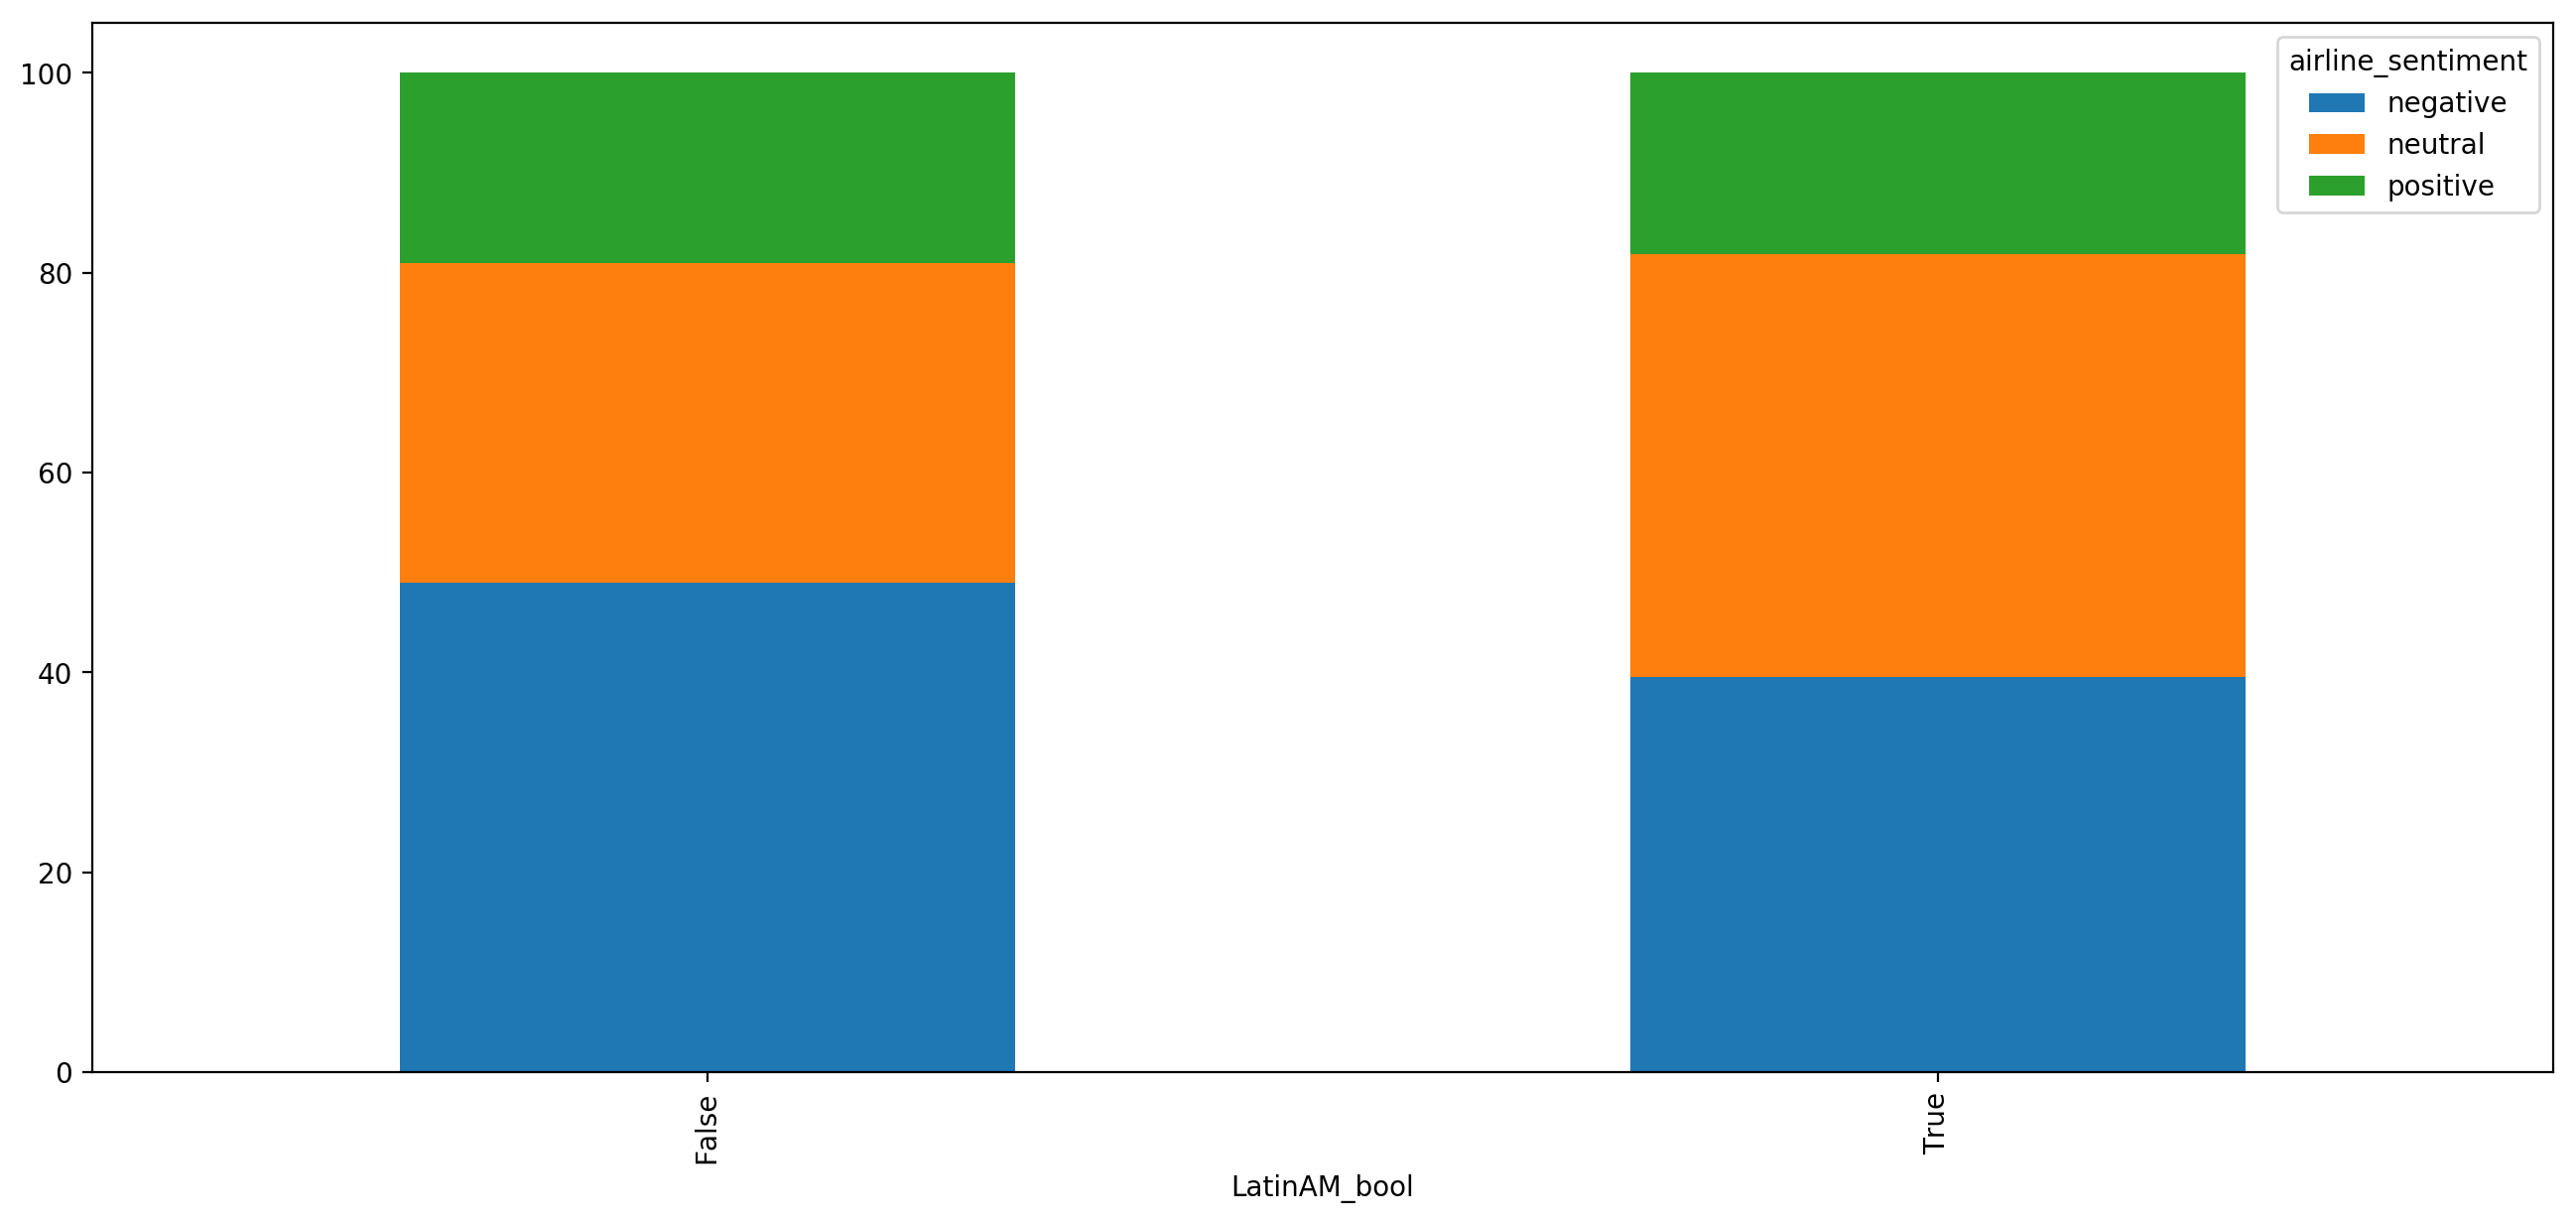

In [53]:
pd.crosstab(index=df['LatinAM_bool'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

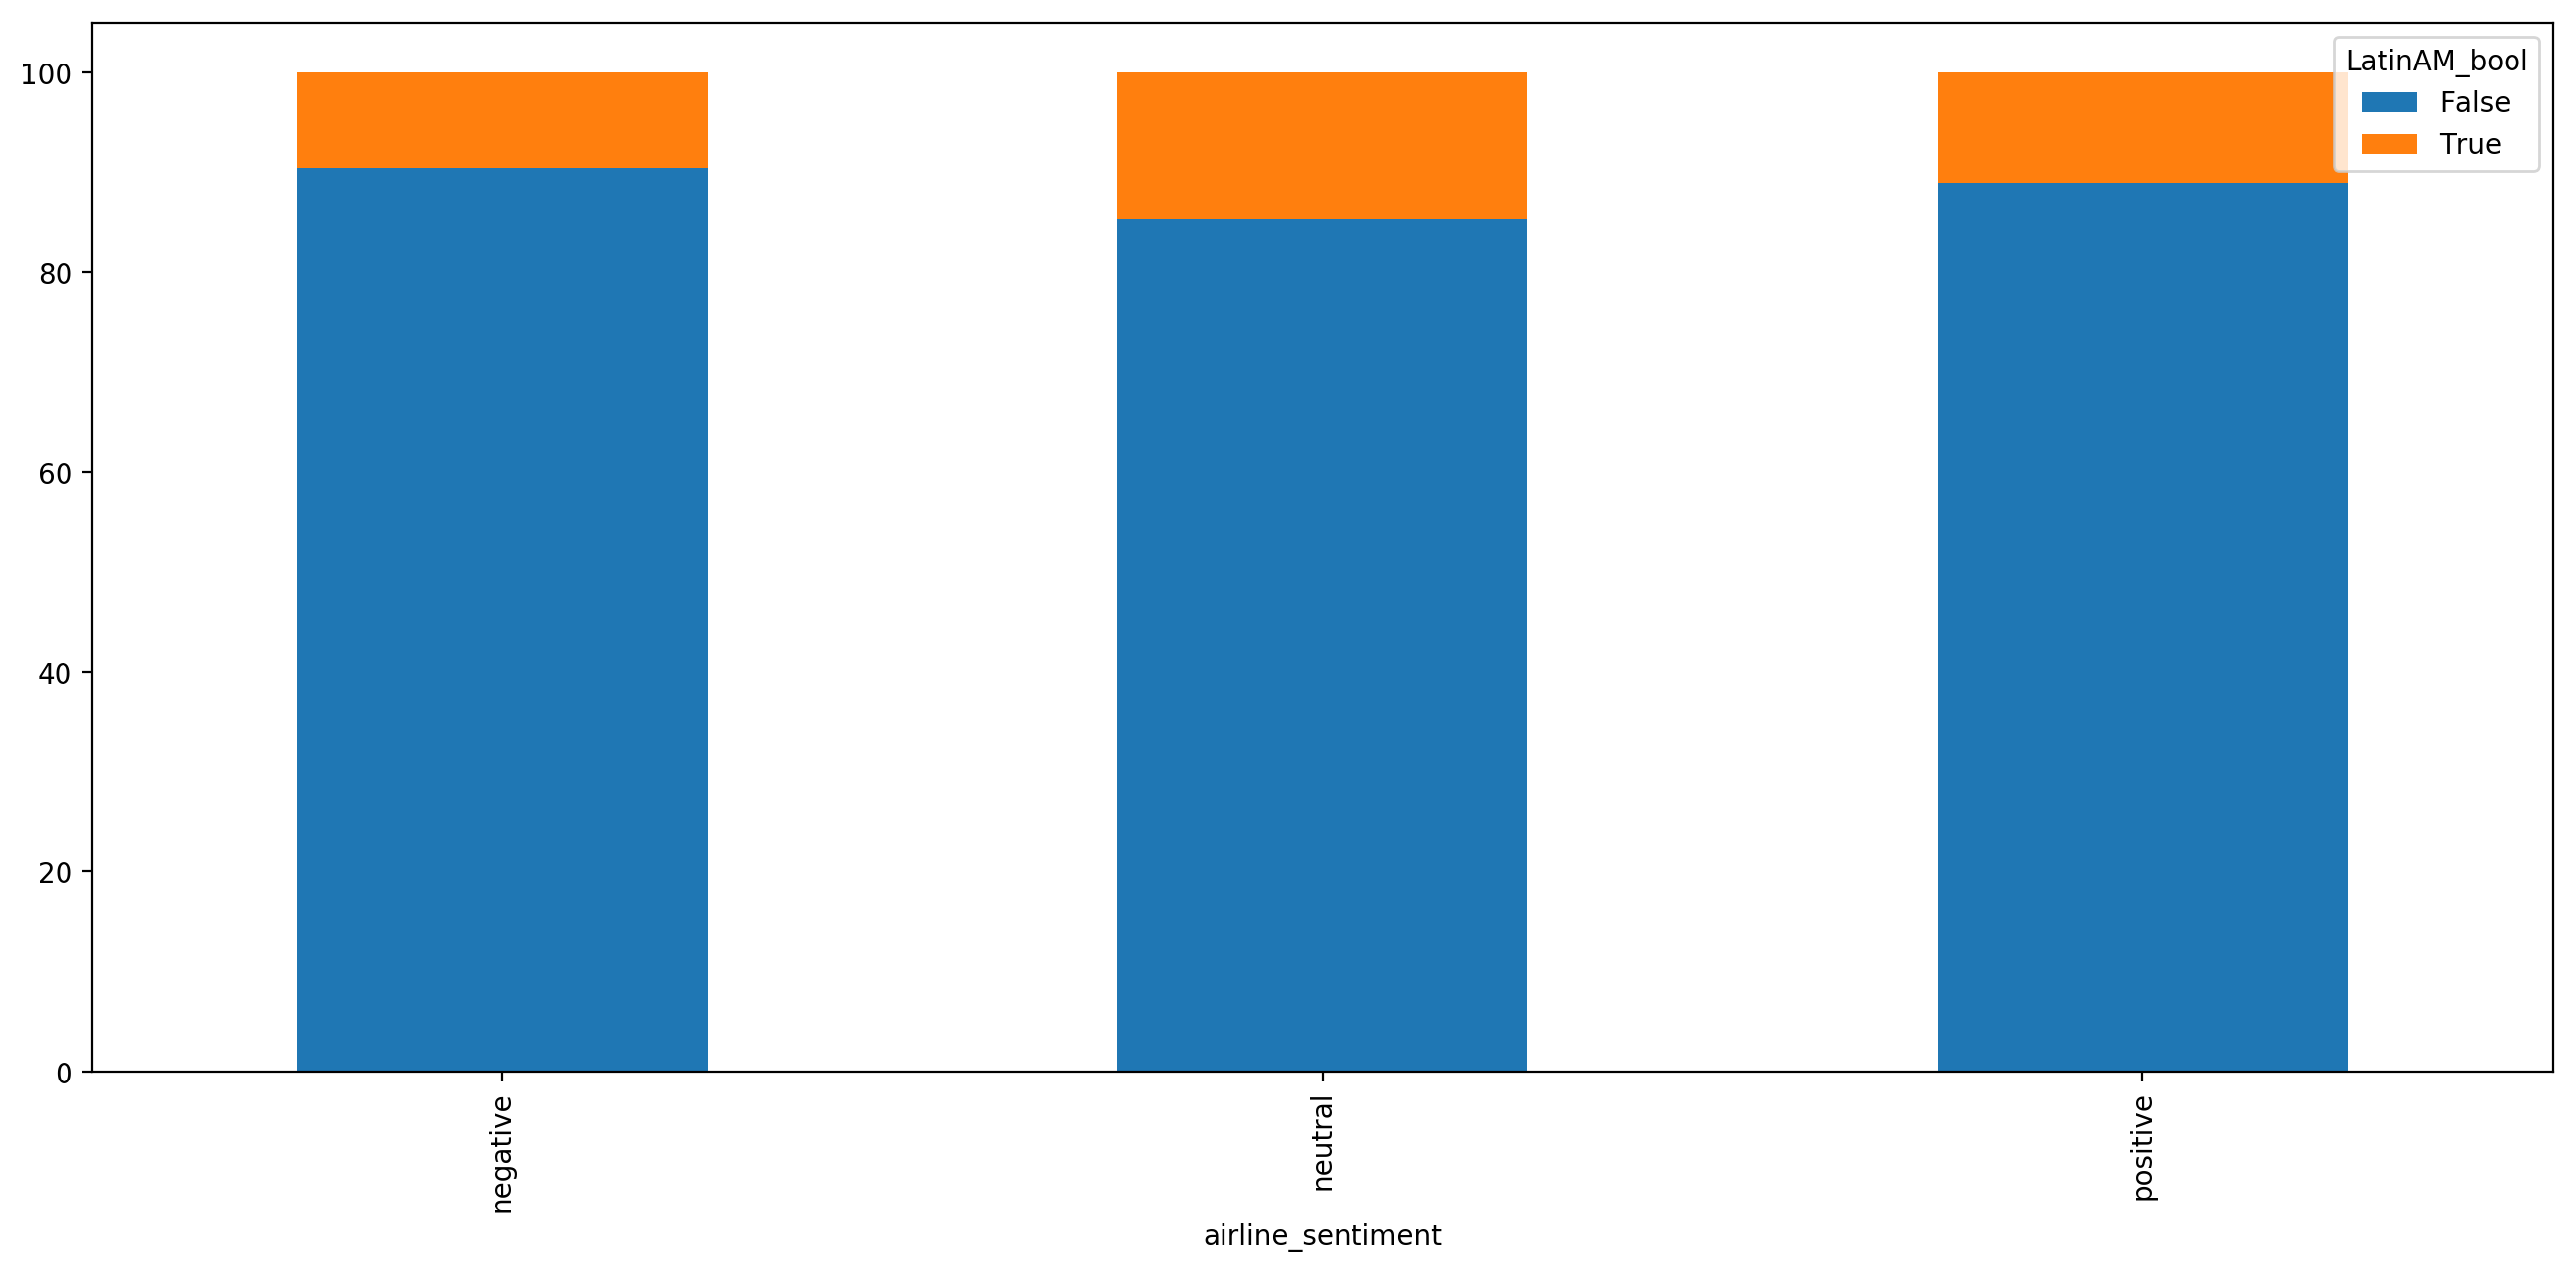

In [54]:
pd.crosstab(index=df['airline_sentiment'],columns=df['LatinAM_bool']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Análisis de HASHTAGS

In [55]:
# IDENTIFICAMOS LOS TWEETS CON HOLAXXX, QUE SON DEL CONCURSO DE IBERIA

df['HolaX']=df['hashtags'].apply(lambda x: int(bool(re.match(r'.*(Hola[A-Z]{1})[a-z]+.*',x))))
#SI DECIDIMOS ELIMINAR LOS CONCURSOS DEL MODELO, DESCOMENTAR EL SIGUIENTE CÓDIGO:
#df=df[df['HolaX']==False]

In [56]:
df.groupby(['HolaX','airline_sentiment']).size()

HolaX  airline_sentiment
0      negative             3729
       neutral              2389
       positive             1339
1      negative             40  
       neutral              220 
       positive             150 
dtype: int64

In [57]:
df['n_mentions']=df['mentions'].apply(len)
df['n_hashtags']=df['hashtags'].apply(len)
df['n_airline']=df['airline'].apply(len)
df['mentions_si']=df['n_mentions'].apply(lambda x: int(bool(x>2)))
df['hashtags_si']=df['n_hashtags'].apply(lambda x: int(bool(x>2)))

2      6316
18     225 
17     222 
10     68  
11     65  
16     61  
14     50  
35     37  
12     37  
13     36  
53     35  
28     32  
15     30  
19     27  
22     27  
23     26  
20     23  
44     23  
21     22  
9      19  
26     18  
43     17  
33     17  
34     16  
48     15  
30     15  
39     14  
45     14  
37     14  
24     12  
       ..  
175    1   
104    1   
100    1   
165    1   
112    1   
144    1   
127    1   
111    1   
103    1   
99     1   
71     1   
198    1   
142    1   
126    1   
118    1   
90     1   
78     1   
74     1   
70     1   
169    1   
137    1   
117    1   
109    1   
105    1   
93     1   
61     1   
180    1   
164    1   
148    1   
4      1   
Name: n_hashtags, Length: 122, dtype: int64


(array([ 2.,  0., 11.,  0.,  9.,  0.,  0., 12.,  0., 19.,  0.,  0., 68.,
         0., 65.,  0., 37.,  0.,  0., 36.,  0., 35.,  0.,  0., 29.,  0.,
        36.,  0., 32.,  0.,  0., 63.,  0., 27.,  0.,  0., 23.,  0., 22.,
         0., 26.,  0.,  0., 26.,  0., 12.,  0.,  0.,  5.,  0., 15.,  0.,
        10.,  0.,  0., 32.,  0., 12.,  0., 14.]),
 array([ 5.        ,  5.41666667,  5.83333333,  6.25      ,  6.66666667,
         7.08333333,  7.5       ,  7.91666667,  8.33333333,  8.75      ,
         9.16666667,  9.58333333, 10.        , 10.41666667, 10.83333333,
        11.25      , 11.66666667, 12.08333333, 12.5       , 12.91666667,
        13.33333333, 13.75      , 14.16666667, 14.58333333, 15.        ,
        15.41666667, 15.83333333, 16.25      , 16.66666667, 17.08333333,
        17.5       , 17.91666667, 18.33333333, 18.75      , 19.16666667,
        19.58333333, 20.        , 20.41666667, 20.83333333, 21.25      ,
        21.66666667, 22.08333333, 22.5       , 22.91666667, 23.33333333,
 

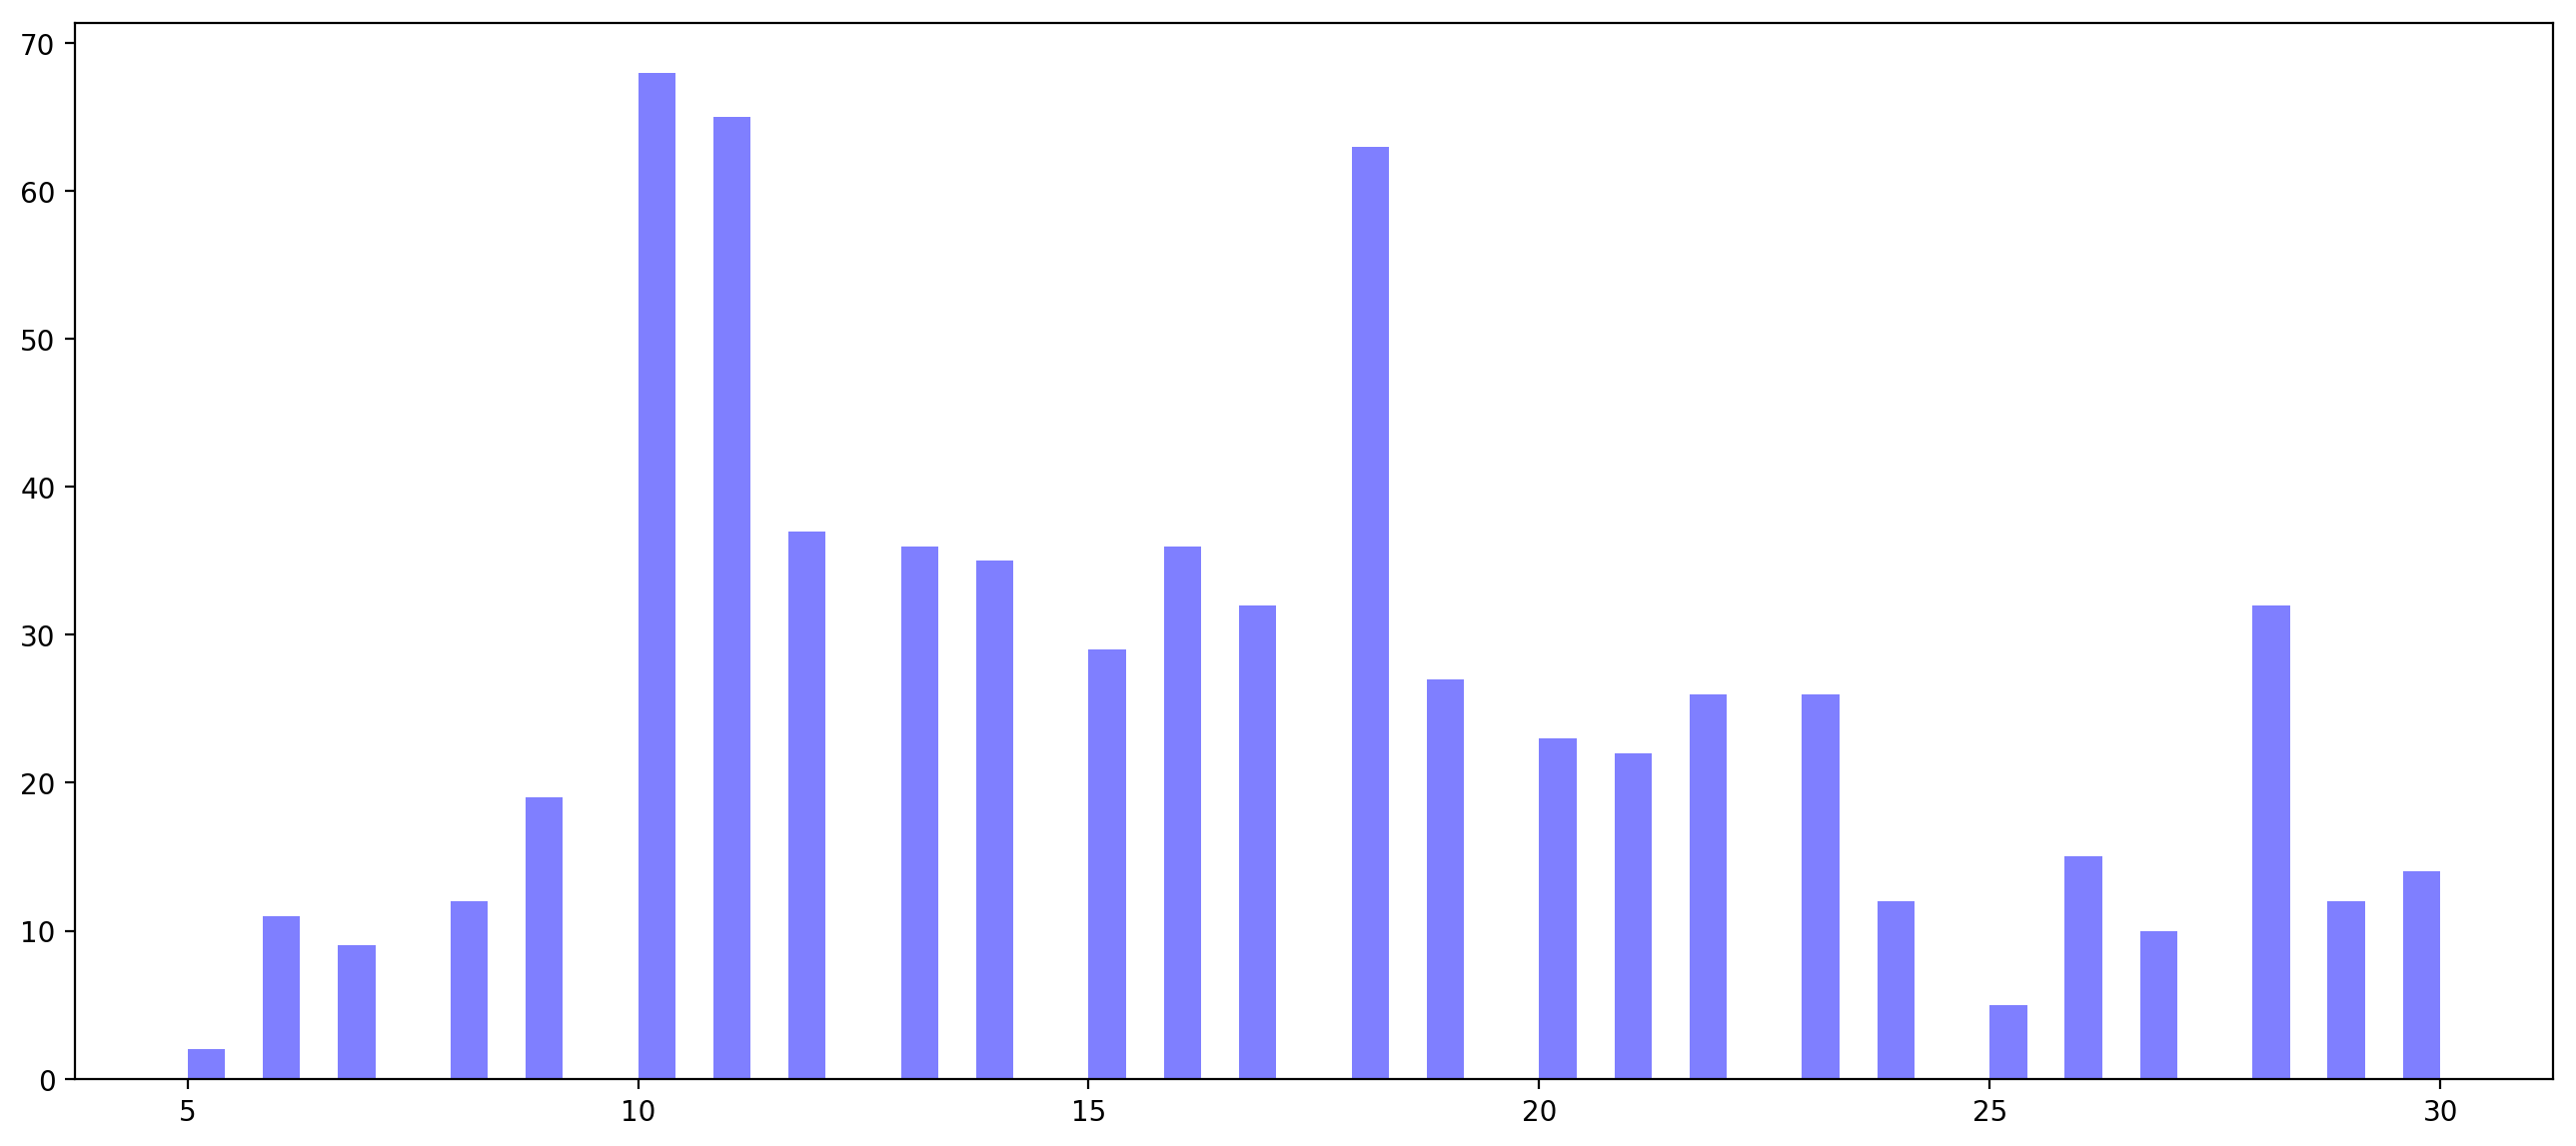

In [58]:
print(df.n_hashtags.value_counts())
prueba=df[df['HolaX']==0]
plt.hist(prueba.n_hashtags, bins=60, facecolor='blue', alpha=0.5, range=(5,30))


In [59]:
df['n_hashtags9']=df['n_hashtags'].apply(lambda x: int(bool(x>2 and x<=9)))
df['n_hashtags23']=df['n_hashtags'].apply(lambda x: int(bool(x>9 and x<=23)))
df['n_hashtags24mas']=df['n_hashtags'].apply(lambda x: int(bool(x>23)))
print('Nº con hasta 9:',df['n_hashtags9'].value_counts(),
      'Nº con 10-23:',df['n_hashtags23'].value_counts(),
      'Nº con 24 0 +:',df['n_hashtags24mas'].value_counts())

Nº con hasta 9: 0    7813
1    54  
Name: n_hashtags9, dtype: int64 Nº con 10-23: 0    6948
1    919 
Name: n_hashtags23, dtype: int64 Nº con 24 0 +: 0    7289
1    578 
Name: n_hashtags24mas, dtype: int64


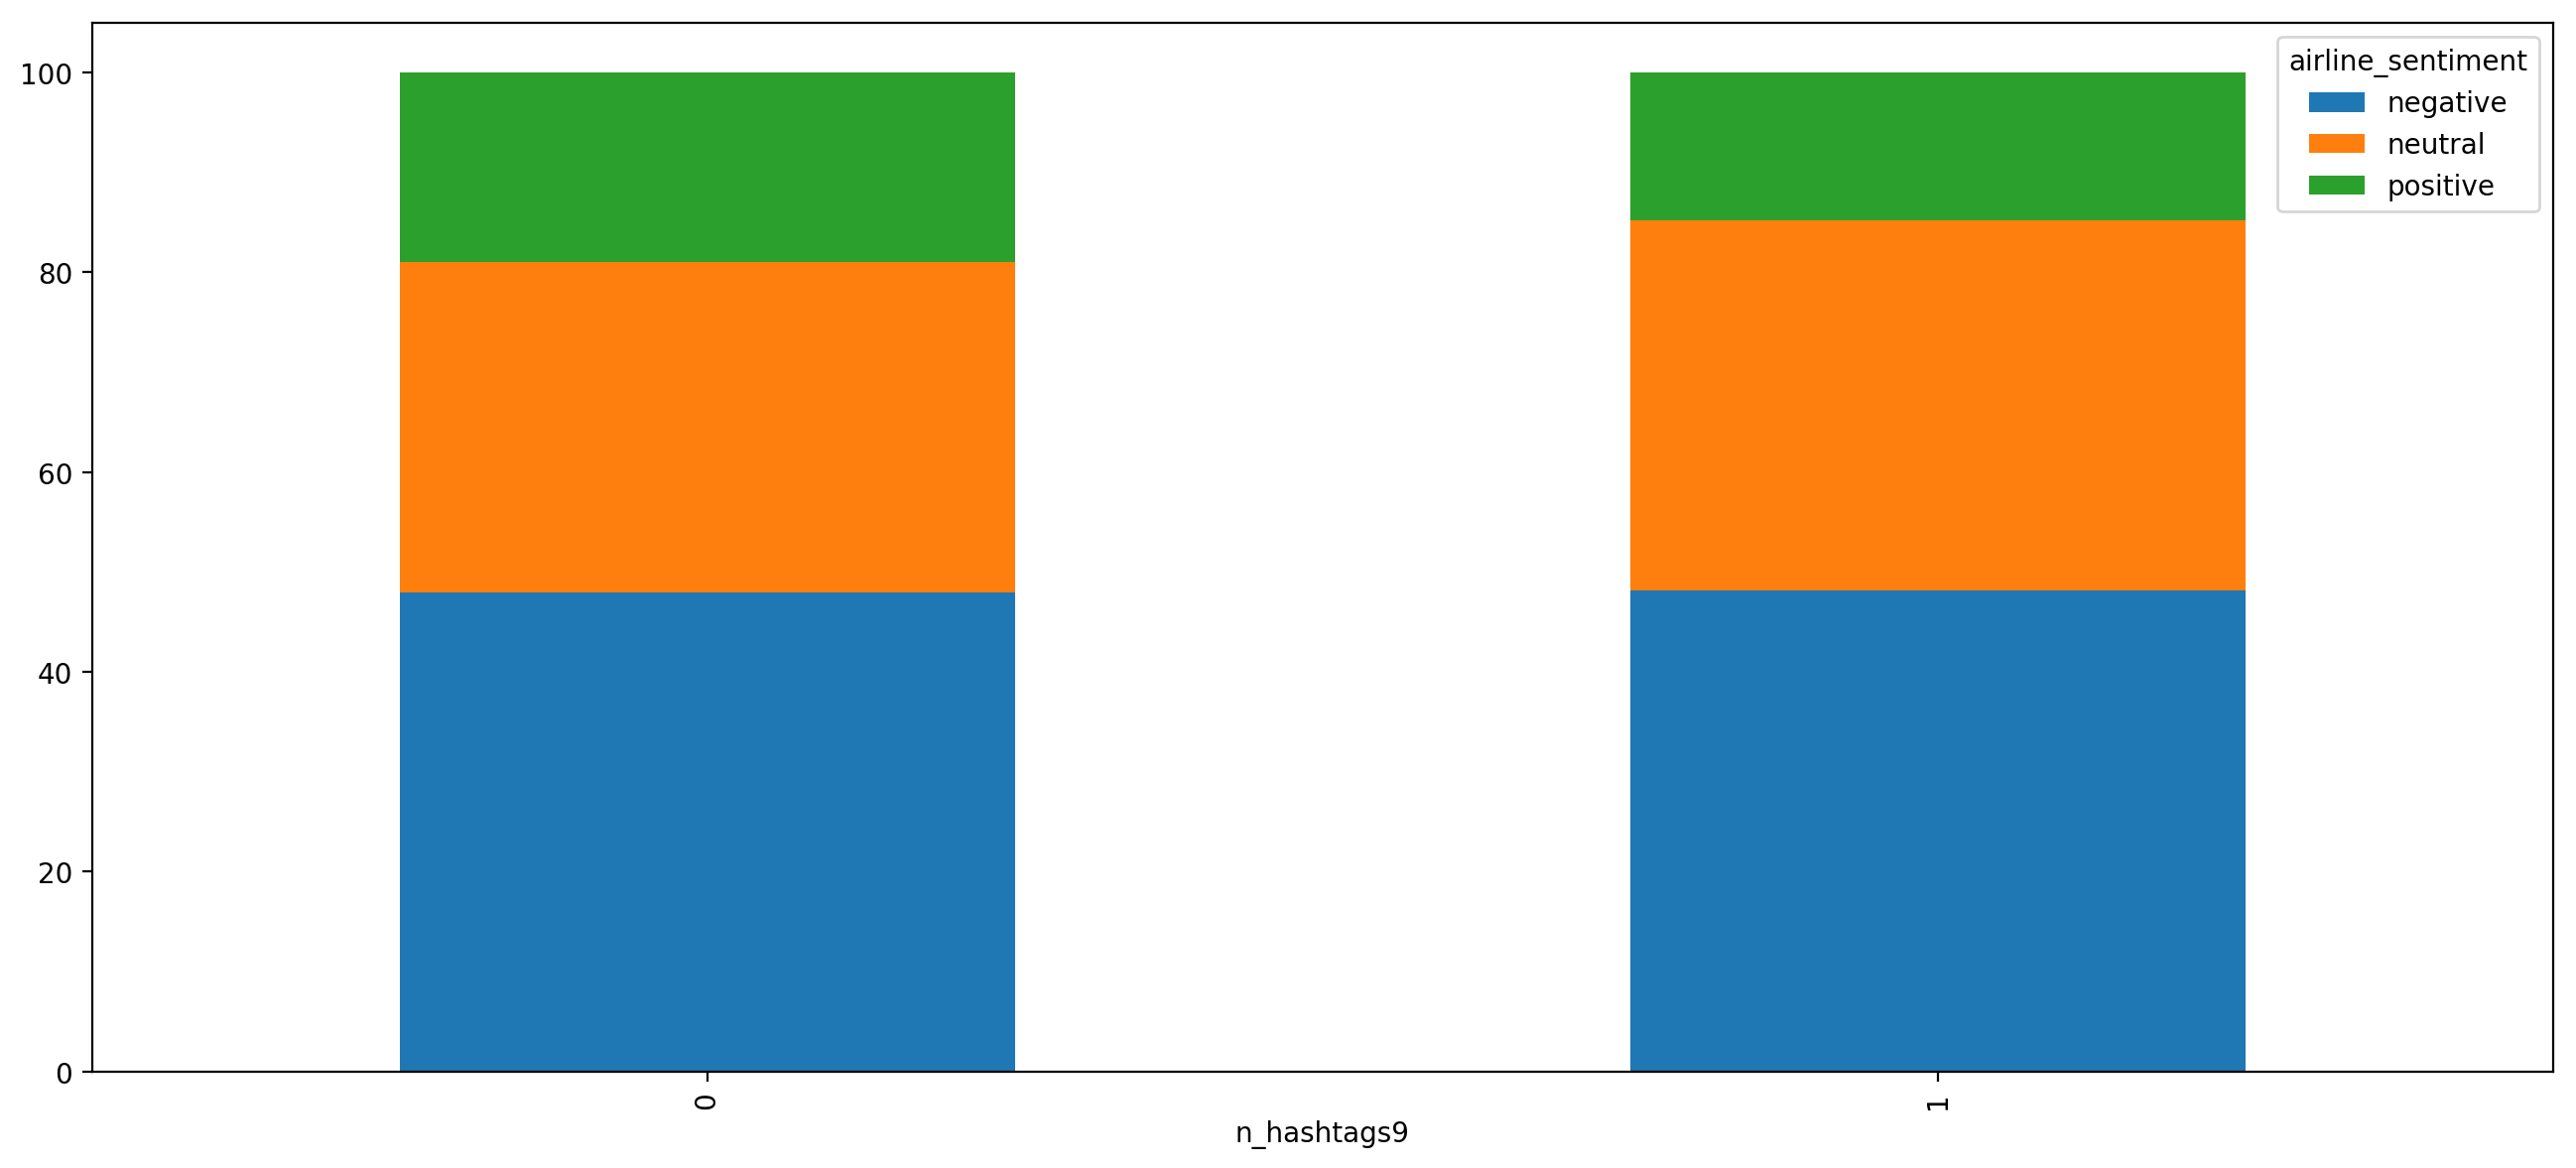

In [60]:
pd.crosstab(index=df['n_hashtags9'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Detalle del concurso: HolaX + destino-click

In [61]:
df['concurso']=df['whole_tweet'].apply(lambda h: int(bool('destino' in h and 'click' in h)))

In [62]:
df['concurso_tot']=df['concurso']+df['HolaX']
df['concurso_tot']=df['concurso_tot'].replace(2,1)

In [63]:
print(df['concurso'].value_counts())

0    7549
1    318 
Name: concurso, dtype: int64


In [64]:
print(df['concurso_tot'].value_counts())

0    7457
1    410 
Name: concurso_tot, dtype: int64


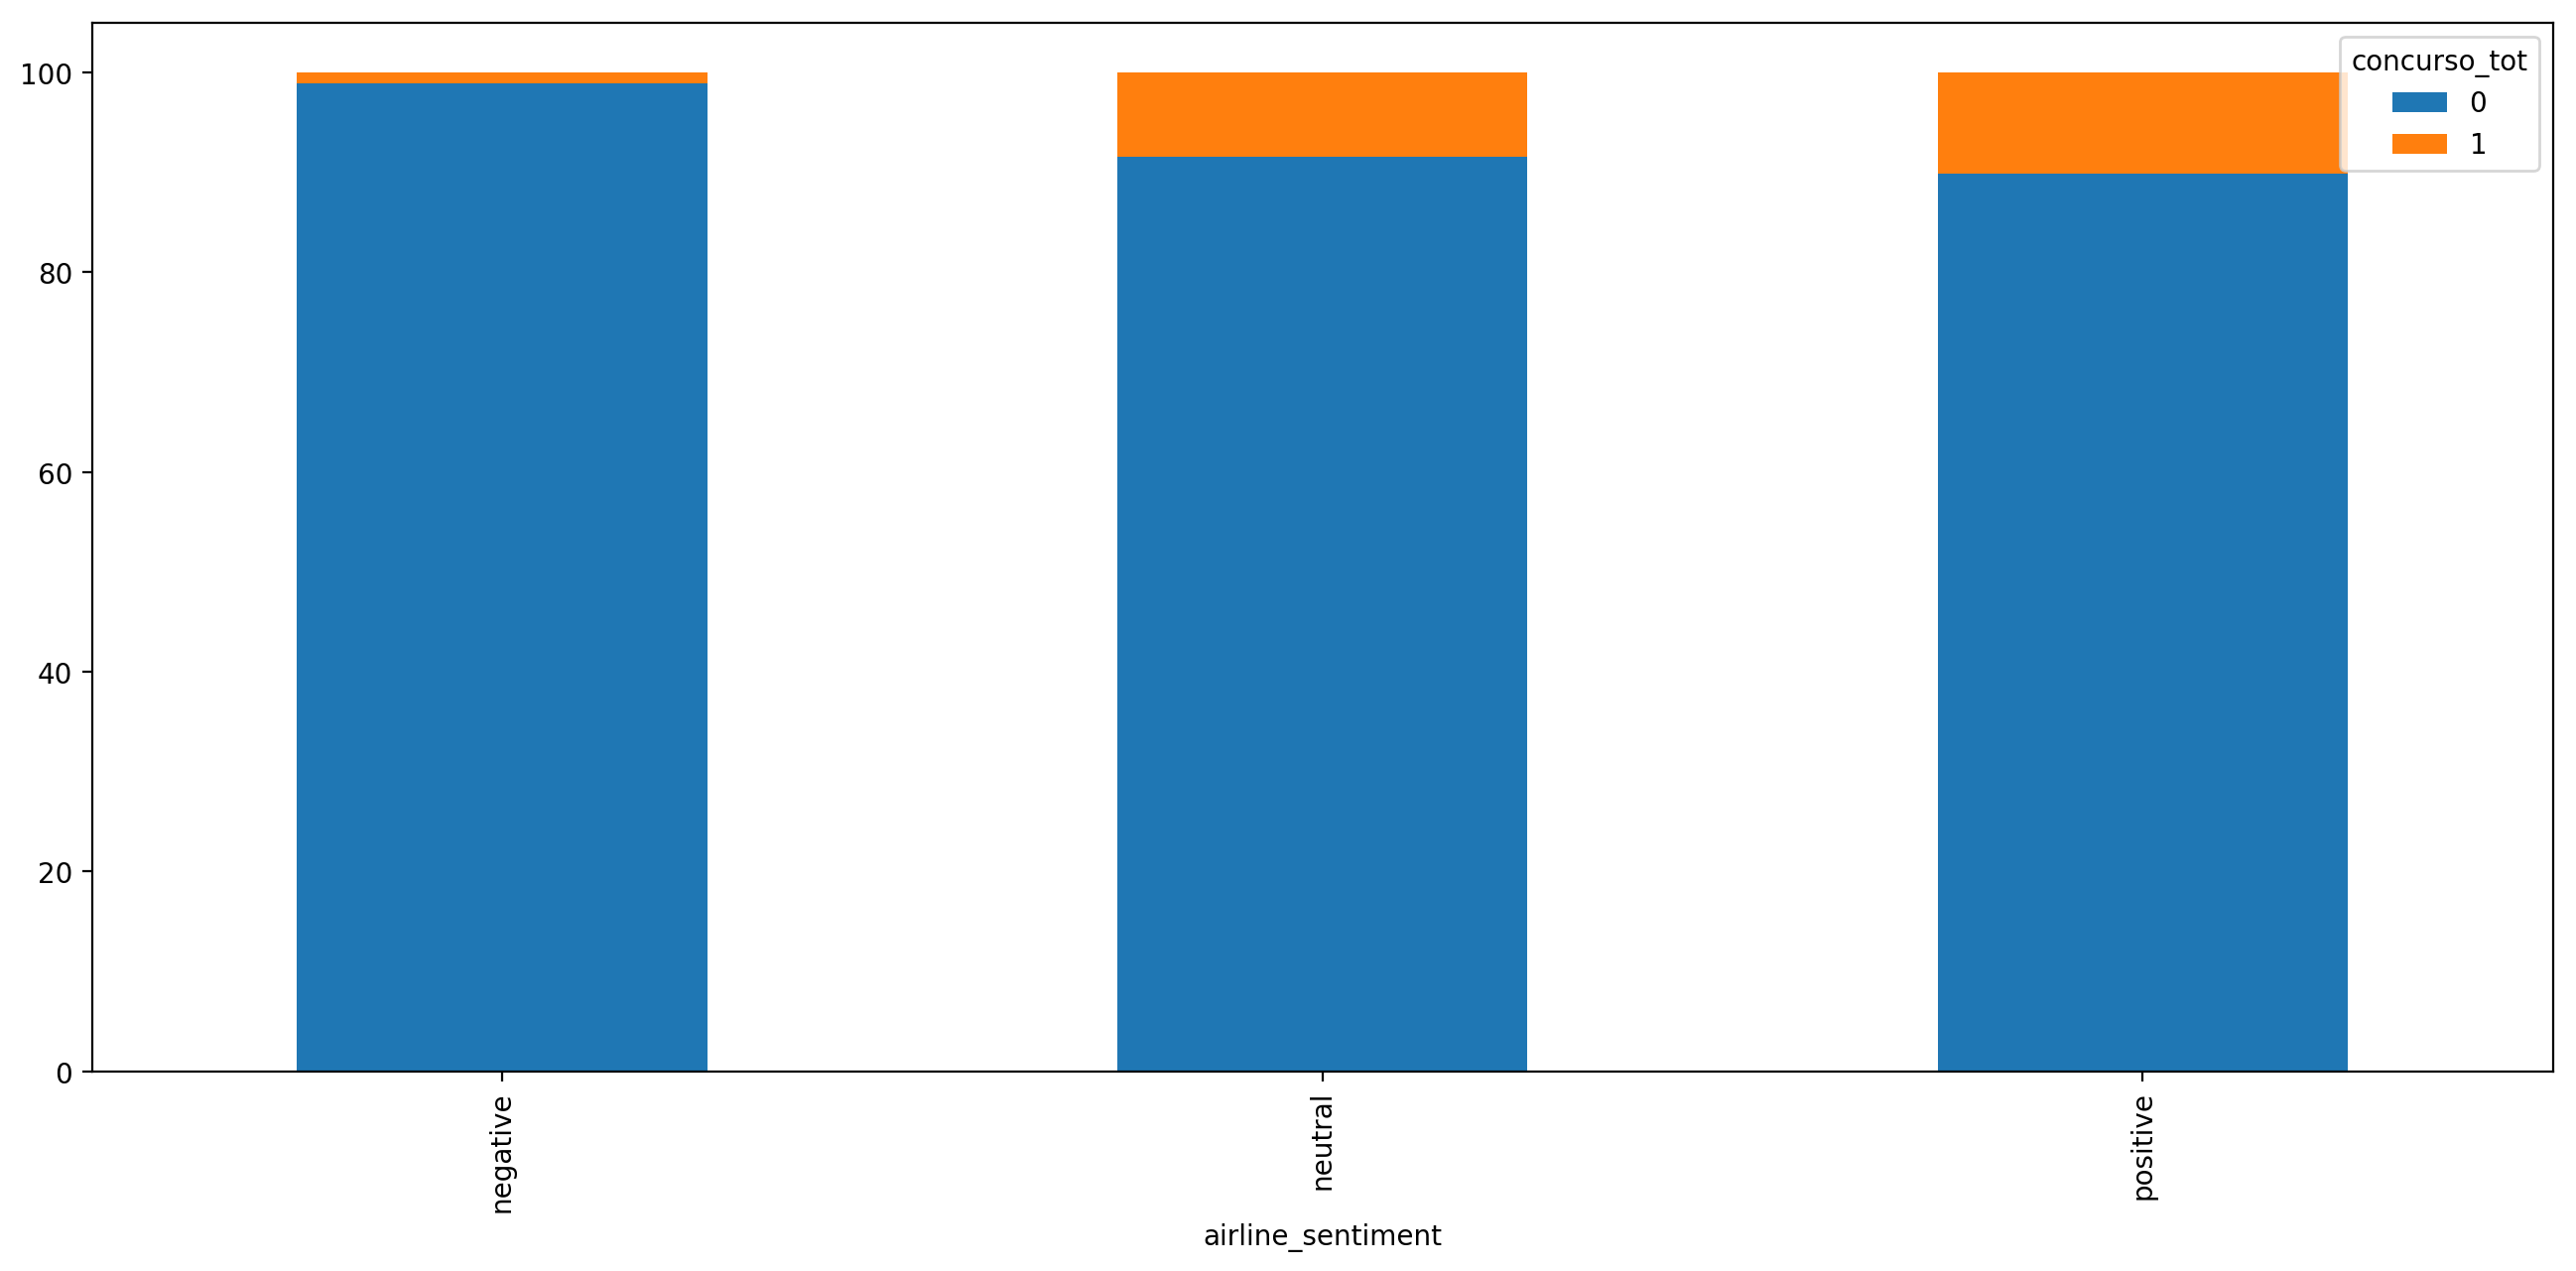

In [65]:
pd.crosstab(index=df['airline_sentiment'],columns=df['concurso_tot']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Análisis del TEXTO

3769

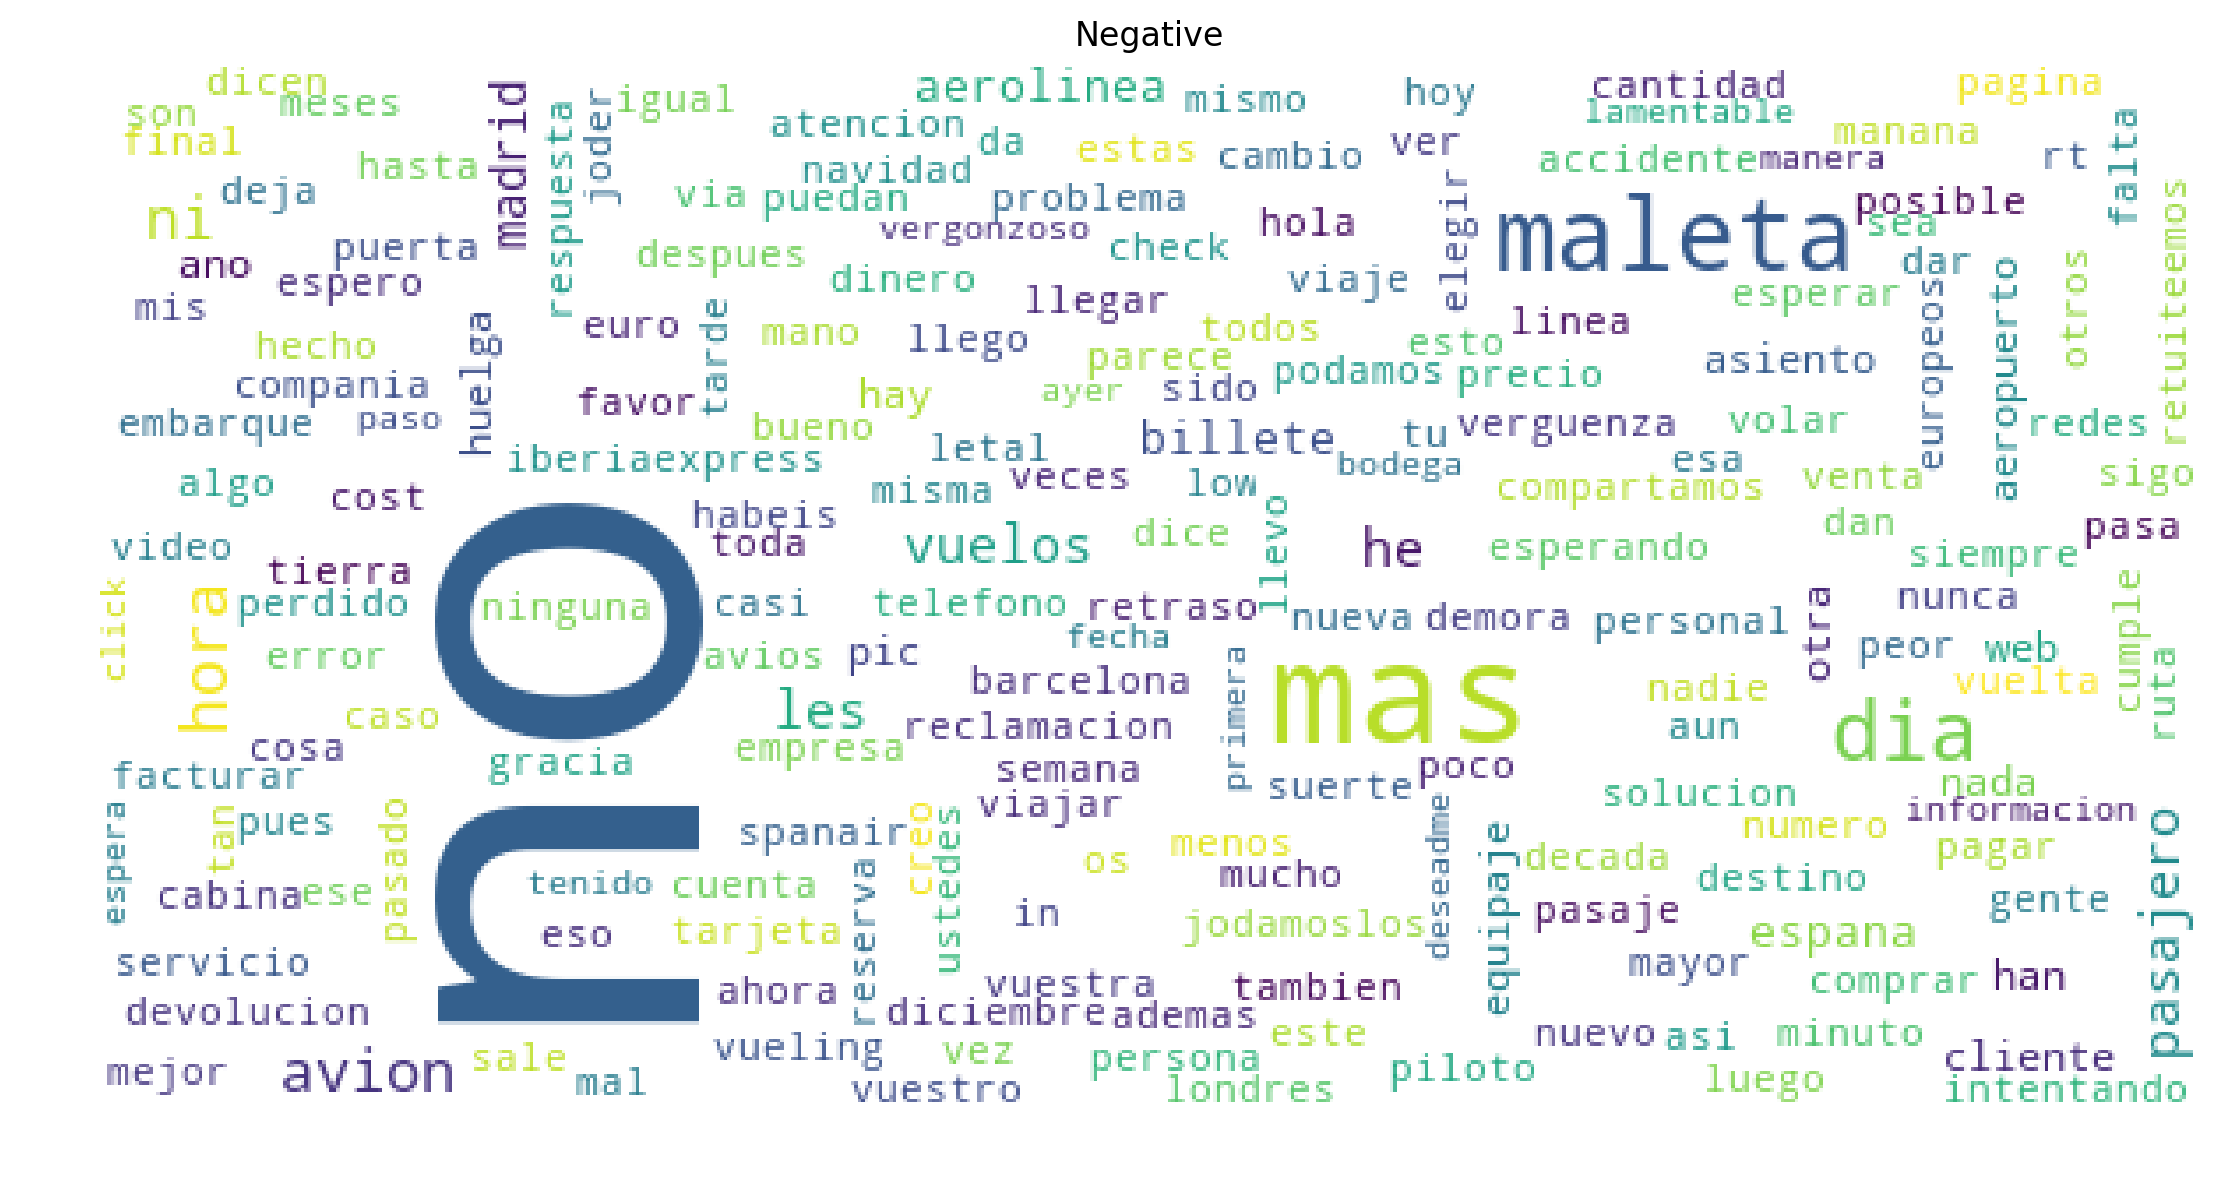

In [66]:
# Separamos en negativo, neutral y positivo
df_negative = df[df['airline_sentiment'] == 'negative']
df_neutral = df[df['airline_sentiment'] == 'neutral']
df_positive = df[df['airline_sentiment'] == 'positive']


sw_df=pd.read_csv('stopwords.csv')
sw=sw_df['stopwords'].values.tolist()
# Creamos un wordCloud para el texto de cada sentimiento
wc = {'width': 600, 'height': 300, 'random_state': 0, 'background_color': 'white', 'collocations': False, 'relative_scaling': 1, 'stopwords': sw}
wordcloud = WordCloud(**wc).generate(''.join(df_negative['whole_tweet']))

plt.imshow(wordcloud)
plt.axis("off")
plt.title('Negative')

df_negative.shape[0]


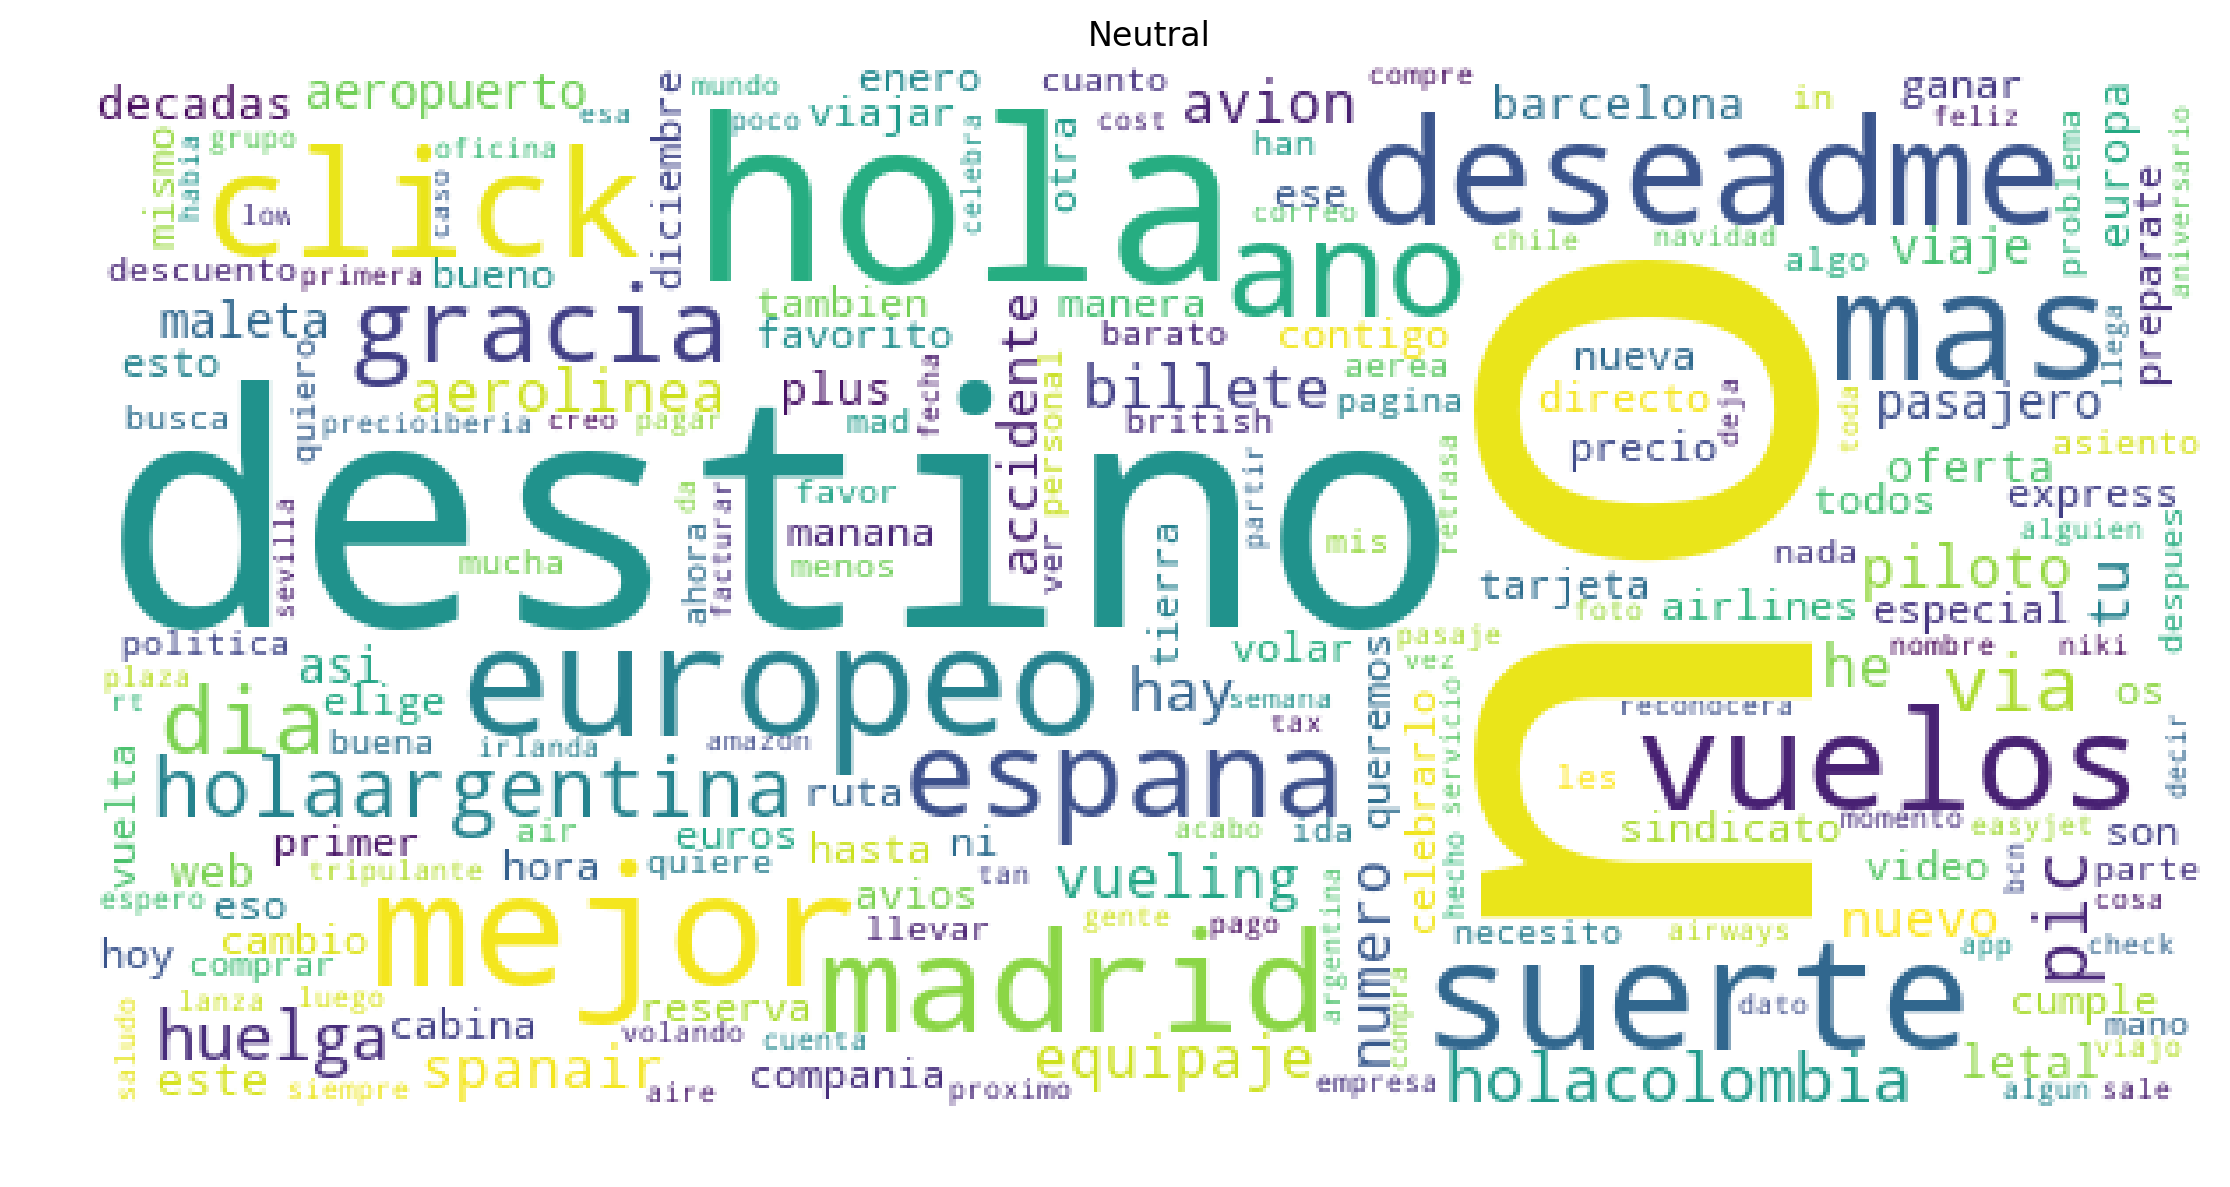

In [67]:
wc = {'width': 600, 'height': 300, 'random_state': 0, 'background_color': 'white', 'collocations': False, 'relative_scaling': 1, 'stopwords': sw}
wordcloud = WordCloud(**wc).generate(''.join(df_neutral['whole_tweet']))

plt.imshow(wordcloud)
plt.axis("off")
plt.title('Neutral')

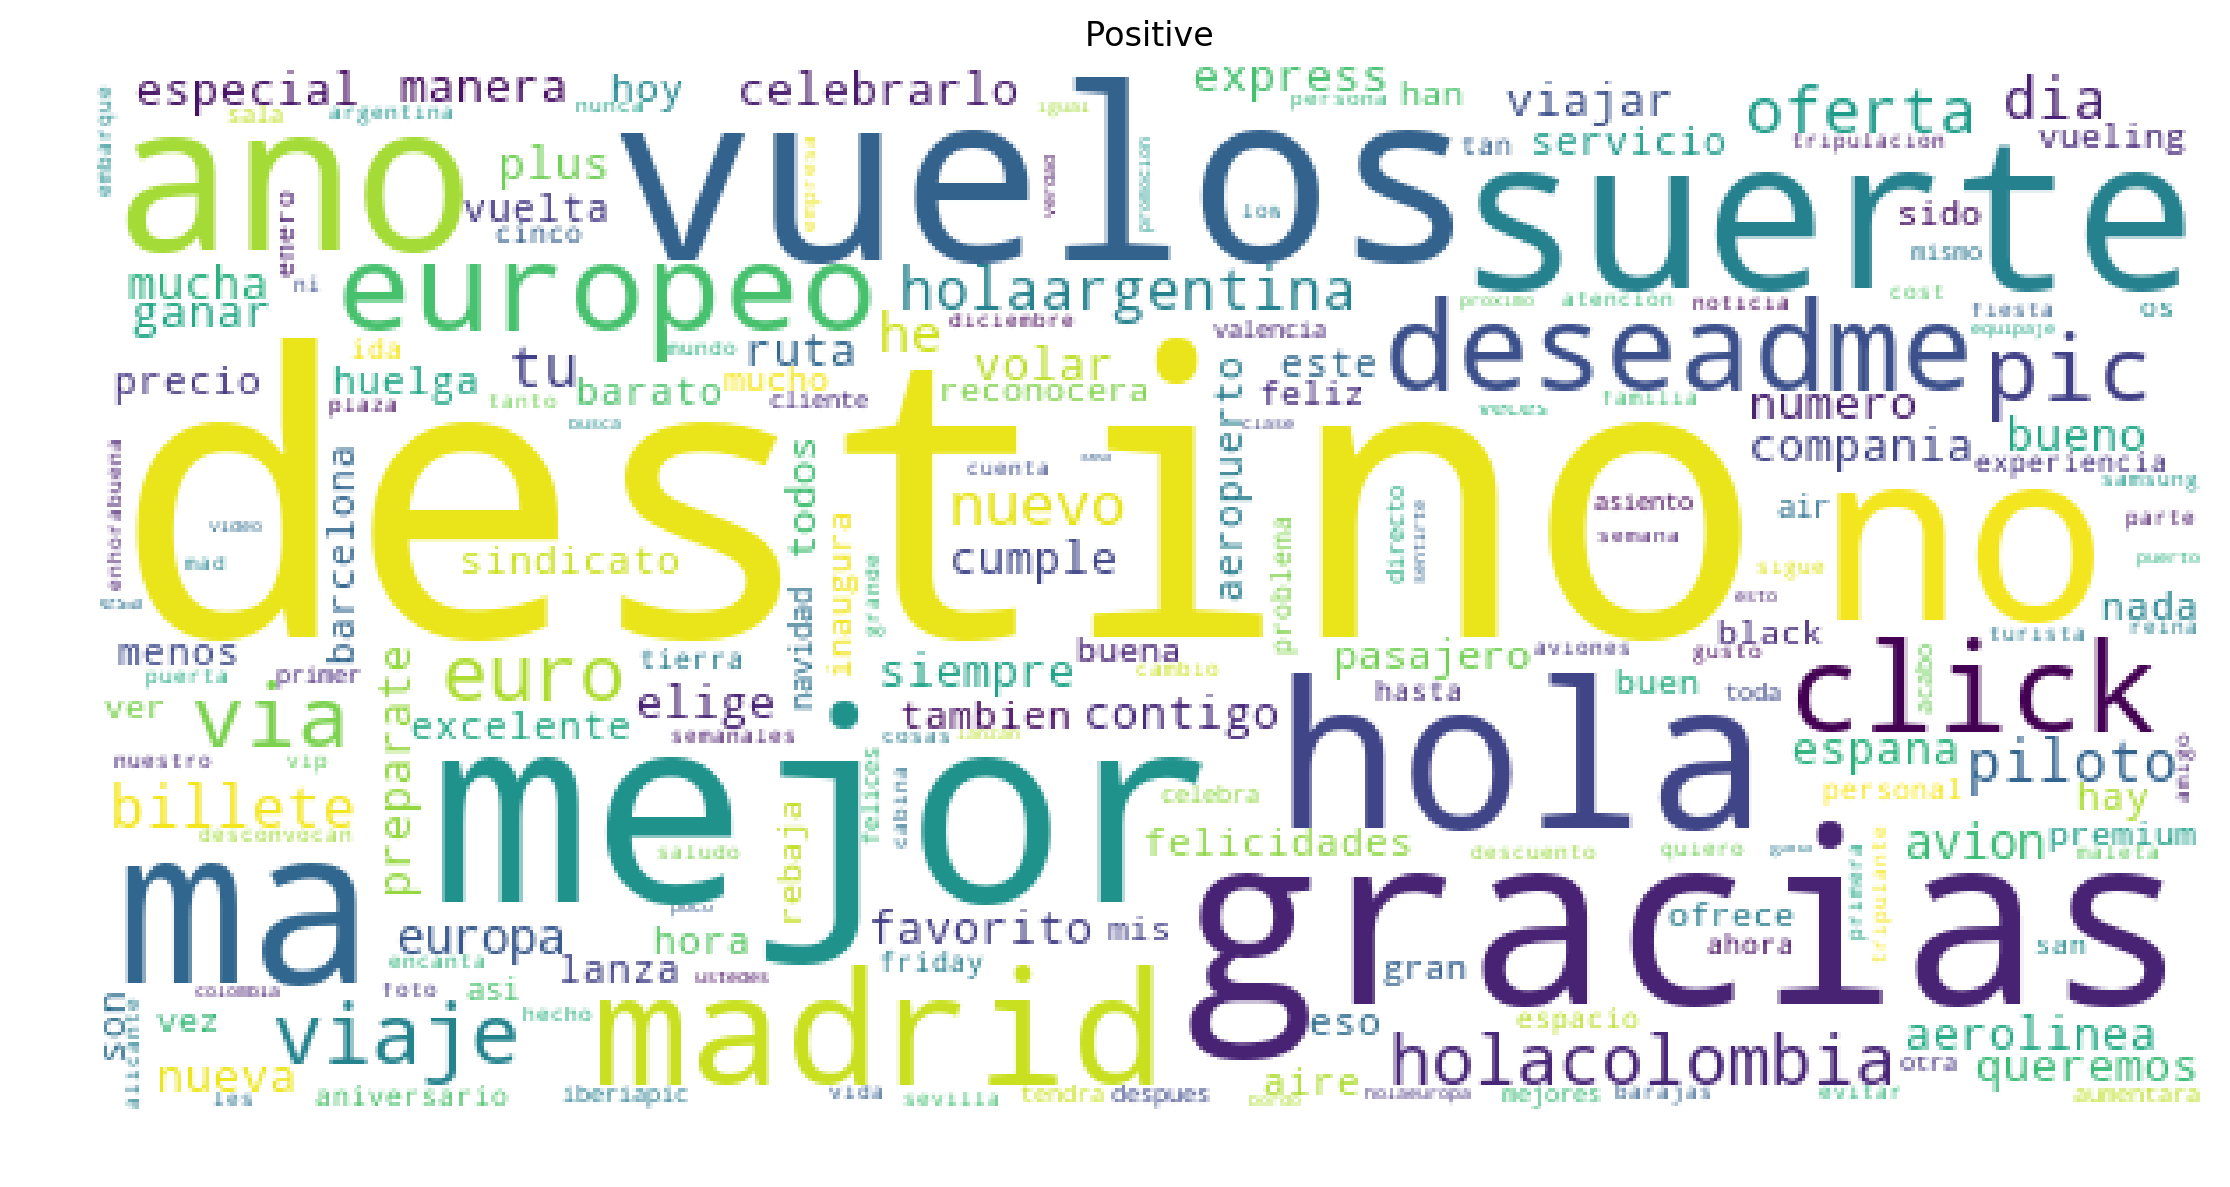

In [68]:
wc = {'width': 600, 'height': 300, 'random_state': 0, 'background_color': 'white', 'collocations': False, 'relative_scaling': 1, 'stopwords': sw}
wordcloud = WordCloud(**wc).generate(''.join(df_positive['whole_tweet']))

plt.imshow(wordcloud)
plt.axis("off")
plt.title('Positive')

In [69]:
print(df_neutral['whole_tweet'])

tweet_id
926419989107798016    trabajar en ryanair como tma empleo                                                                                                                                                                                                                                             
934854385577943041    cuando gusten en cancun se viaja y disfruta de manera sin igual                                                                                                                                                                                                                 
943893340617166849    iberia plus cumple 25 anos queremos celebrarlo contigo de una manera muy especial elige tu numero favorito y preparate para ganar                                                                                                                                               
936777743500324864    chuata yo tengo un madrid stgo en un par de semanas habra que cruzar los dedos      

In [70]:
print(df_positive.head(100))

                   airline_sentiment  \
tweet_id                               
947965901332197376  positive           
947939379317788672  positive           
942833013129449473  positive           
941356636488298497  positive           
943102054968516608  positive           
948554823464554499  positive           
947093731508998144  positive           
933375620771348481  positive           
947229450470674432  positive           
927811929703354368  positive           
940907042746880000  positive           
935827345688223744  positive           
945709238592163840  positive           
930464796713111552  positive           
923428197663952896  positive           
948998279928406017  positive           
943973401898704900  positive           
944883633273430017  positive           
927300623216926722  positive           
944222698187771904  positive           
924949886721843200  positive           
932697697412419587  positive           
942837223438913536  positive           


(array([181., 227., 306., 432., 450., 621., 674., 626., 809., 734., 516.,
        374., 288., 223.,  84., 139., 150., 135., 134., 104., 126., 147.,
         97.,  90.,  87.,  62.,  28.,  12.,  10.,   1.]),
 array([ 1.        ,  2.93333333,  4.86666667,  6.8       ,  8.73333333,
        10.66666667, 12.6       , 14.53333333, 16.46666667, 18.4       ,
        20.33333333, 22.26666667, 24.2       , 26.13333333, 28.06666667,
        30.        , 31.93333333, 33.86666667, 35.8       , 37.73333333,
        39.66666667, 41.6       , 43.53333333, 45.46666667, 47.4       ,
        49.33333333, 51.26666667, 53.2       , 55.13333333, 57.06666667,
        59.        ]),
 <a list of 30 Patch objects>)

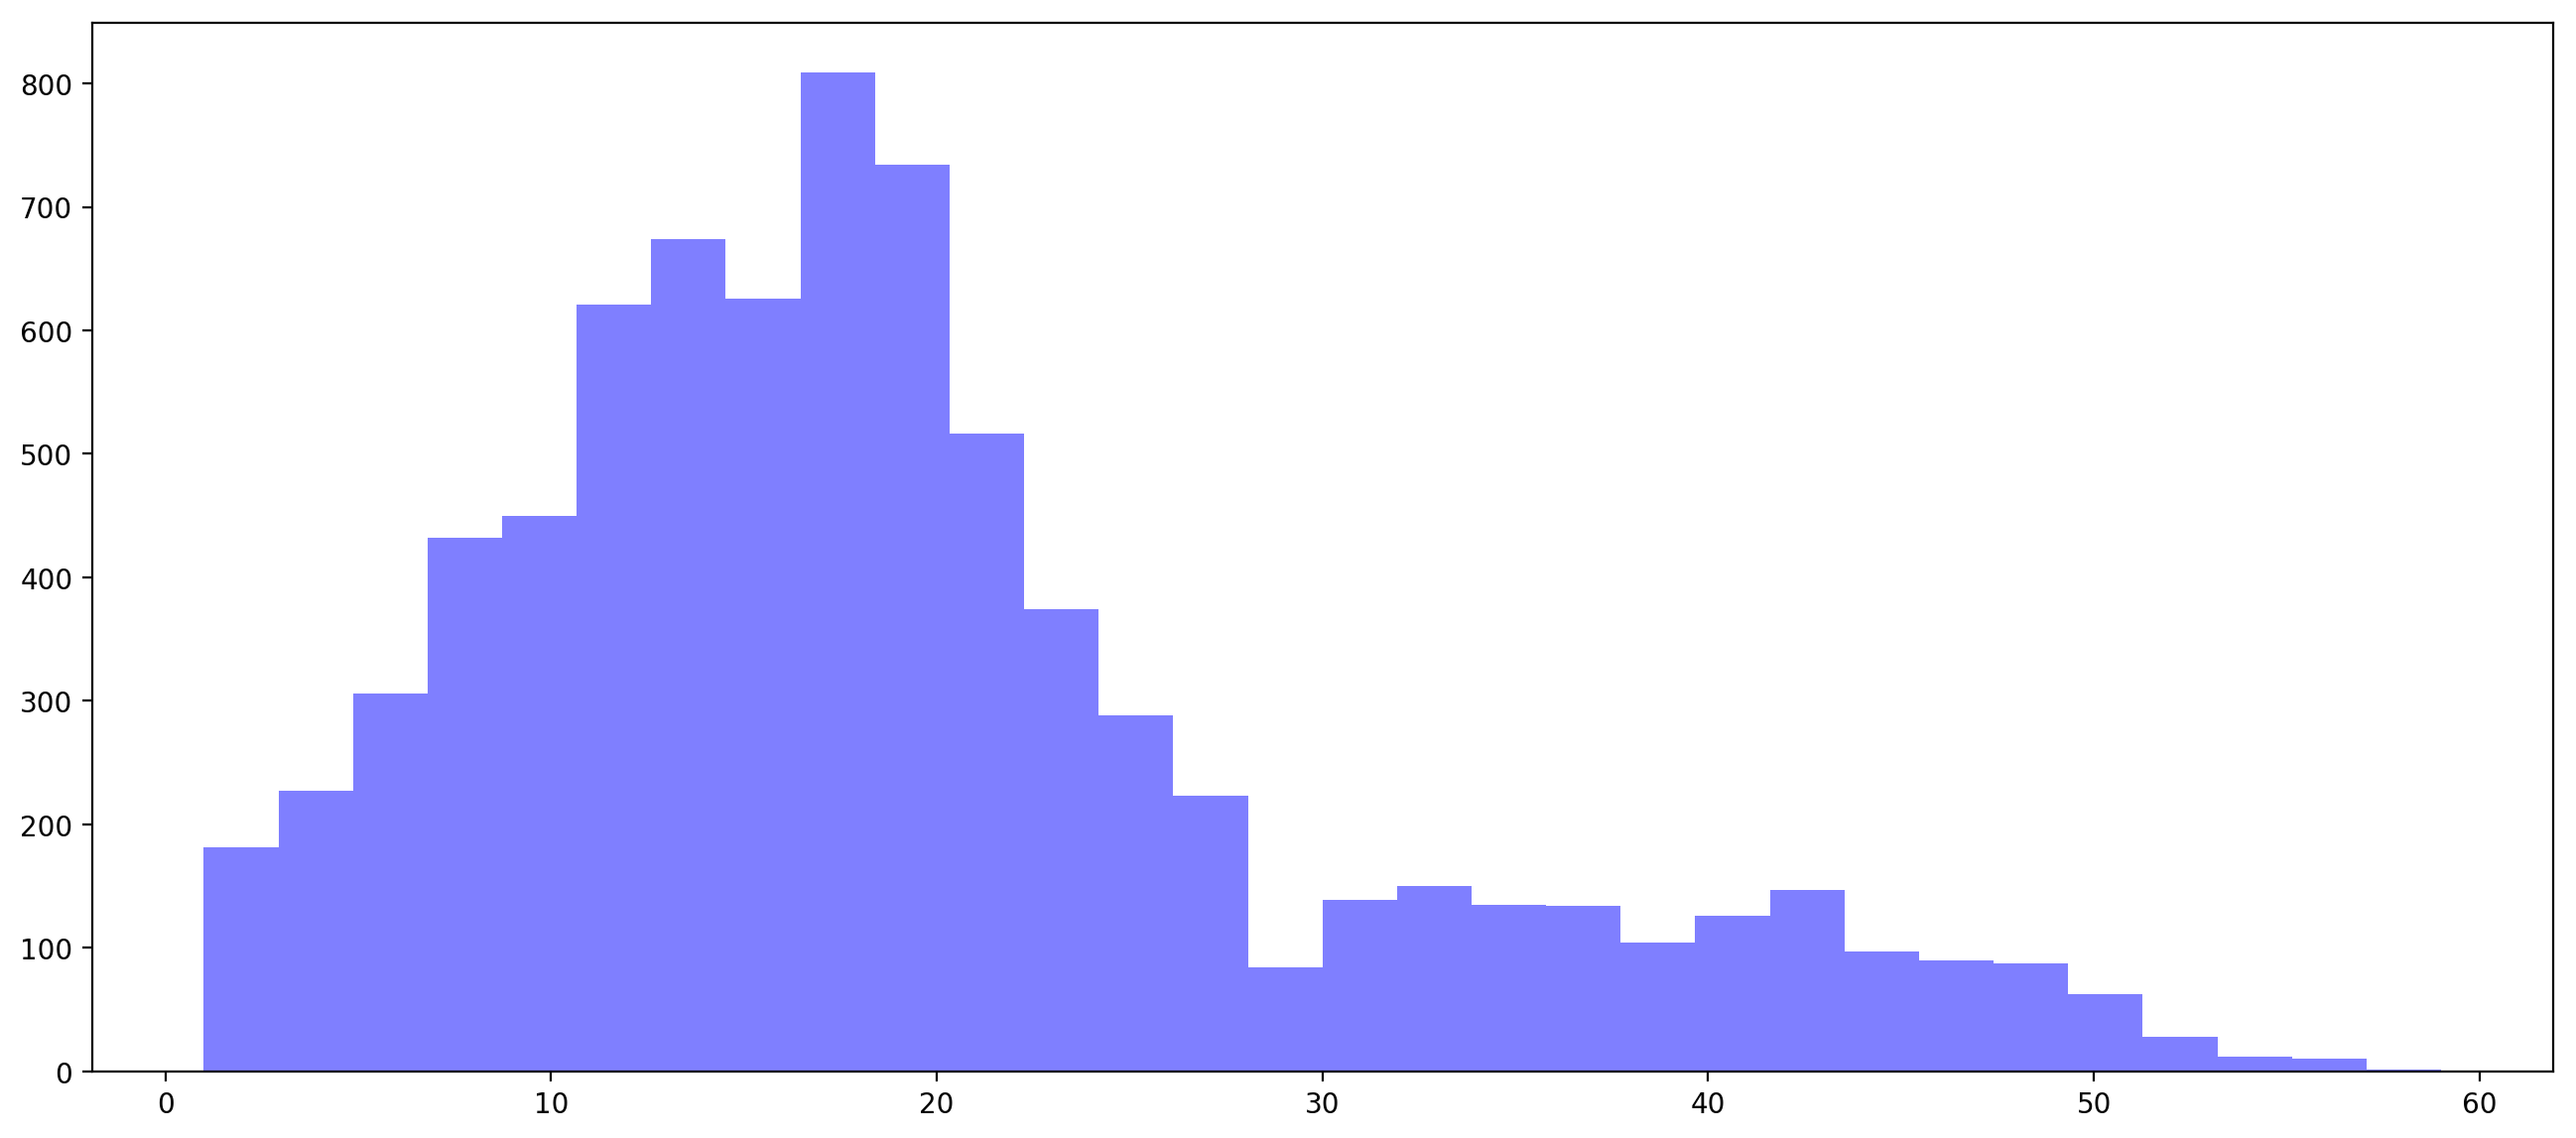

In [71]:
# NÚMERO DE PALABRAS
plt.hist(df.n_words, bins=30, facecolor='blue', alpha=0.5)

In [72]:
df['n_words10']=df['n_words'].apply(lambda x: int(bool(x<=10)))
df['n_words20']=df['n_words'].apply(lambda x: int(bool(x>10 and x<=20)))
df['n_words30']=df['n_words'].apply(lambda x: int(bool(x>20 and x<=30)))
df['n_words_mas30']=df['n_words'].apply(lambda x: int(bool(x>30)))

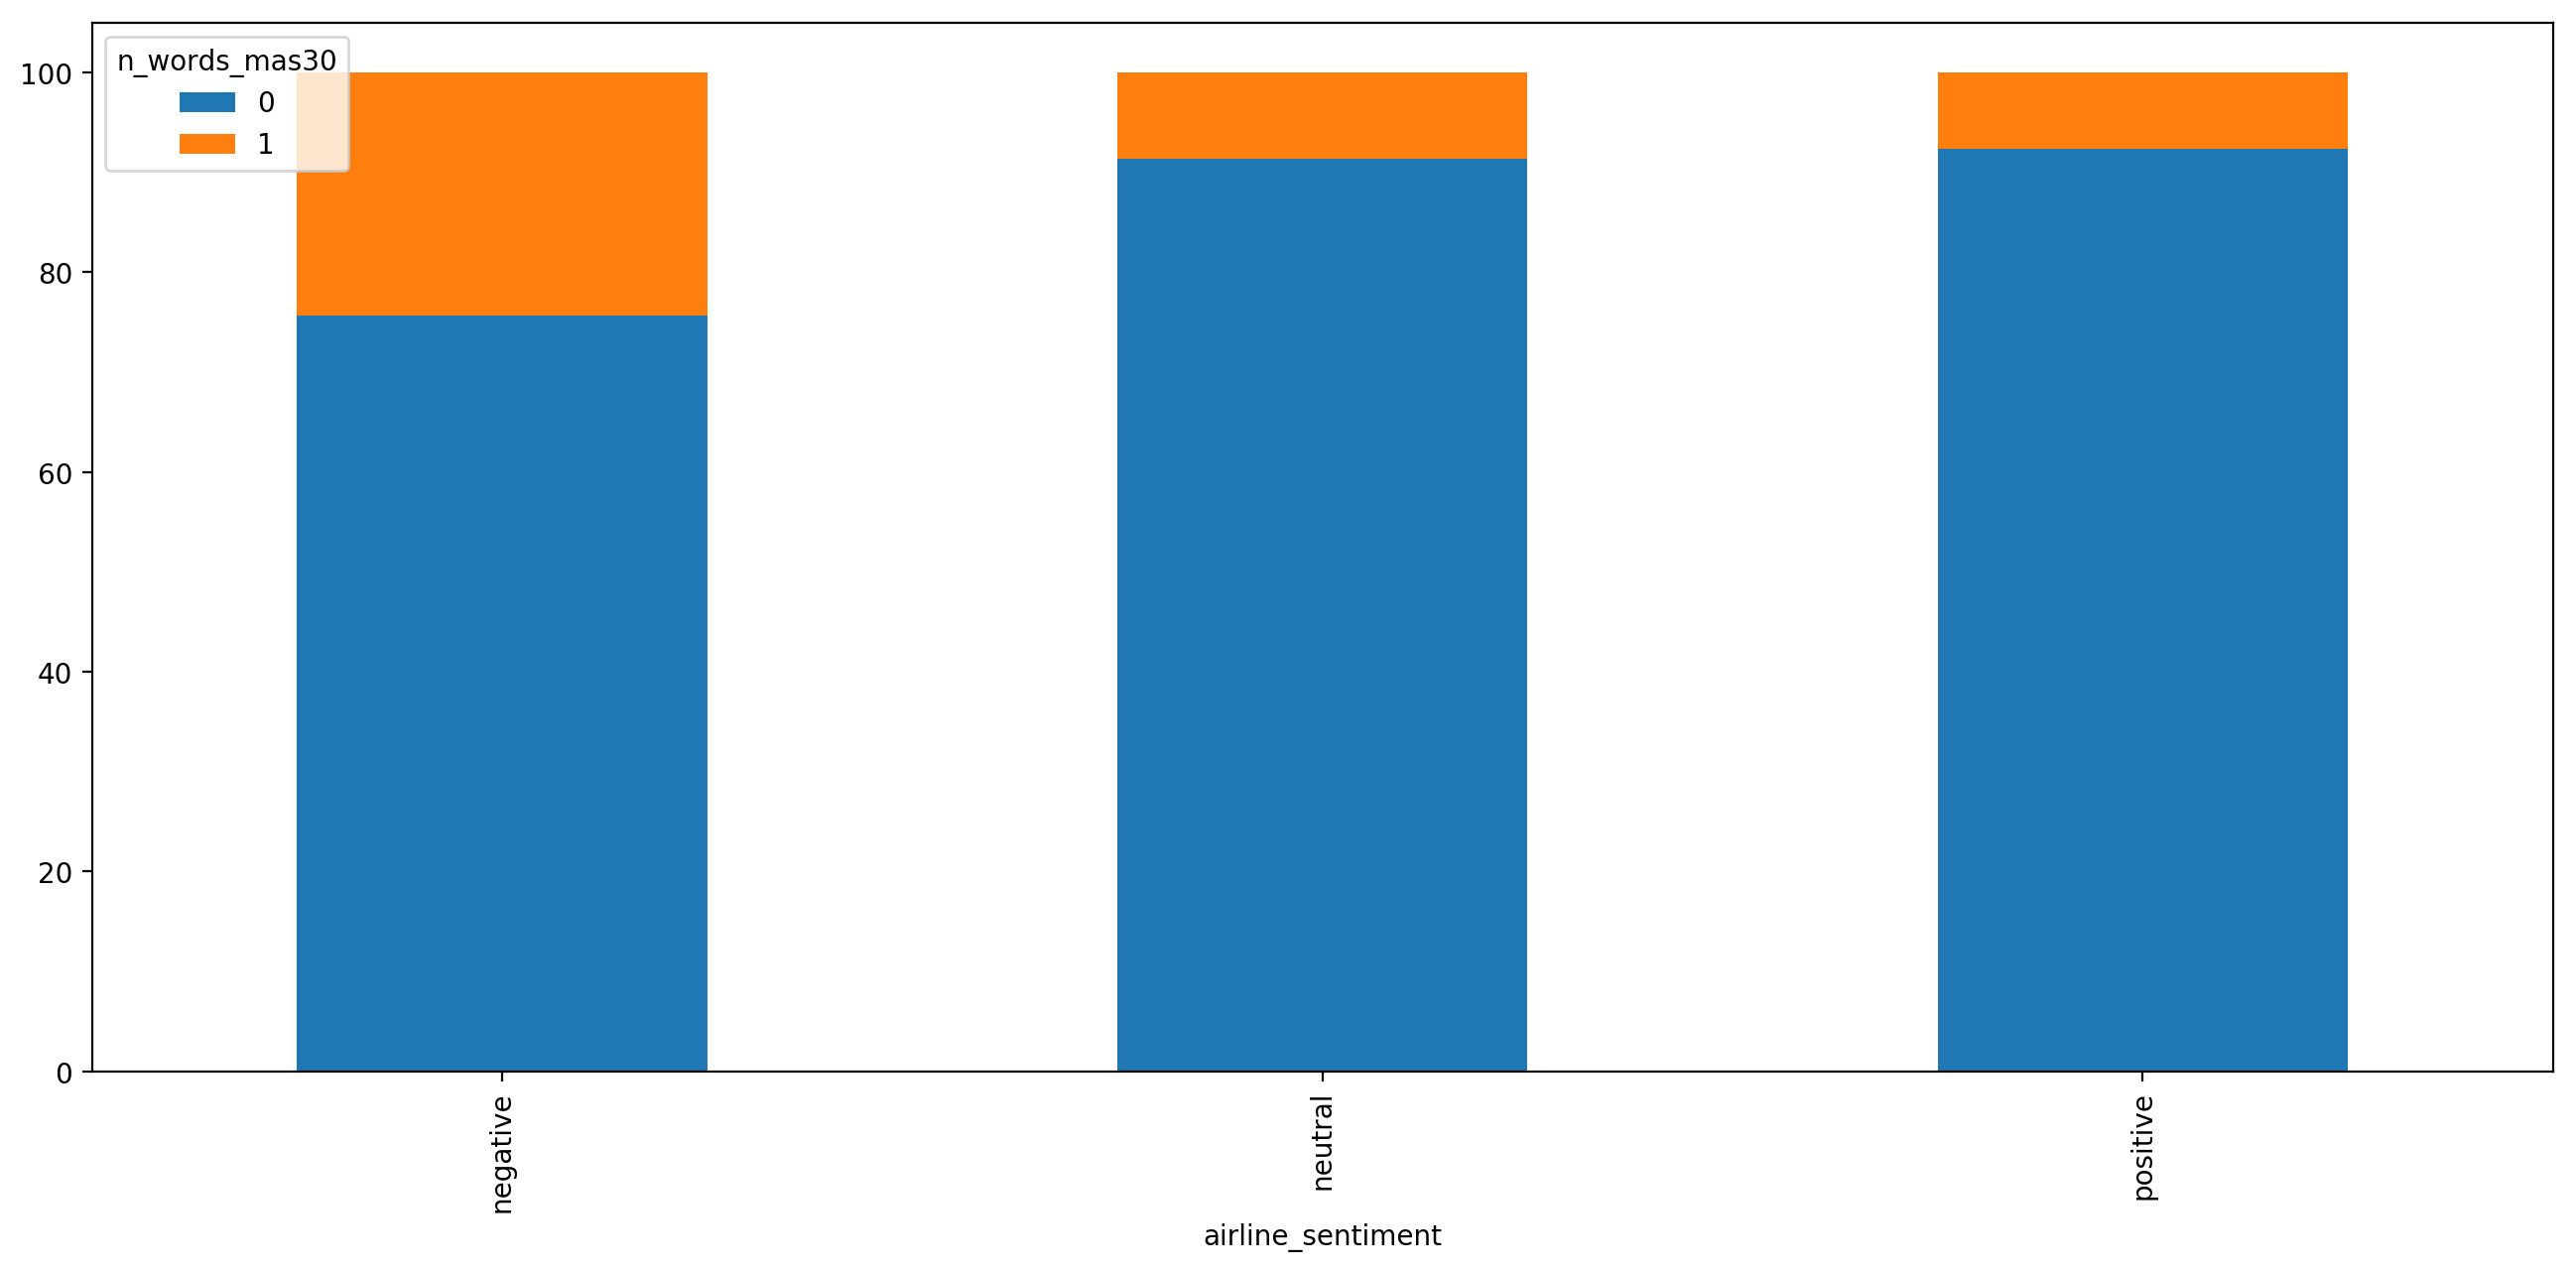

In [73]:
pd.crosstab(index=df['airline_sentiment'],columns=df['n_words_mas30']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

(array([ 0.,  0.,  1.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,
         6.,  0., 10.,  1.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0., 37.,
         0.,  1.,  0.,  1.]),
 array([20.        , 20.73333333, 21.46666667, 22.2       , 22.93333333,
        23.66666667, 24.4       , 25.13333333, 25.86666667, 26.6       ,
        27.33333333, 28.06666667, 28.8       , 29.53333333, 30.26666667,
        31.        , 31.73333333, 32.46666667, 33.2       , 33.93333333,
        34.66666667, 35.4       , 36.13333333, 36.86666667, 37.6       ,
        38.33333333, 39.06666667, 39.8       , 40.53333333, 41.26666667,
        42.        ]),
 <a list of 30 Patch objects>)

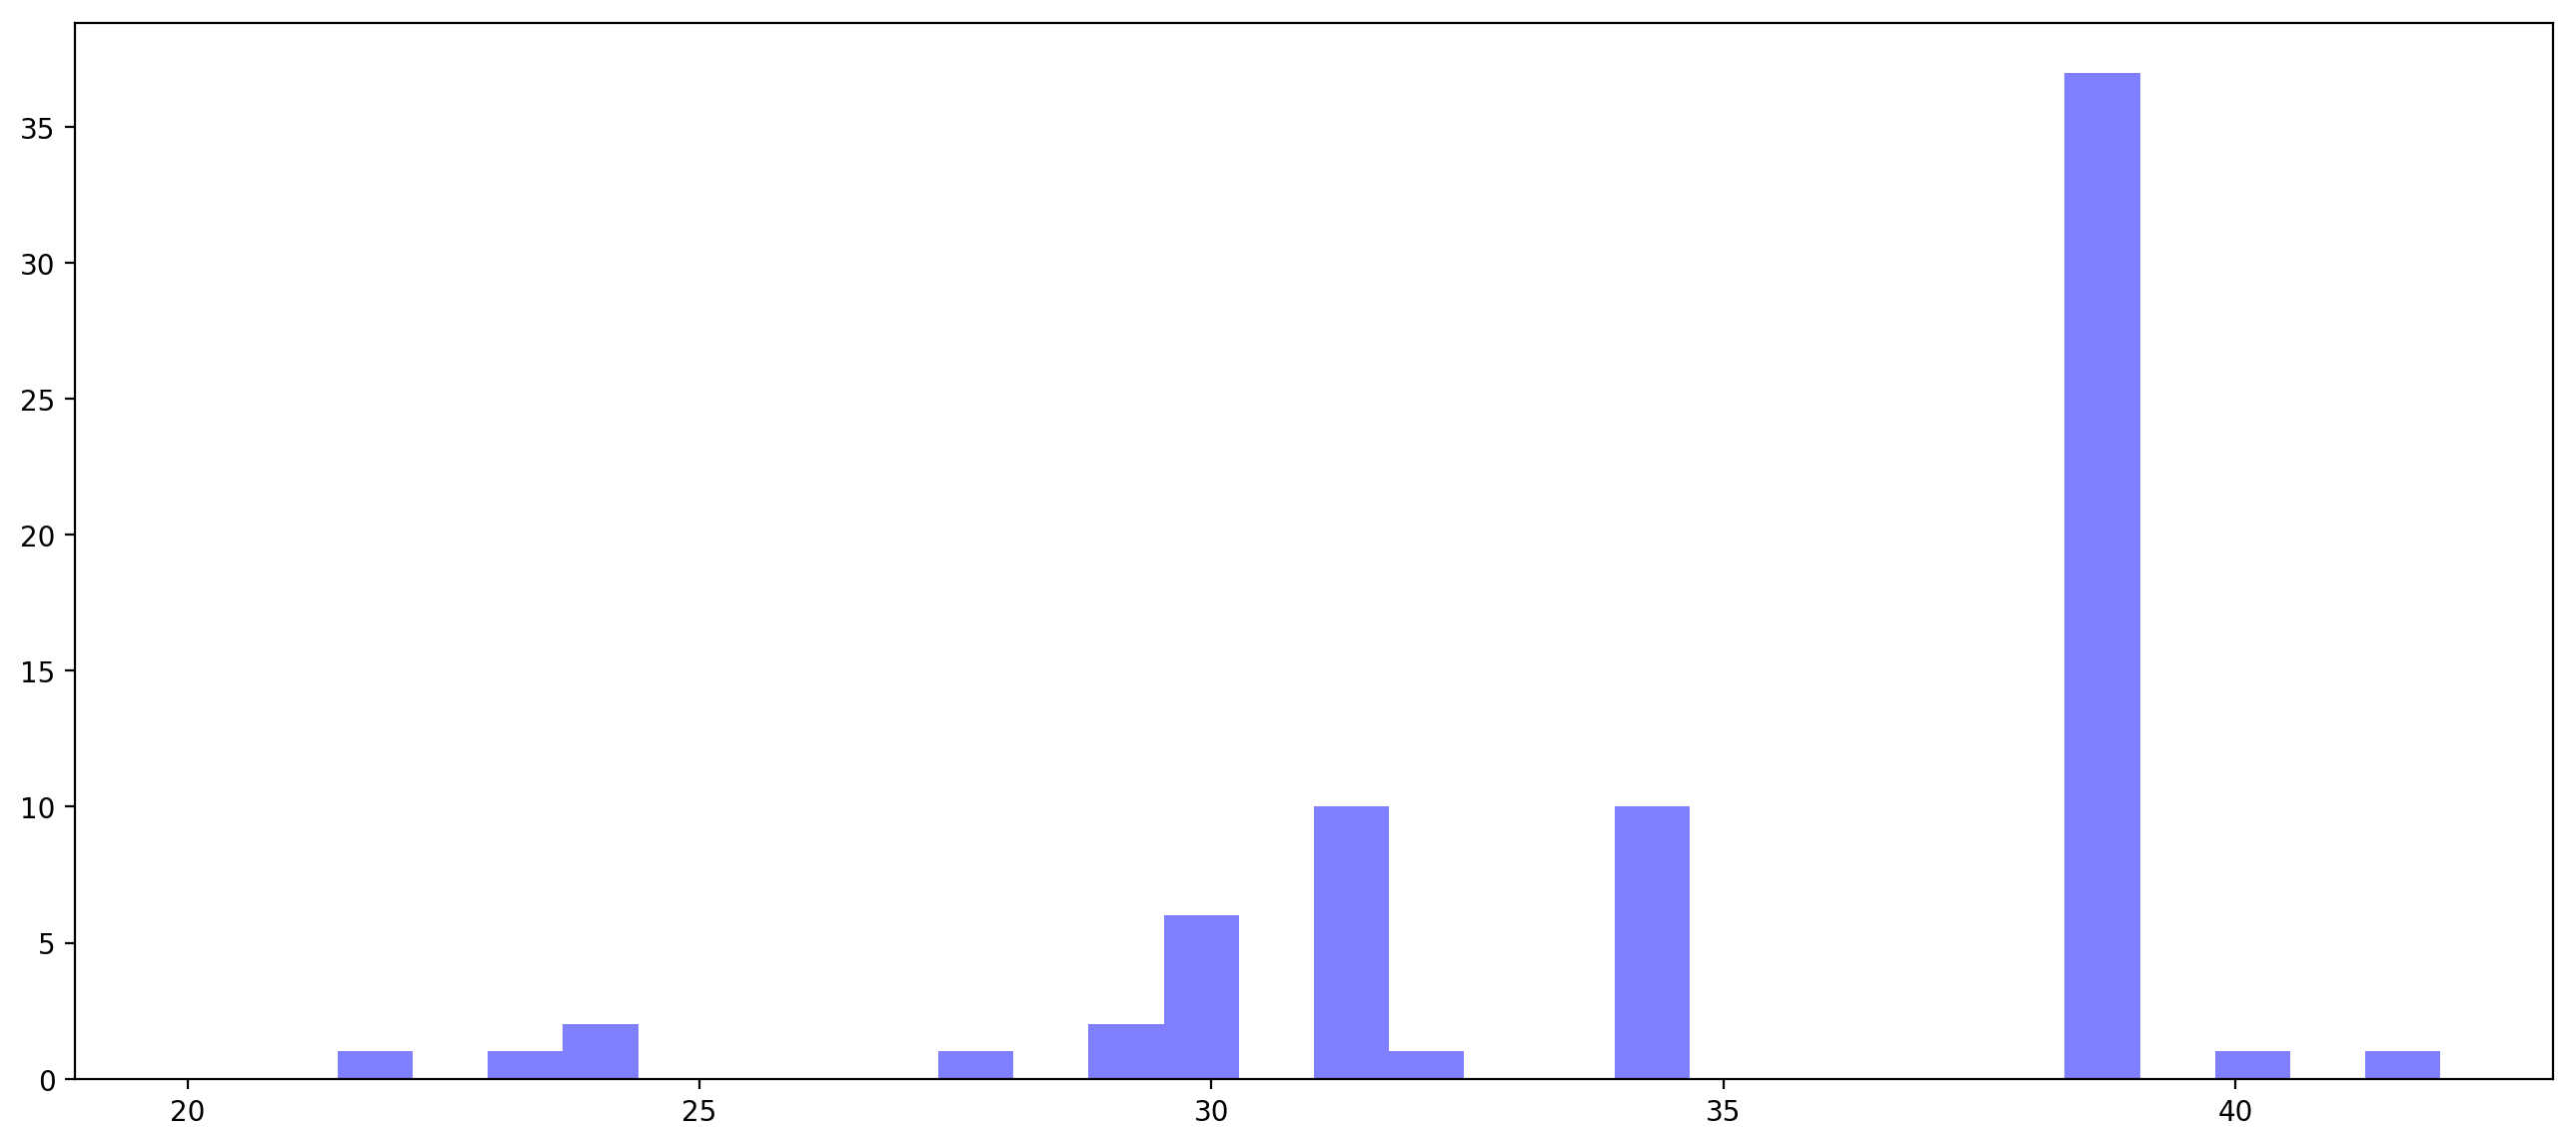

In [74]:
# NÚMERO DE PALABRAS
plt.hist(df.n_words_mayus, bins=30, facecolor='blue', alpha=0.5, range=(20,42))

In [75]:
df['mayus_si']=df['n_words_mayus'].apply(lambda x: int(bool(x>0)))
print(df['mayus_si'].value_counts())

0    6160
1    1707
Name: mayus_si, dtype: int64


In [76]:
df['mayus_si1']=df['n_words_mayus'].apply(lambda x: int(bool(x==1)))
df['mayus_si2mas']=df['n_words_mayus'].apply(lambda x: int(bool(x>1)))

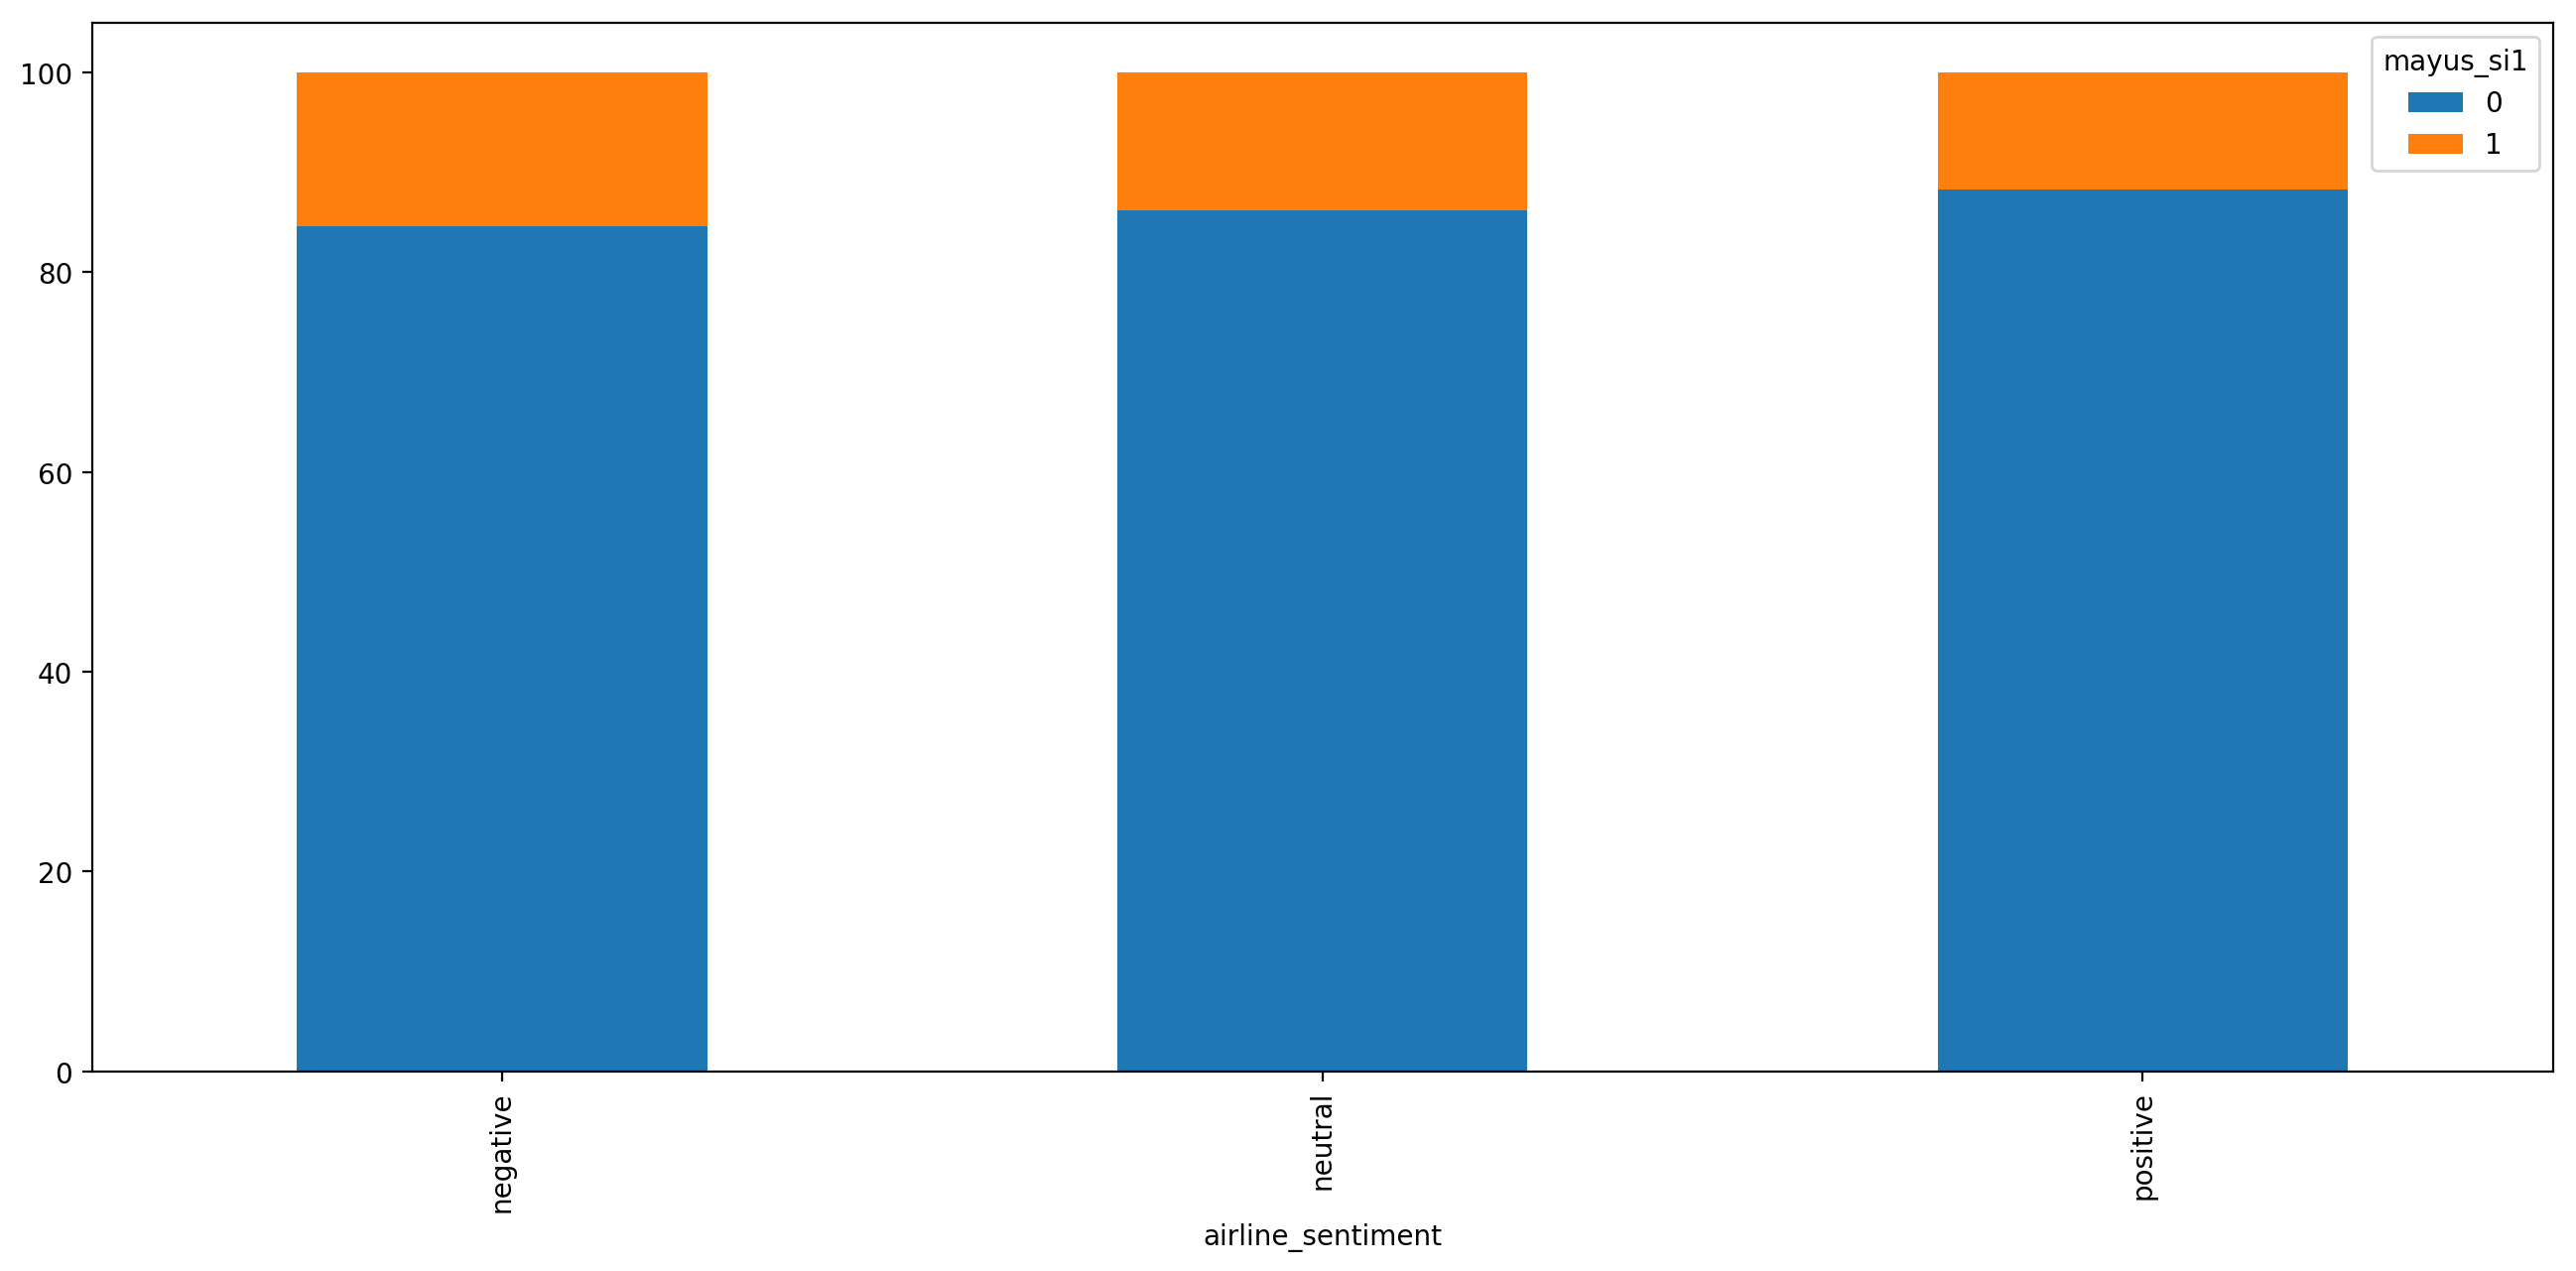

In [77]:
pd.crosstab(index=df['airline_sentiment'],columns=df['mayus_si1']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

(array([1.071e+03, 0.000e+00, 2.740e+02, 0.000e+00, 0.000e+00, 6.000e+01,
        0.000e+00, 0.000e+00, 4.300e+01, 0.000e+00, 1.900e+01, 0.000e+00,
        0.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  0.36666667,  0.73333333,  1.1       ,  1.46666667,
         1.83333333,  2.2       ,  2.56666667,  2.93333333,  3.3       ,
         3.66666667,  4.03333333,  4.4       ,  4.76666667,  5.13333333,
         5.5       ,  5.86666667,  6.23333333,  6.6       ,  6.96666667,
         7.33333333,  7.7       ,  8.06666667,  8.43333333,  8.8       ,
         9.16666667,  9.53333333,  9.9       , 10.26666667, 10.63333333,
        11.        ]),
 <a list of 30 Patch objects>)

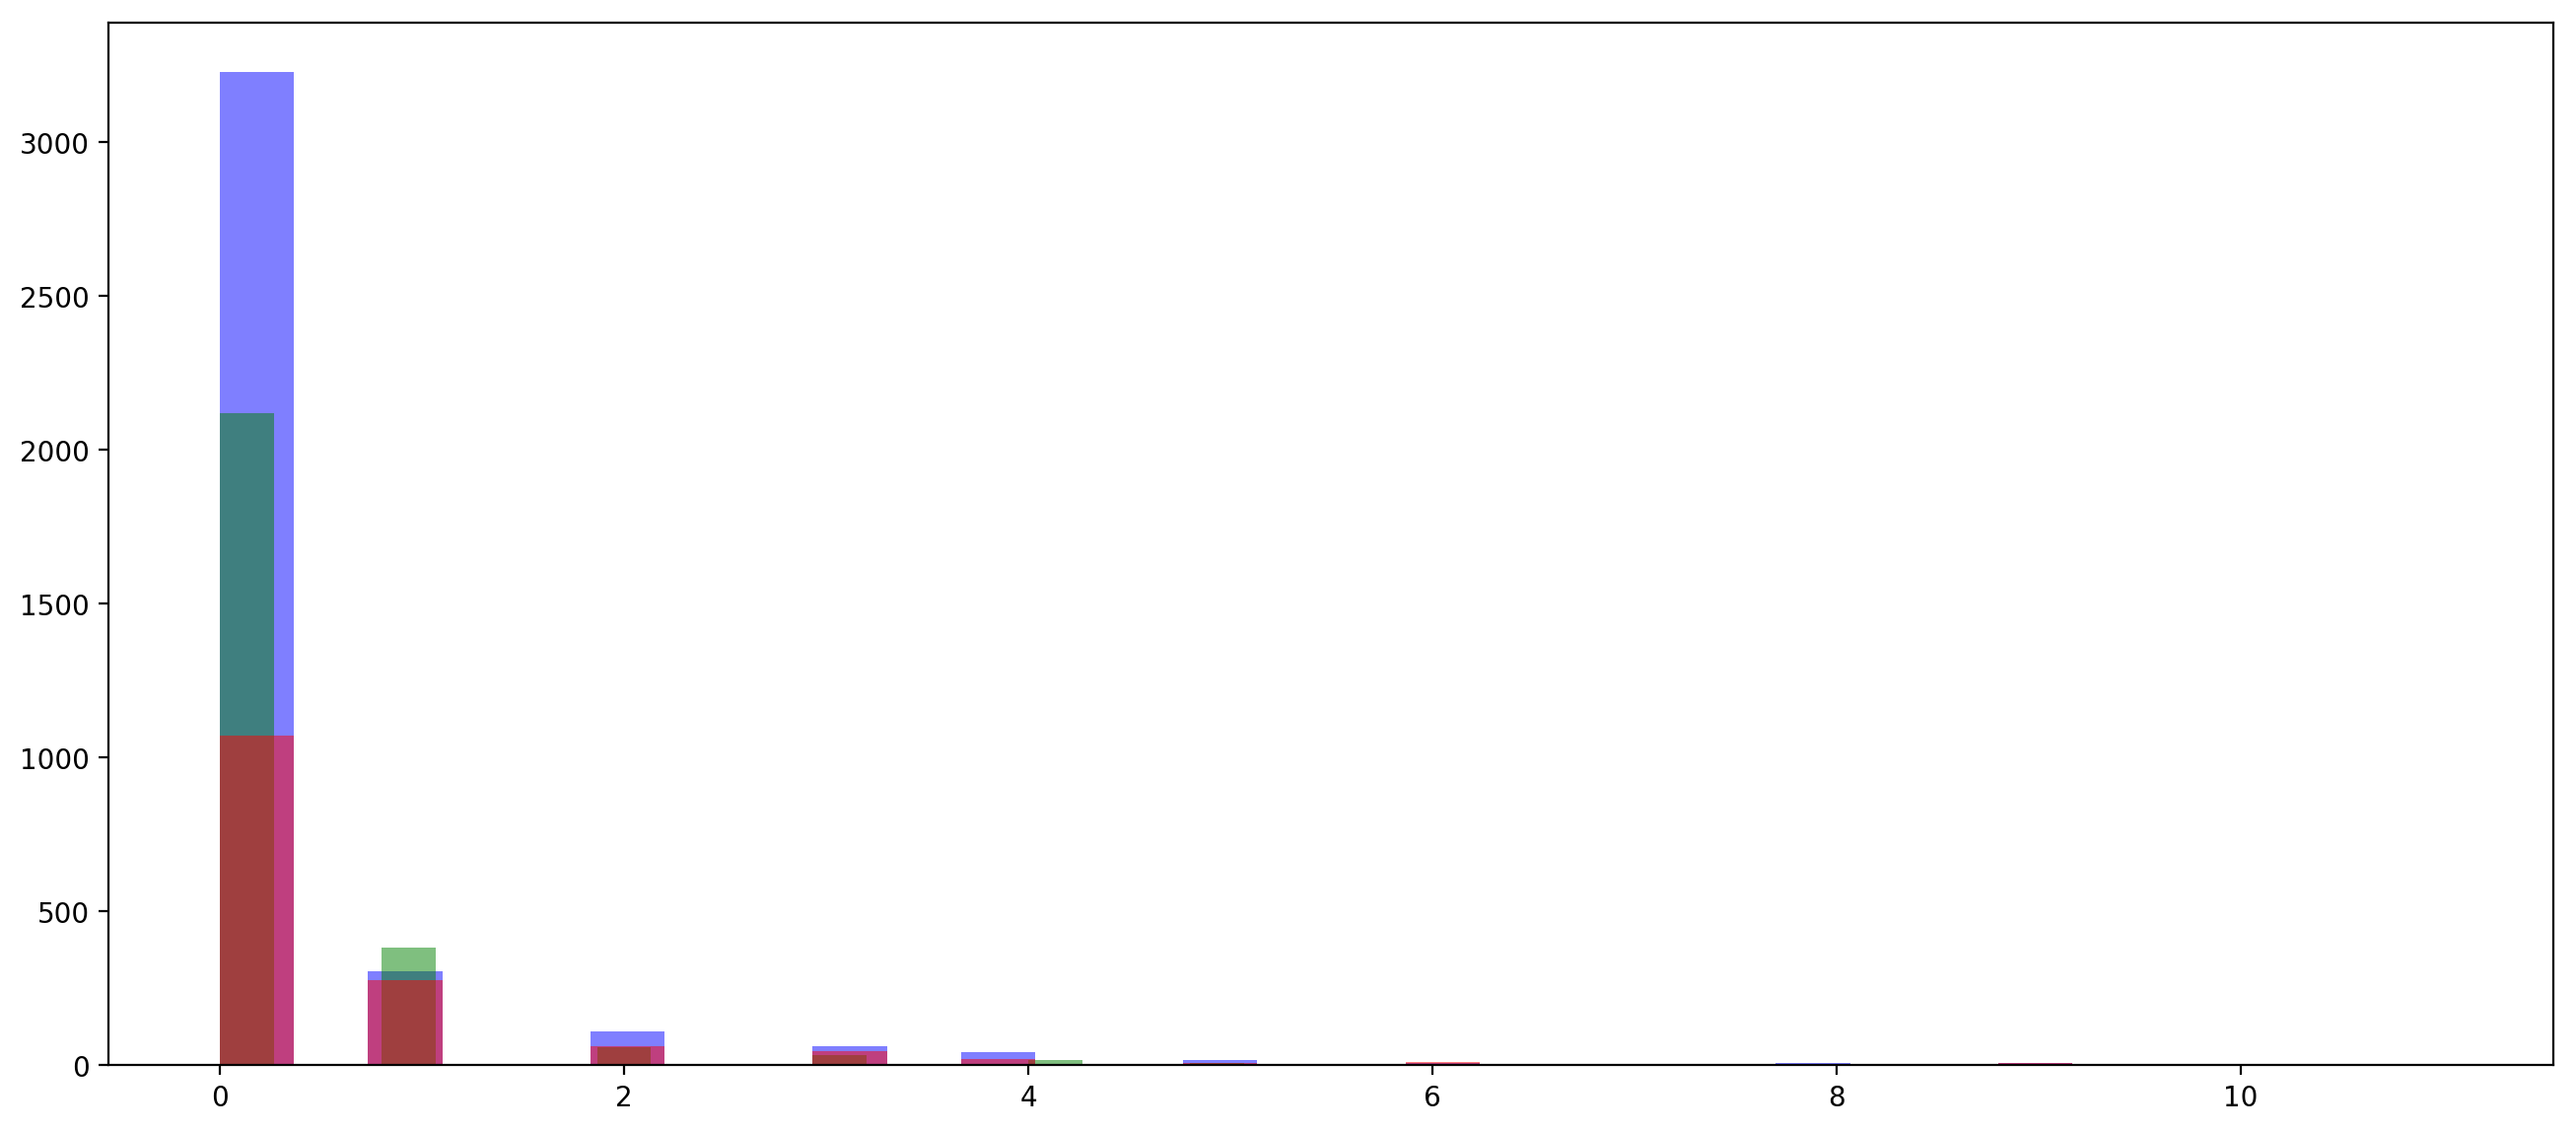

In [78]:
plt.hist(df_negative.n_exclamations, bins=30, facecolor='blue', alpha=0.5)
plt.hist(df_neutral.n_exclamations, bins=30, facecolor='green', alpha=0.5)
plt.hist(df_positive.n_exclamations, bins=30, facecolor='red', alpha=0.5)

(array([1433.,    0.,    0.,    0.,    0.,    0.,    0.,   43.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    8.,    0.,    0.,
           0.,    0.,    0.,    0.,    3.,    0.,    0.,    0.,    0.,
           0.,    0.,    2.]),
 array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
        0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ,
        1.33333333, 1.46666667, 1.6       , 1.73333333, 1.86666667,
        2.        , 2.13333333, 2.26666667, 2.4       , 2.53333333,
        2.66666667, 2.8       , 2.93333333, 3.06666667, 3.2       ,
        3.33333333, 3.46666667, 3.6       , 3.73333333, 3.86666667,
        4.        ]),
 <a list of 30 Patch objects>)

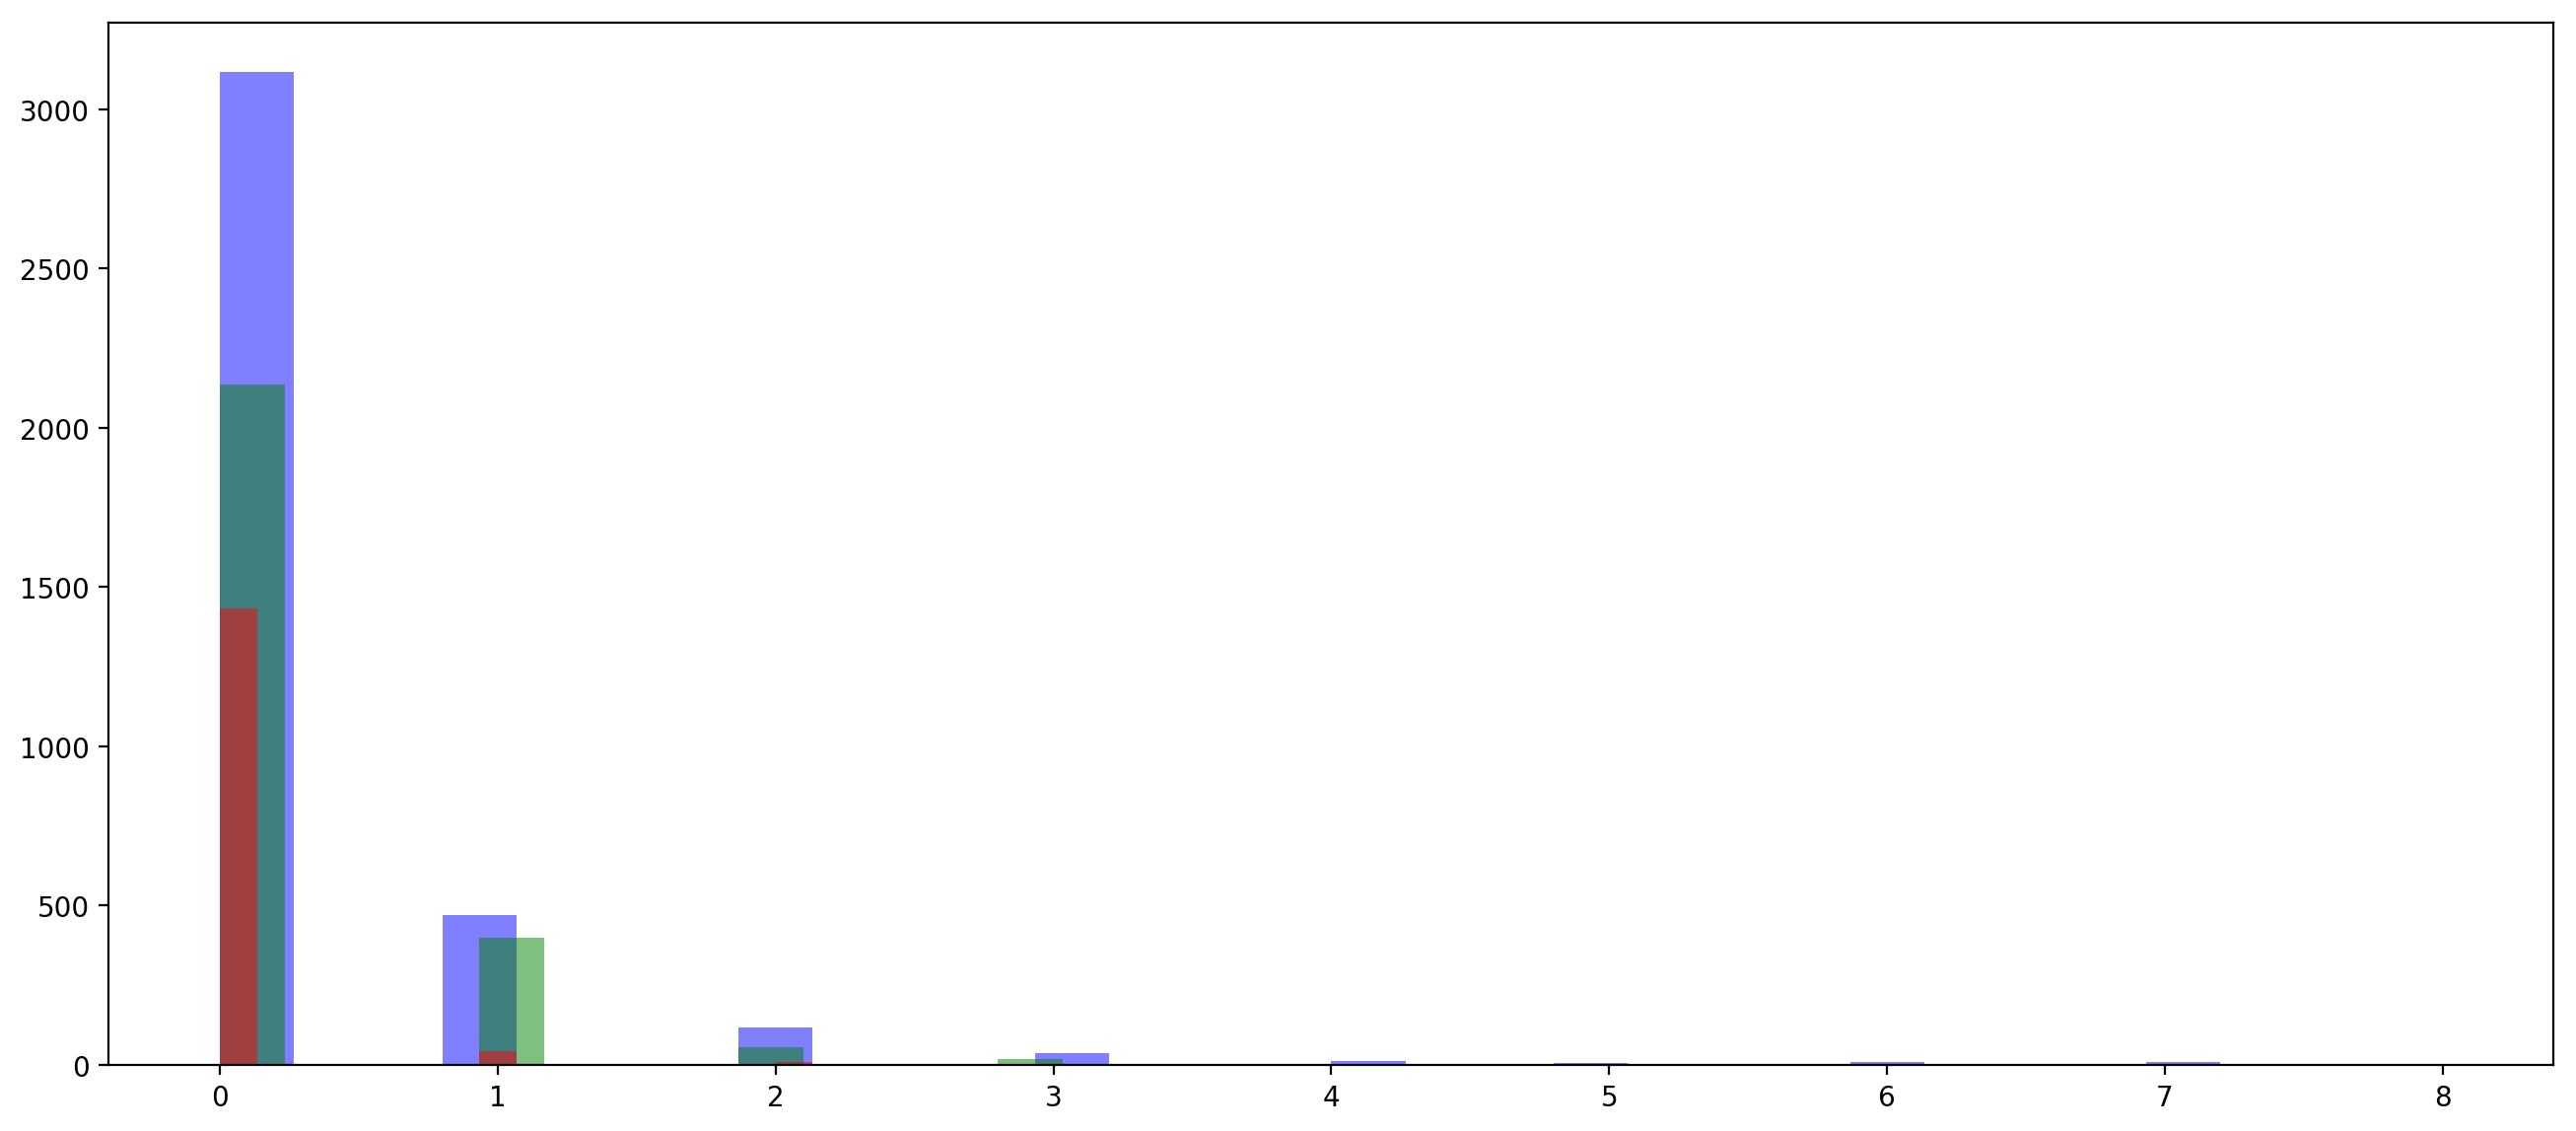

In [79]:
plt.hist(df_negative.n_questions, bins=30, facecolor='blue', alpha=0.5)
plt.hist(df_neutral.n_questions, bins=30, facecolor='green', alpha=0.5)
plt.hist(df_positive.n_questions, bins=30, facecolor='red', alpha=0.5)

(array([1.334e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.380e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.100e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. ]),
 <a list of 30 Patch objects>)

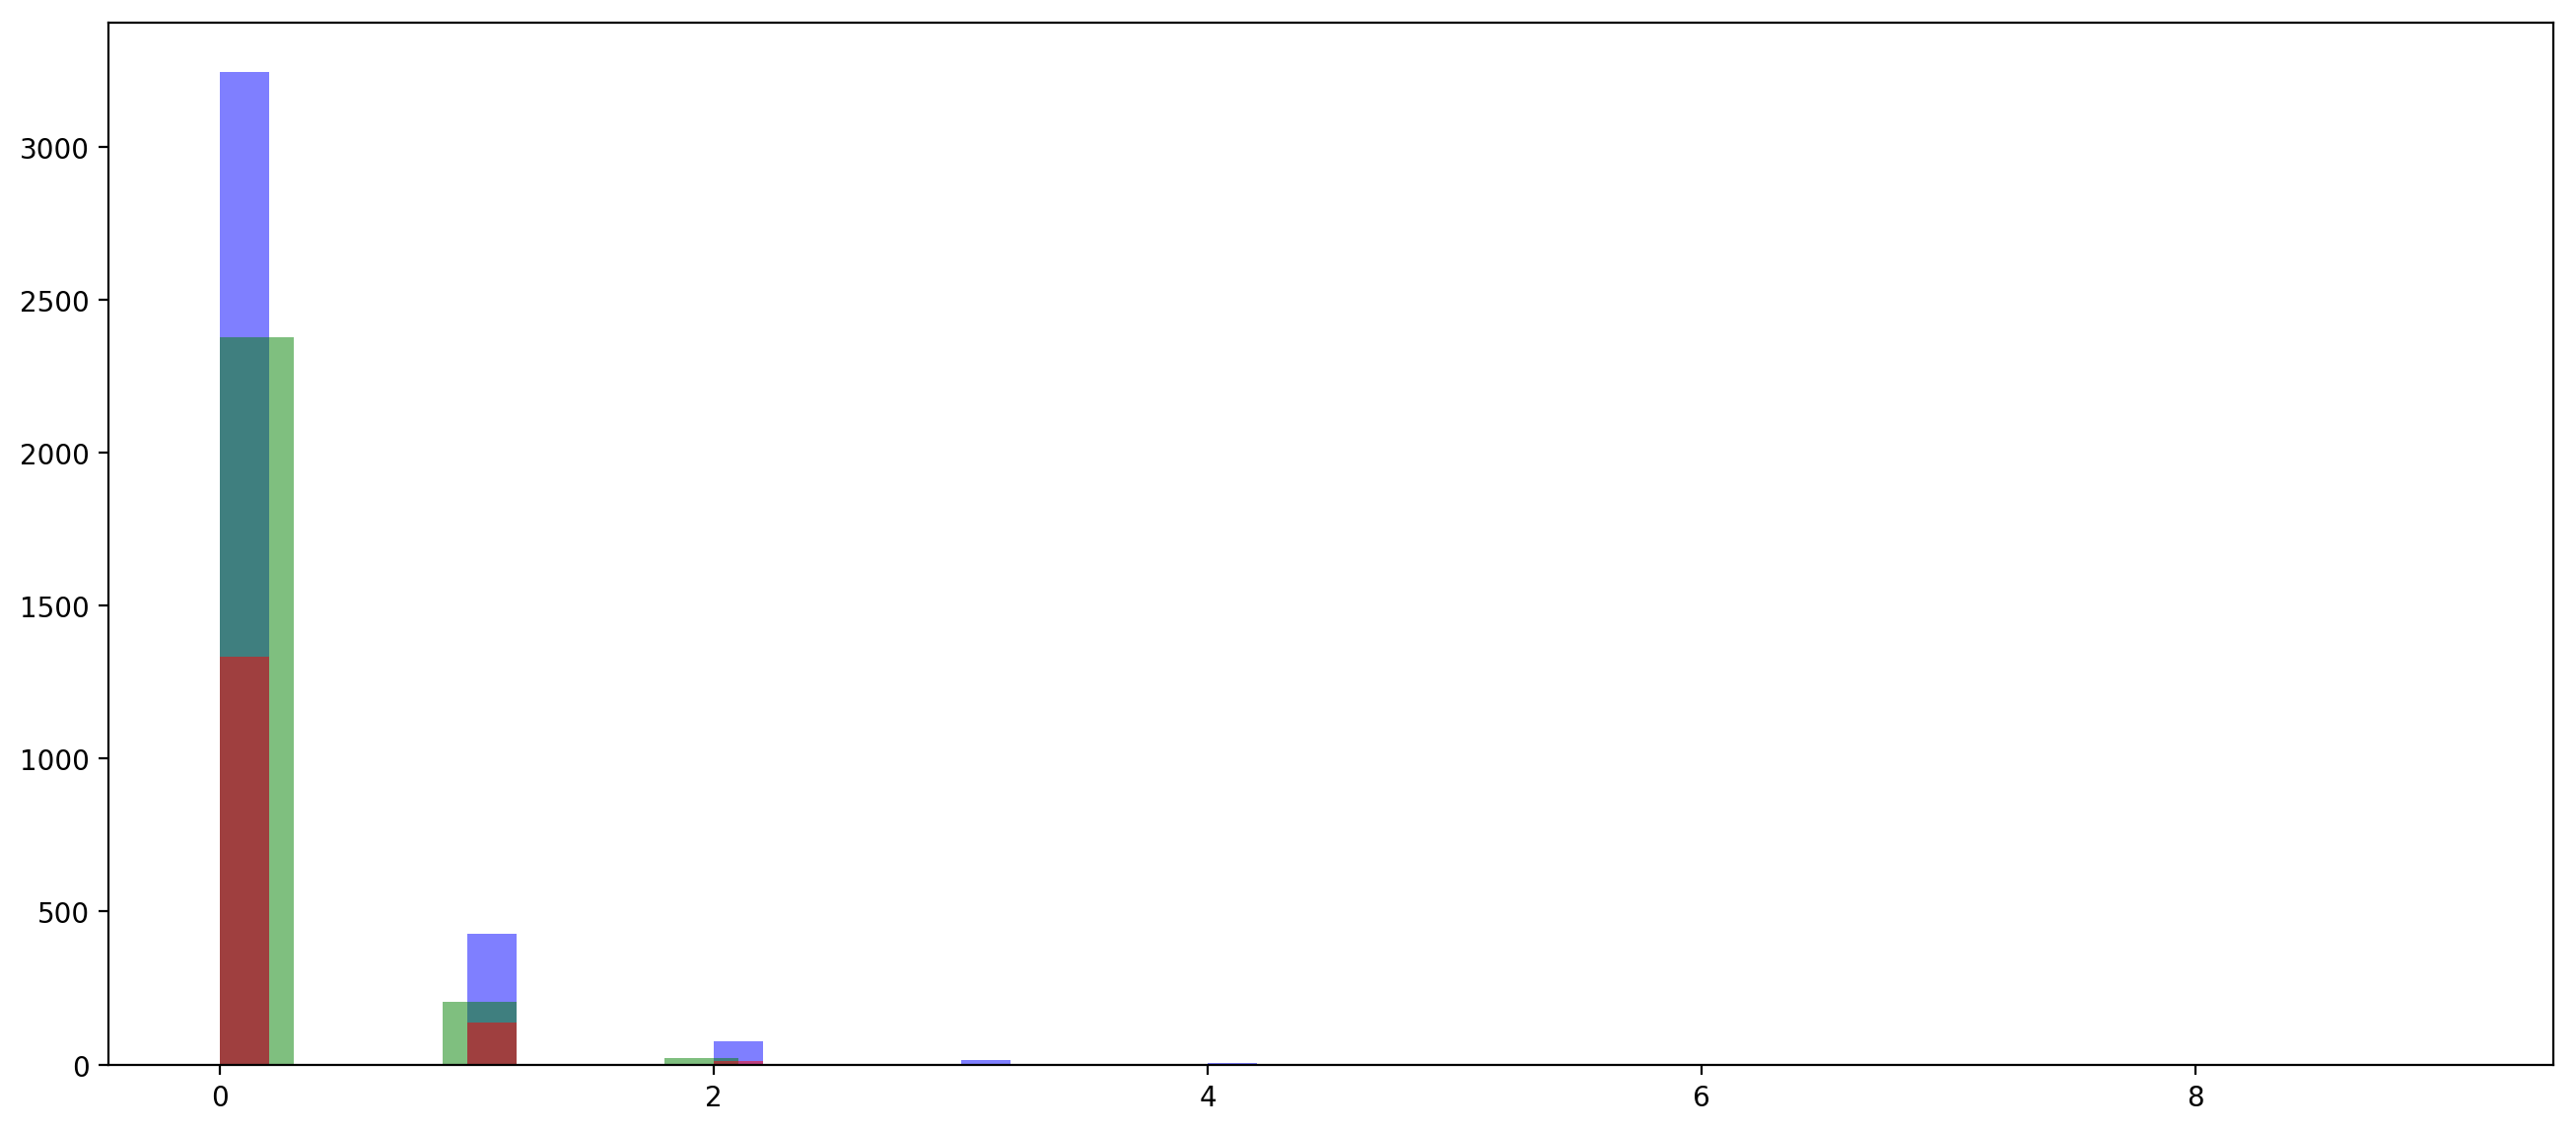

In [80]:
plt.hist(df_negative.n_suspensivos, bins=30, facecolor='blue', alpha=0.5)
plt.hist(df_neutral.n_suspensivos, bins=30, facecolor='green', alpha=0.5)
plt.hist(df_positive.n_suspensivos, bins=30, facecolor='red', alpha=0.5)

In [81]:
df['exclamations_si']=np.where(df['n_exclamations']>0,1,0)
df['questions_si']=np.where(df['n_questions']>0,1,0)
df['suspensivos_si']=np.where(df['n_suspensivos']>0,1,0)

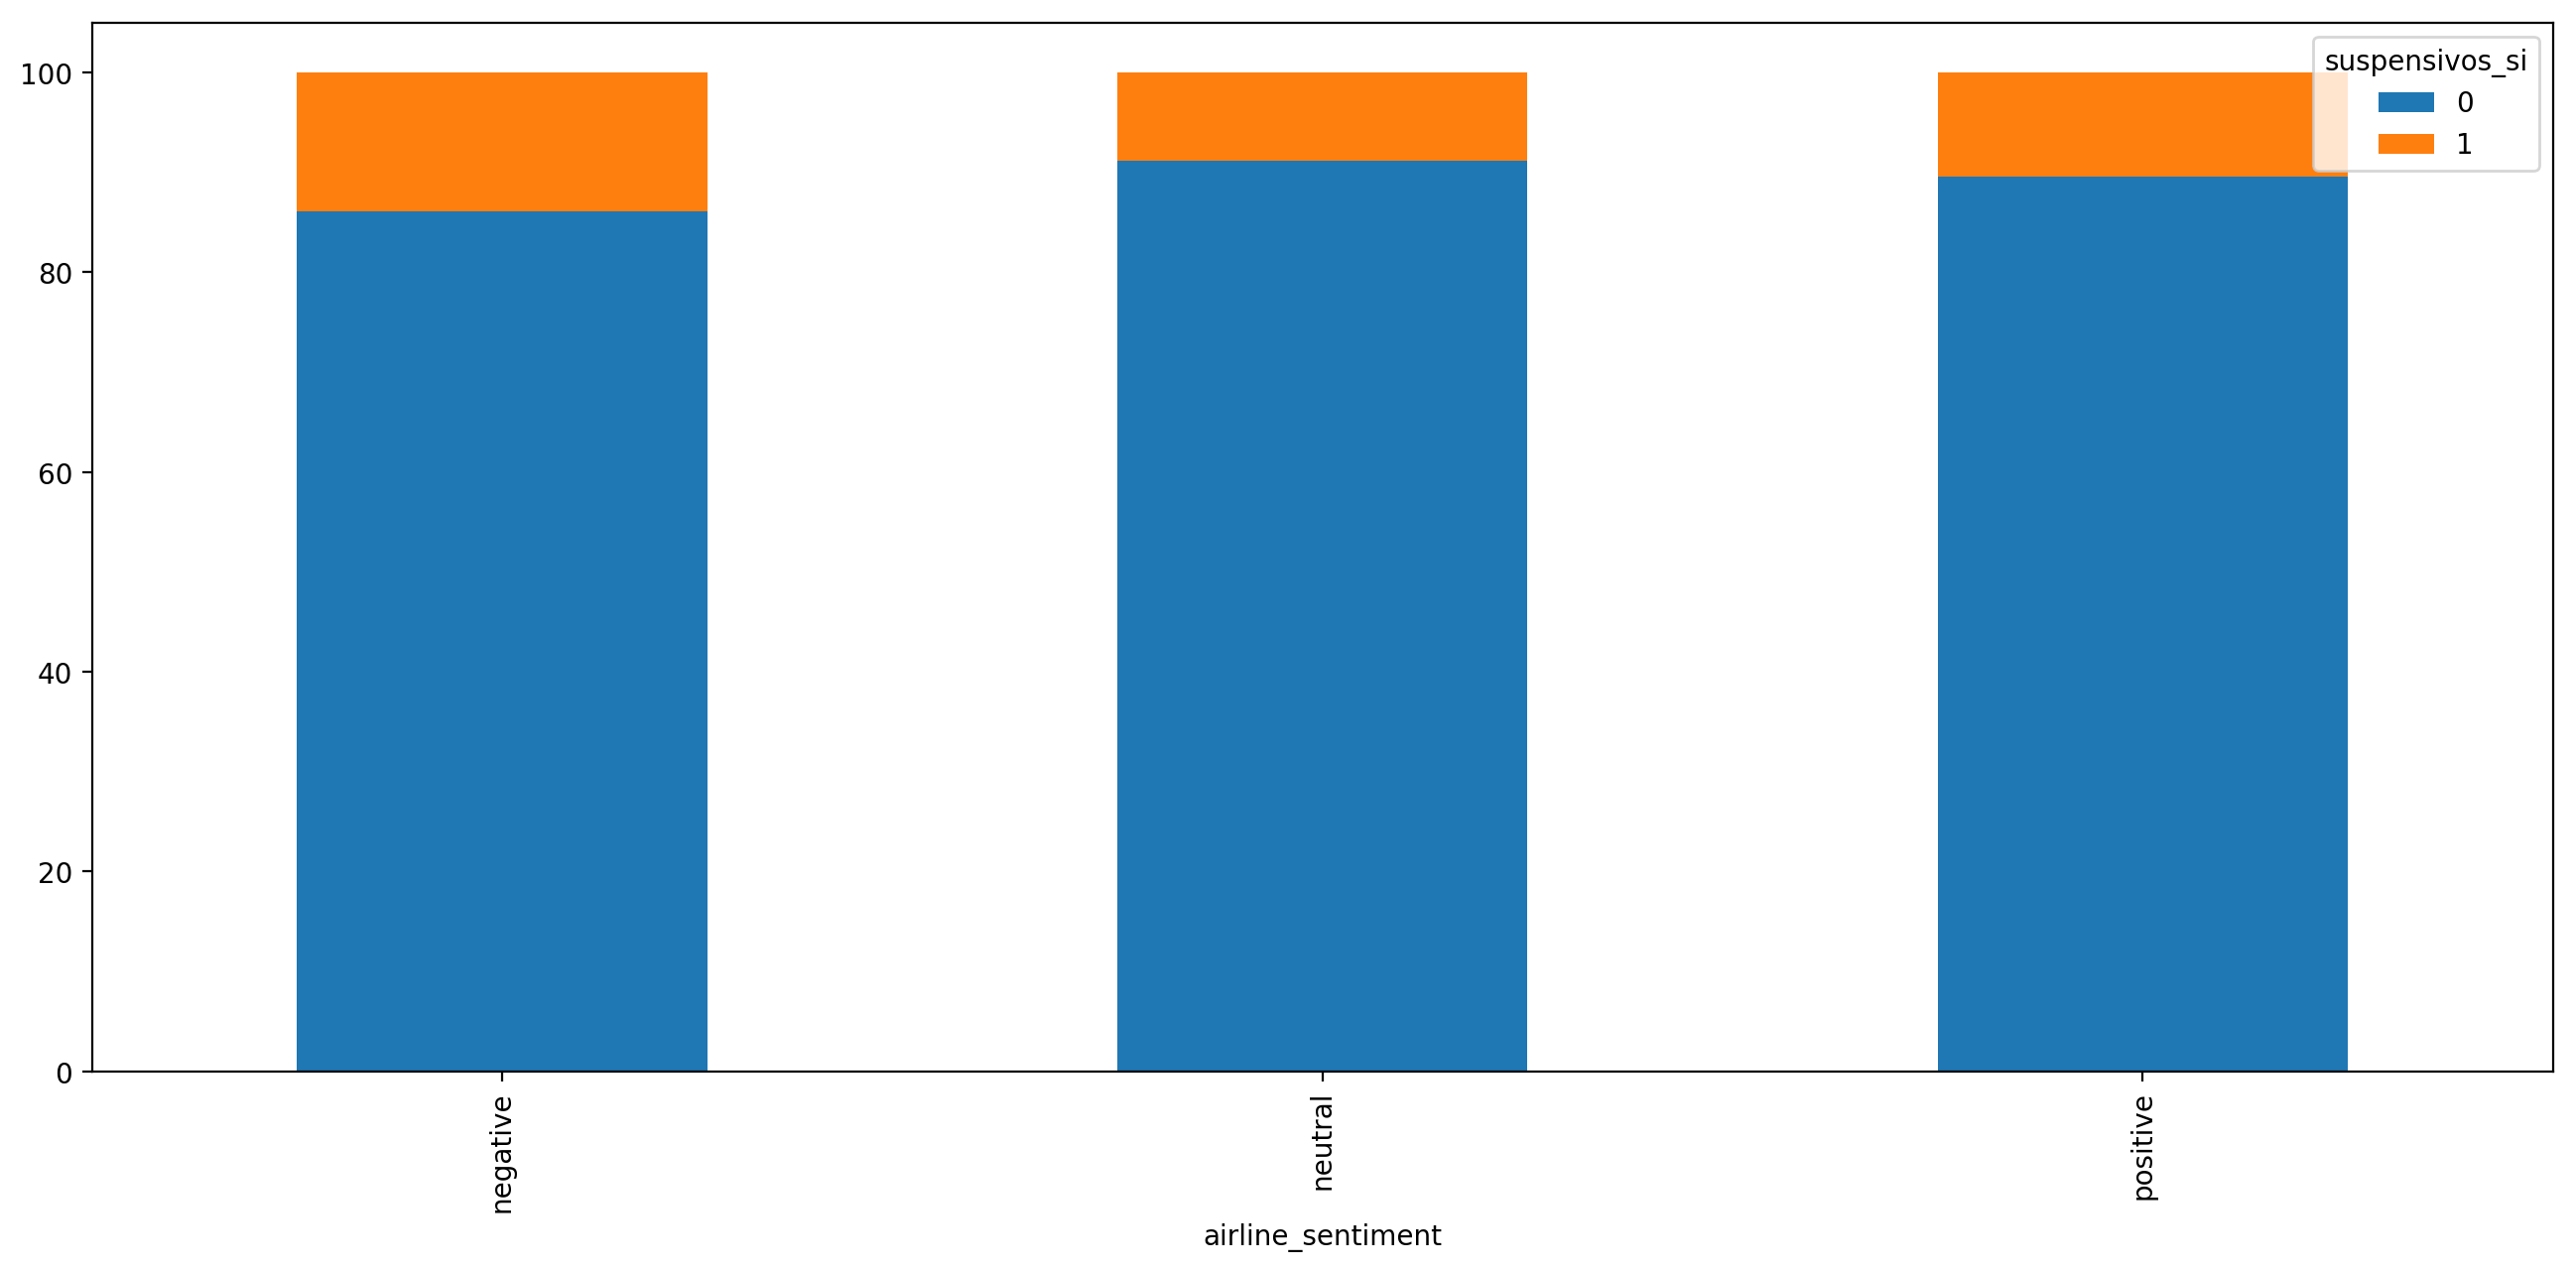

In [82]:
pd.crosstab(index=df['airline_sentiment'],columns=df['suspensivos_si']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Análisis de Emoticonos

In [83]:
emo_pol=pd.read_excel('Lista y polaridad emojis mejorado.xlsx',dtype={'Unicode_limpio':'str'})
emo_pol.info()
emo_pol['Unicode_limpio']=emo_pol['Unicode_limpio'].str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 6 columns):
Unicode           190 non-null object
emoji             0 non-null float64
description       190 non-null object
words             189 non-null object
sentiment         161 non-null object
Unicode_limpio    190 non-null object
dtypes: float64(1), object(5)
memory usage: 9.0+ KB


In [84]:
# Cambiamos el formato de la columna para que no de problemas
from ast import literal_eval
df.loc[:,'emoticon_reformat']=df.loc[:,'emoticon'].apply(lambda x: literal_eval(x))

In [85]:
df['n_posit_emo']=0
df['n_negat_emo']=0
df['n_neutr_emo']=0

for i in df.index:
    for emot in df['emoticon_reformat'][i]:
        for j in range(len(emo_pol.Unicode_limpio)):
            if emot == emo_pol.Unicode_limpio[j]:
                if emo_pol.sentiment[j] == 'positive':
                    df.set_value(i,'n_posit_emo',df['n_posit_emo'][i] + 1,takeable=False)
                if emo_pol.sentiment[j] == 'negative':
                    df.set_value(i,'n_negat_emo',df['n_negat_emo'][i] + 1,takeable=False)
                if emo_pol.sentiment[j] == 'neutral':
                    df.set_value(i,'n_neutr_emo',df['n_neutr_emo'][i] + 1,takeable=False)


In [87]:
print(df.groupby('n_posit_emo').size())
print(df.groupby('n_negat_emo').size())
print(df.groupby('n_neutr_emo').size())

n_posit_emo
0     7414
1     246 
2     90  
3     58  
4     25  
5     16  
6     10  
7     3   
8     3   
9     1   
18    1   
dtype: int64
n_negat_emo
0     7666
1     127 
2     23  
3     40  
4     5   
6     2   
8     2   
12    1   
14    1   
dtype: int64
n_neutr_emo
0    7863
1    4   
dtype: int64


In [88]:
df['emo_pos_si']=df['n_posit_emo'].apply(lambda x: int(bool(x>0)))

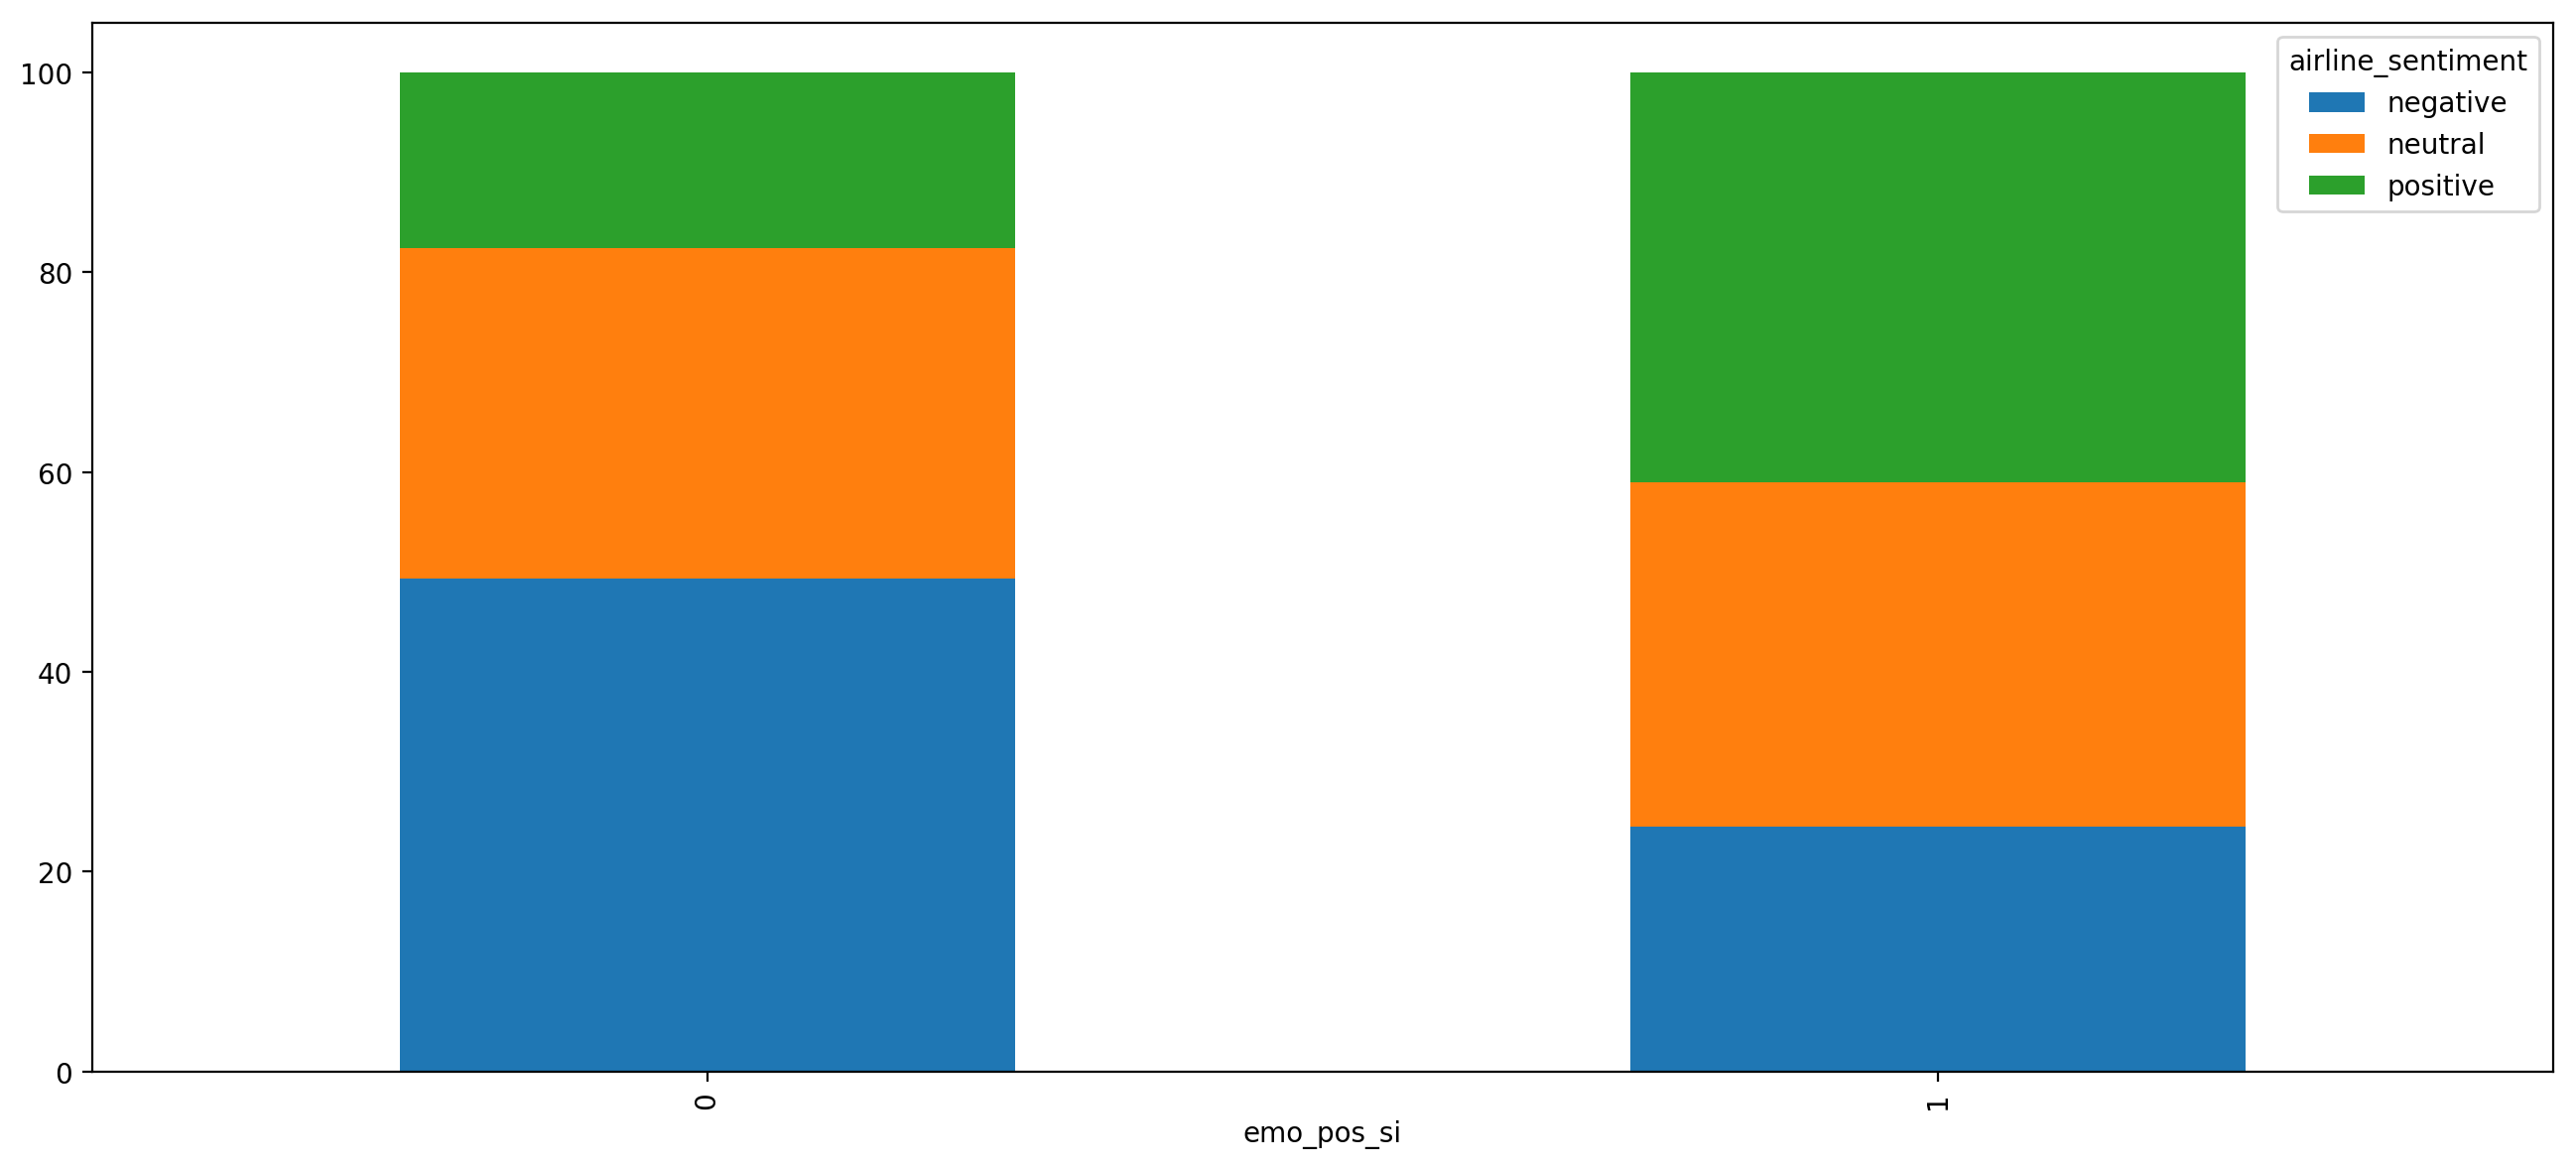

In [89]:
pd.crosstab(index=df['emo_pos_si'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

In [90]:
df['emo_si']=df['emoticon_reformat'].apply(lambda d:int(bool(len(d)>0)))

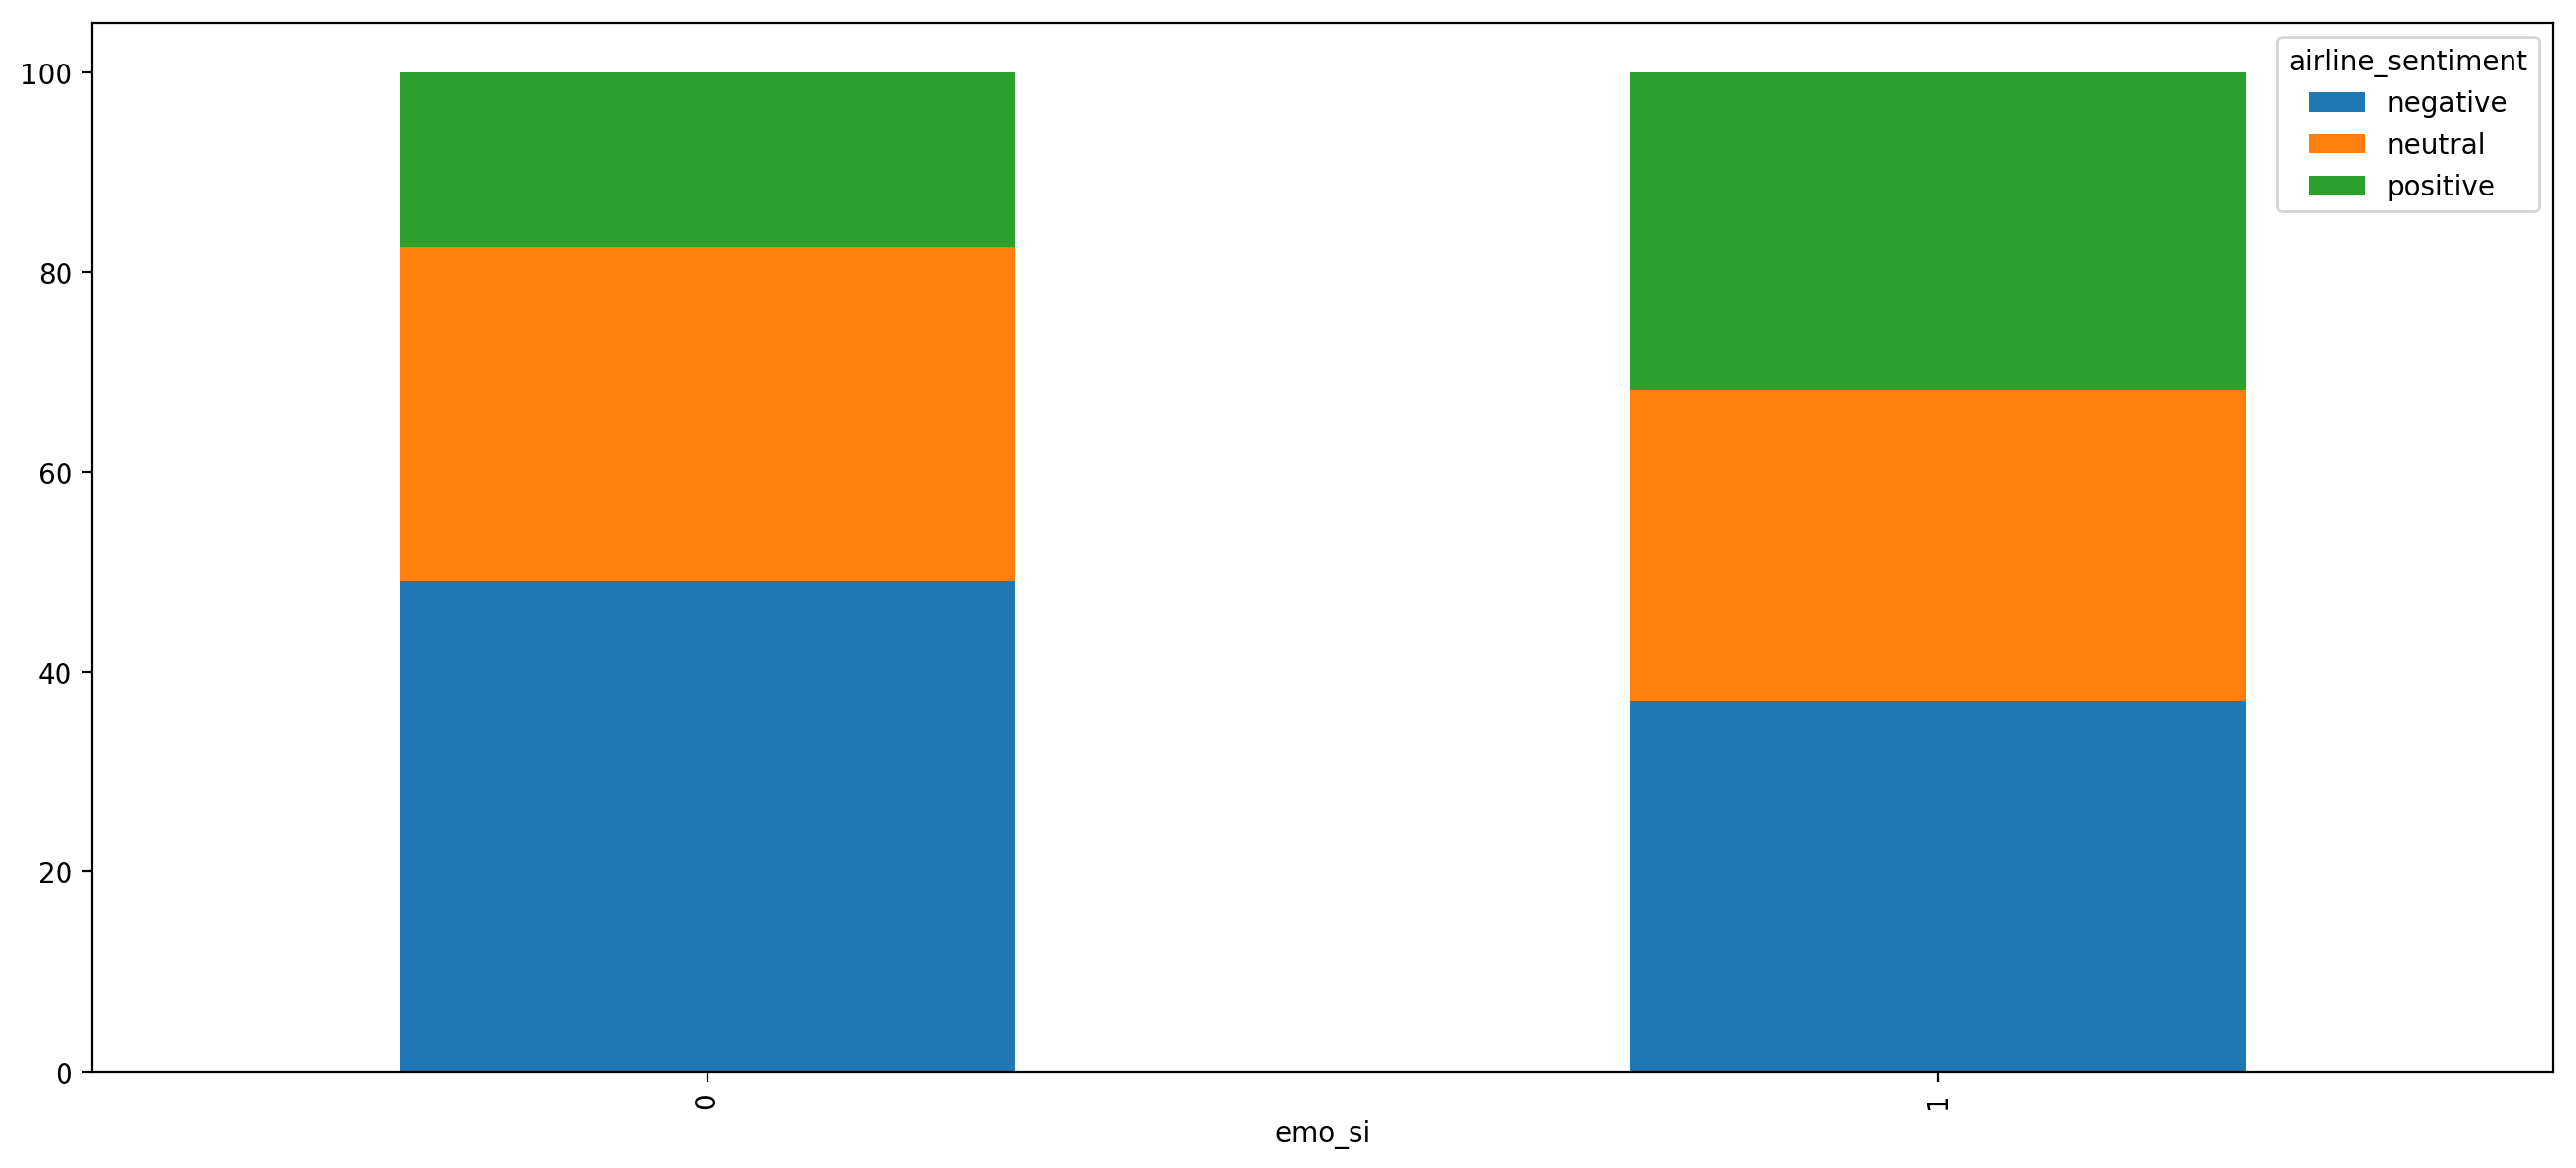

In [91]:
pd.crosstab(index=df['emo_si'],columns=df['airline_sentiment']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

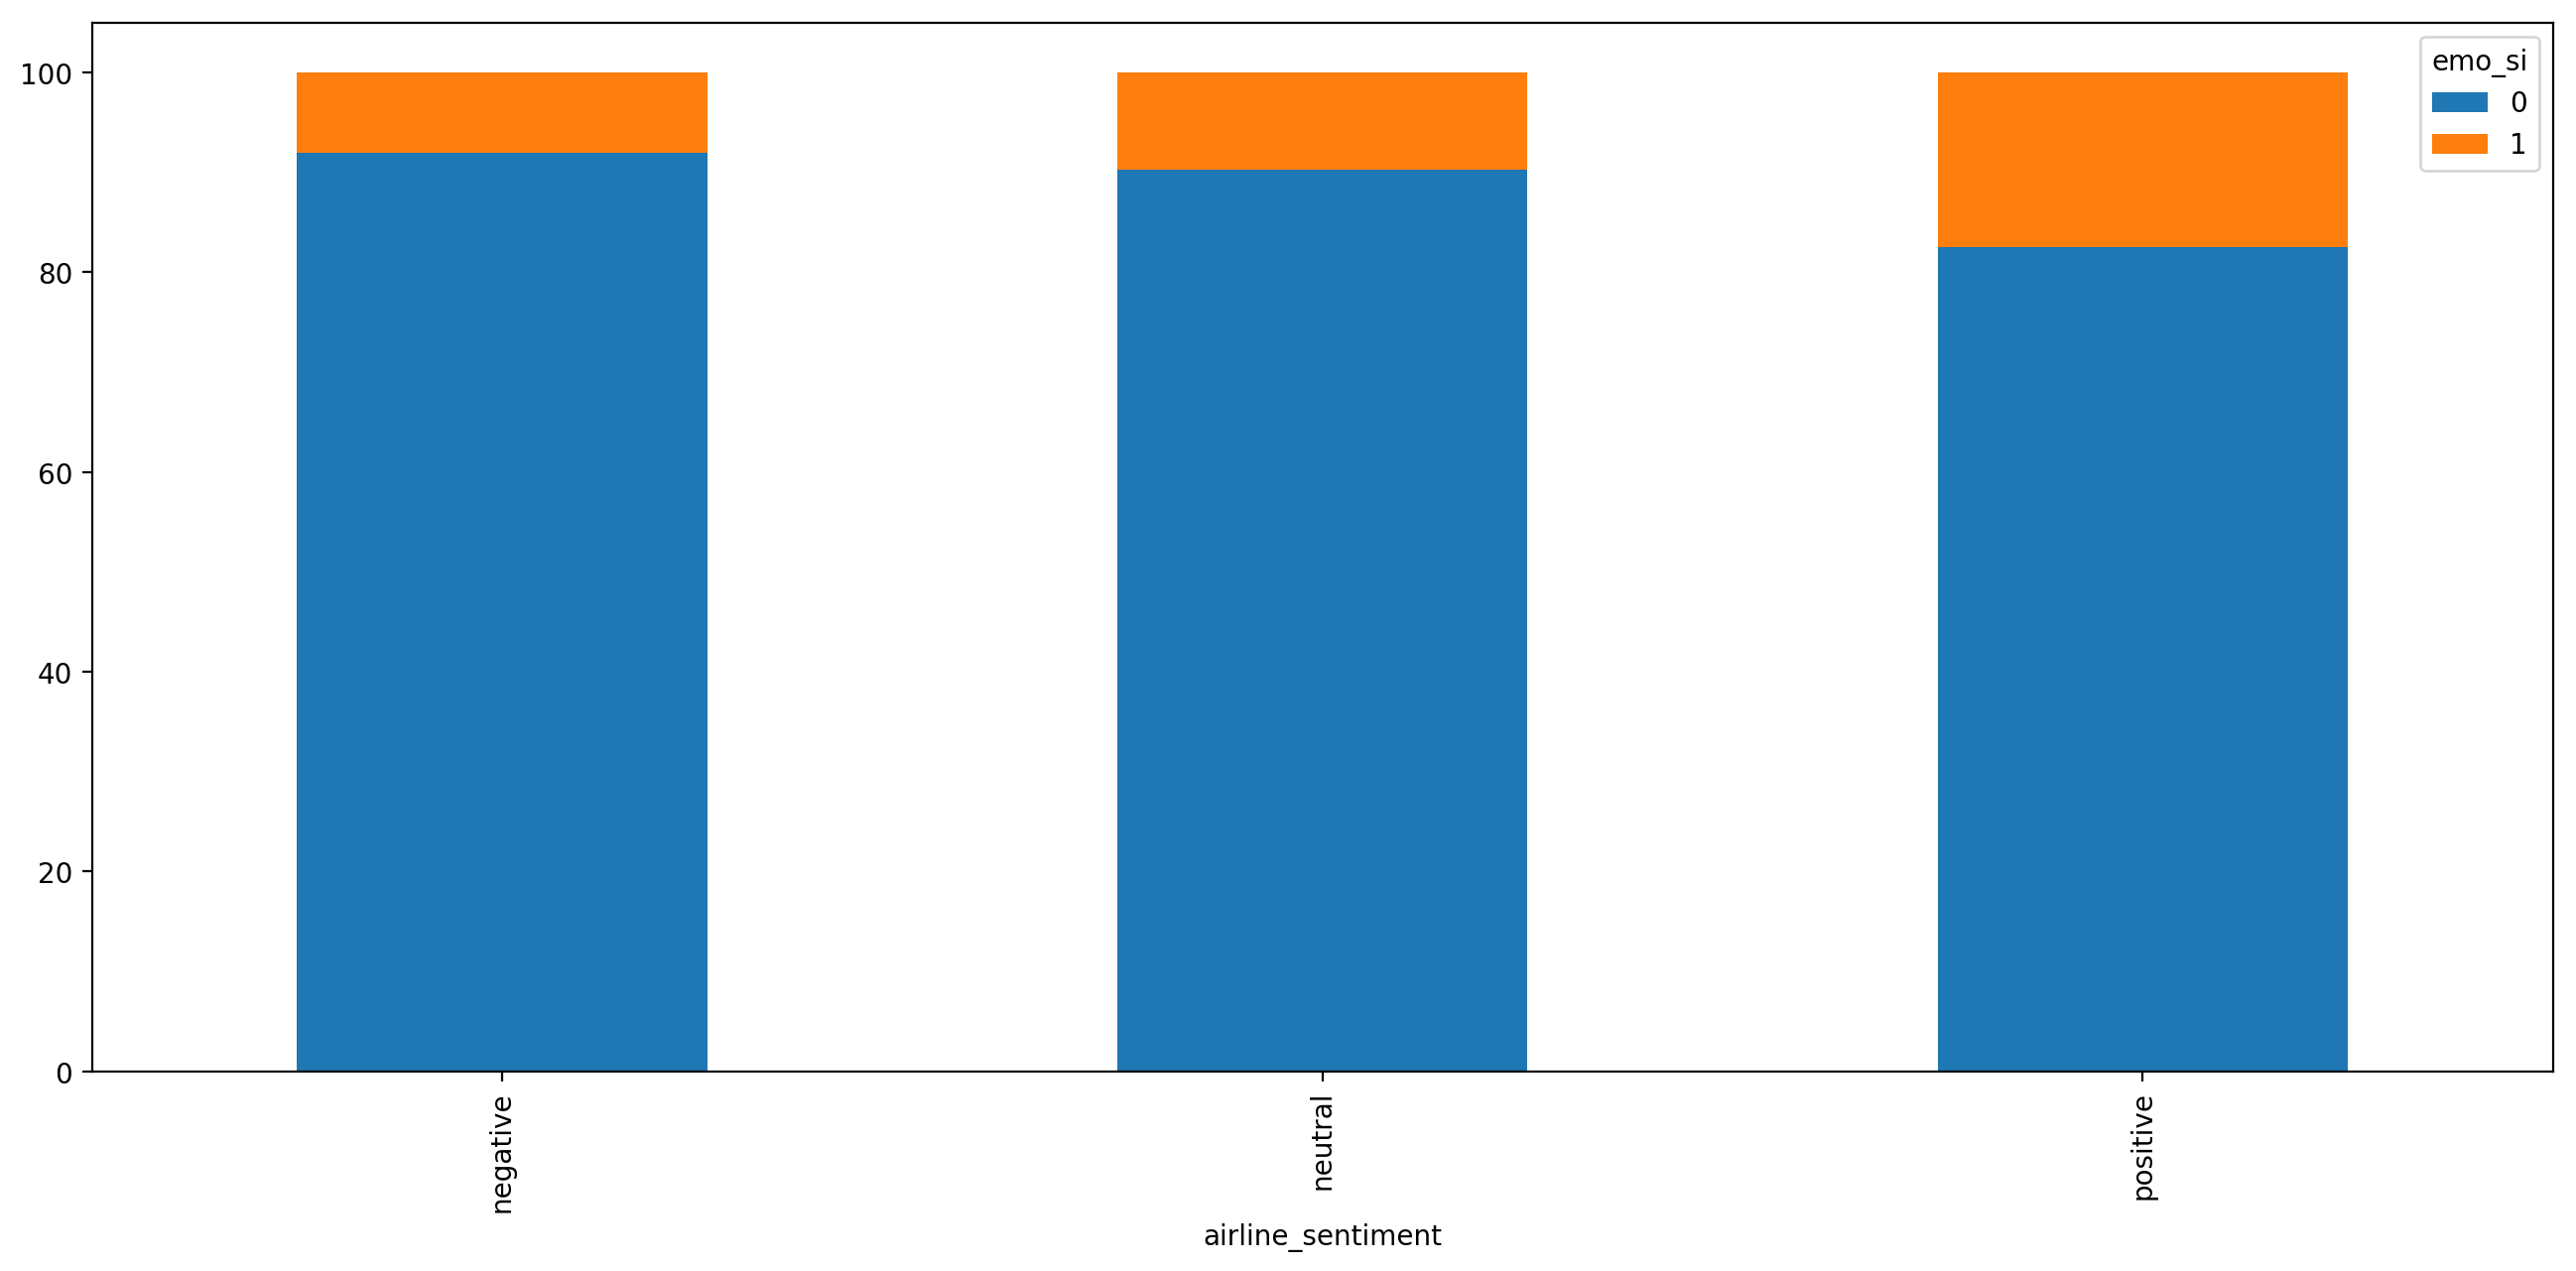

In [92]:
pd.crosstab(index=df['airline_sentiment'],columns=df['emo_si']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

In [93]:
df['spanair']=df['whole_tweet'].apply(lambda x: int(bool('accidente' in x and 'spanair' in x)))
print(df['spanair'].value_counts())

0    7707
1    160 
Name: spanair, dtype: int64


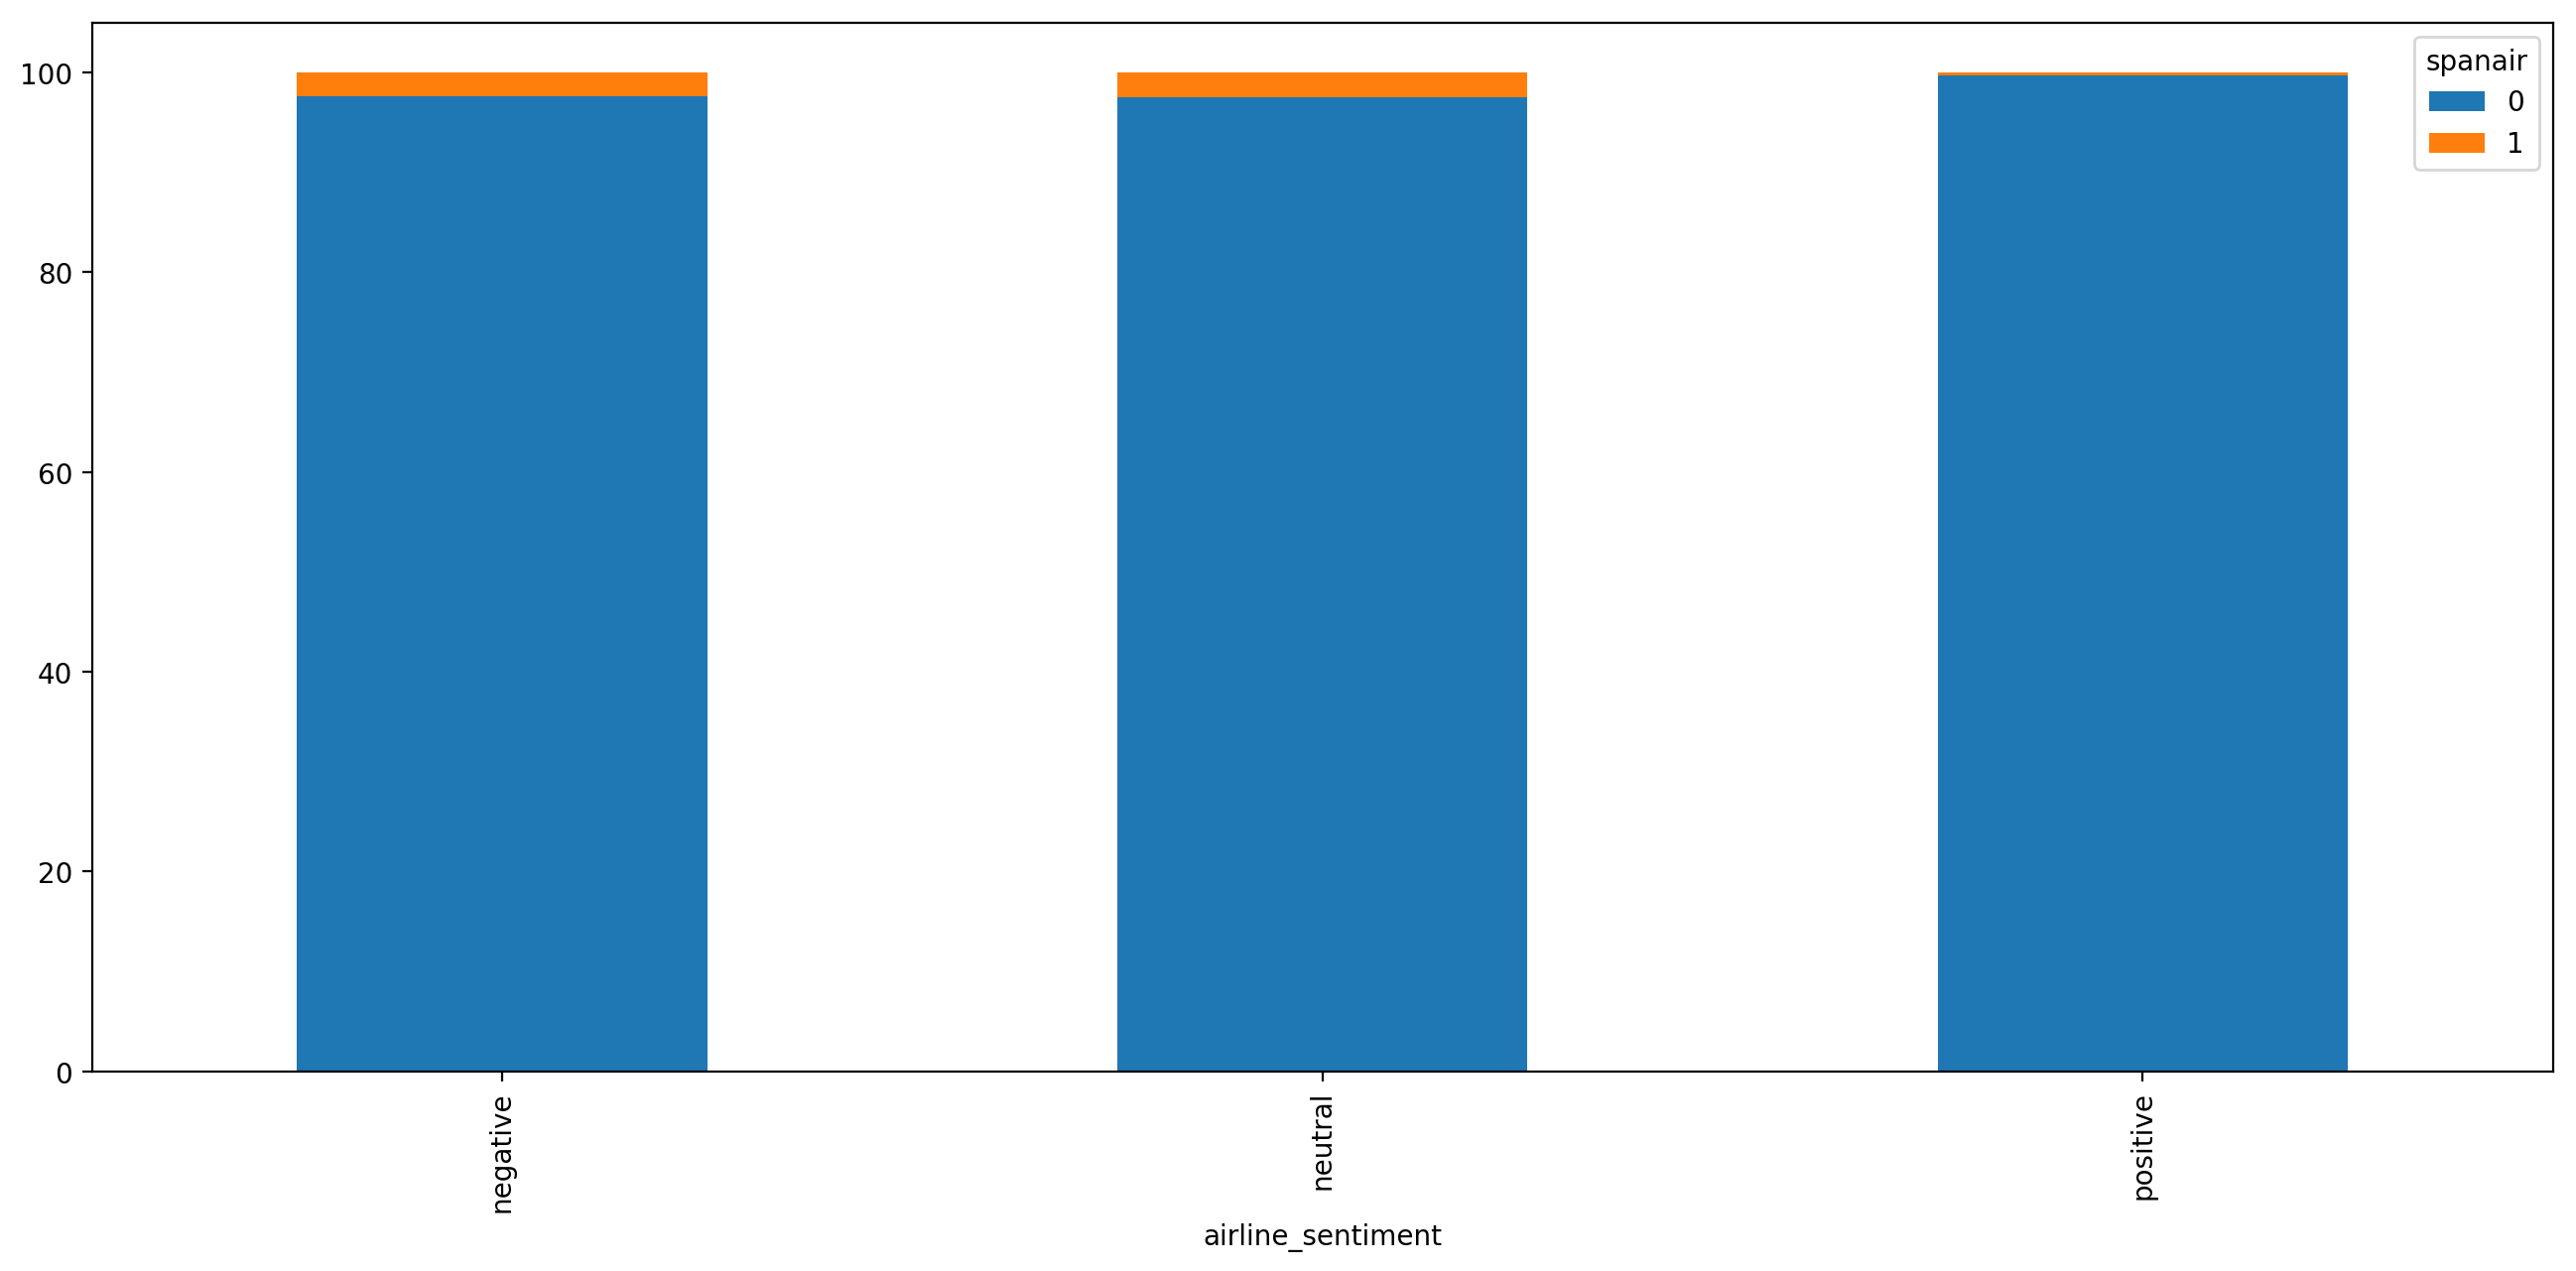

In [94]:
pd.crosstab(index=df['airline_sentiment'],columns=df['spanair']
           ).apply(lambda r: r/r.sum() *100,axis=1).plot(kind='bar', stacked=True)

## Revisión rápida de CORRELACIONES

In [95]:
corrkendall=df.corr(method='kendall')
corrpearson=df.corr(method='pearson')
corrspearman=df.corr(method='spearman')
print('Correlaciones Kendall:\n',corrkendall)
print('Correlaciones Pearson:\n',corrpearson)
print('Correlaciones Spearman:\n',corrspearman)
print('Correlación Kendall sentiment-is_reply: ',df.airline_sentiment.corr(df.is_reply,method='kendall'))
print('Correlación Kendall sentiment-weekday: ',df.airline_sentiment.corr(df.weekday,method='kendall'))
print('Correlación Kendall sentiment-dayhour: ',df.airline_sentiment.corr(df.dayhour,method='kendall'))

Correlaciones Kendall:
                     n_words  n_words_mayus  n_words_mayus_len  n_suspensivos  \
n_words            1.000000  0.175535       0.168536           0.096087        
n_words_mayus      0.175535  1.000000       0.967061           0.011860        
n_words_mayus_len  0.168536  0.967061       1.000000           0.010232        
n_suspensivos      0.096087  0.011860       0.010232           1.000000        
n_exclamations     0.031744 -0.004201      -0.003107           0.056454        
n_questions        0.136315  0.081620       0.077624           0.004379        
len_tw             0.848198  0.169596       0.164646           0.092375        
is_reply           0.060409  0.073967       0.068178           0.057806        
weekday           -0.014961  0.003958       0.004134          -0.000463        
dayhour           -0.002189  0.008711       0.007484           0.031053        
finde              0.006658 -0.003548      -0.004526           0.035135        
lun_mar         

/Users/mrp/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
